# Project 3 - Applied Statistics & Modeling
### Jonah Zembower, Benjamin Nicholson, Stanislav Chernyshev
## Introduction to Dataset
- Electricity Consumption: Normalised values of consumption of electricity across 100 intervals
- Stock Prices: Normalised values of prices of stocks over a 100 day period
- Temperature Fluctuations: Normalised values of temperature fluctuations over 100 intervals
- Advertising Impact: The impact of advertising on some type of performance mectric over 100 intervals
- Sales Data: Normalised values of sales from months over 10 years (120 intervals)
- Exchange Rates: Normalised Values of both exchange rate and economic indicator over 120 intervals

### Loading in Packages

In [1]:
#Base packages that are going to be 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

In [2]:
#Set the maximum number of rows that can be observed
pd.set_option('display.max_rows', 45)

### Function Creation
When doing a project that may involve reusing lines of code it is best to create a function that can be reused. This improves readability and decreases the reptitive nature of the different data sets. It can also be useful to store these and use them at a later date

In [3]:
#Create a function that is going to plot data 
#It is called time series because that is the type of data it is going to be primarily be dealing with
def time_series(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [4]:
#Create a function that is going to plot multiple series on the same graph
def multiple_time_series(series_list, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    for i, (xdata, ydata) in enumerate(series_list, start=1):
        plt.plot(xdata, ydata, label=f'Series {i}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [5]:
#Create a function that is going to make a bar chart
def bar_chart(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.bar(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [6]:
#Create the Dickey Fuller test to use on data
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

In [7]:
#Create a seasonal decomposition of the different parts that make up the data
#Creating a subplot where the values are stacked up on one another makes it easier to read

def plot_seasonal_decomposition(data, period):
    """
    Function to plot the seasonal decomposition of a time series.

    Parameters:
    - data: Pandas Series or DataFrame with a datetime index.
    - freq: Frequency of the seasonal component (e.g., 'D' for daily, 'M' for monthly).

    Returns:
    - None (plots the decomposition).
    """
    decomposition = seasonal_decompose(data, period=period)

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
#Get the decomposed values which make up the time series
def decompose_seasonality(data, period):    

    decomposition = seasonal_decompose(data, period=period)

    original = data
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return original, trend, seasonal, residual

In [9]:
#Create a for loop that replaces the missing values within the mean value
def missing_values_replace(days_replace,data,first_row,last_row):
    for day in days_replace:
        replace_value = data[first_row:last_row][day].mean()
        data.loc[last_row,day] = replace_value
    return data

In [10]:
#Create a rolling mean of the data to understand the trend
#This also incudes the standard deviation to understand the variance in data values

def roll_mean_std_dev(df_column,window):

    plt.figure(figsize=(10,6))
    #Look at the mean and the standard deviation of this data
    rolmean = df_column.rolling(window).mean()
    rolstd = df_column.rolling(window).std()

    #Let's check the stationarity of the graph
    #Plot the rolling statistics
    orig = plt.plot(df_column,color='blue',label='Original')
    mean = plt.plot(rolmean,color='red',label='Rolling Mean')
    std = plt.plot(rolstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [11]:
#When given a list of daily values it may be useful to break it up into weeks as rows and days as columns
#This is going to help be able to break up the data and perform statistical analysis
def create_weekly_data(df,value_column,incrementing_column):
    
    #Create the list of days as the column names
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    #Make a copy
    original_copy = df.copy()
    original_copy['Incrementing Day'] = range(0, len(original_copy))
    original_copy.set_index(incrementing_column,inplace=True)

    #Determine the number of weeks by adding 6 to the length so that partial weeks are counted
    num_weeks = (len(df)+6) // 7

    #Create a new datadrame where the index is the number of weeks and the columns are the days of the week
    weekly_data = pd.DataFrame(index=range(num_weeks),columns=days_of_week)

    #Fill the empty dataframe with data
    for i, row in original_copy.iterrows():
        week = i // 7
        day = days_of_week[i % 7]
        weekly_data.at[week, day] = row[value_column]

    return weekly_data

In [12]:
#When given a list of daily values which do not include weekend values such as stock data 
#it can be useful to break it up into weeks as rows and days as columns
#This can break up the data to perform statistical analysis

def create_week_day_data(df,value_column,incrementing_column):
    
    #Create the list of days as the column names
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

    #Make a copy
    original_copy = df.copy()
    original_copy['Incrementing Day'] = range(0, len(original_copy))
    original_copy.set_index(incrementing_column,inplace=True)

    #Determine the number of weeks by adding 6 to the length so that partial weeks are counted
    num_weeks = (len(df)+4) // 5

    #Create a new datadrame where the index is the number of weeks and the columns are the days of the week
    weekly_data = pd.DataFrame(index=range(num_weeks),columns=days_of_week)

    #Fill the empty dataframe with data
    for i, row in original_copy.iterrows():
        week = i // 5
        day = days_of_week[i % 5]
        weekly_data.at[week, day] = row[value_column]

    return weekly_data

In [13]:
#When dealing with monthly values it can be useful to split it up into months of the year with days within them
def create_monthly_data(df,value_column,incrementing_month):

    #Create list of months
    months = ['January','February','March','April','May','June','July','August','September','October','November','December']

    original_copy = df.copy()
    original_copy['Incrementing Month'] = range(0,len(original_copy))
    original_copy.set_index(incrementing_month,inplace=True)

    #Determine the number of years
    num_years = (len(df)+11) // 12

    #Create a new dataframe where the index is the number of years and the columns are the number of months
    monthly_data = pd.DataFrame(index=range(num_years),columns = months)

    #Fill the empty dataframe
    for i, row in original_copy.iterrows():
        year = i // 12
        month = months[(i) % 12]
        monthly_data.at[year,month] = row[value_column]

    return monthly_data

In [14]:
#Plot the seasonal values that make up the decomposition
def seasonal_values_plot(decomposed_data_seasonal,lag_length,y_column,title,xlabel,period_list,ylabel):
    seasonal_data = pd.DataFrame(decomposed_data_seasonal[0:lag_length])
    plt.figure(figsize=(12,6))
    plt.plot(seasonal_data.index,seasonal_data[y_column])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(seasonal_data.index,period_list)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel)

In [15]:
#Find statistical information and add it onto the dataframe
#This is used for weekly data (Monday-Sunday)
def mean_median_variance_std_weekly(data, columns):

    num_weeks = len(data)

    data['Weekly Mean'] = data.sum(axis=1)/7
    data['Weekly Median'] = data[columns].median(axis=1)
    data['Standard Deviation'] = data[columns].std(axis=1)
    data['Variance'] = data[columns].var(axis=1)

    data.loc['Mean'] = data.mean()
    data.loc['Median'] = data.median()
    data.loc['Variance'] = data.var()
    data.loc['Standard Deviation'] = data.std()

    rows_to_select = slice(num_weeks,len(data))
    columns_to_select = slice(7,11)
    data.iloc[rows_to_select,columns_to_select] = pd.np.nan

    return data

In [16]:
#Find statistical information and add it onto the dataframe
#This is used for week-day data (Monday-Friday)
def mean_median_variance_std_week_day(data, columns):

    num_weeks = len(data)

    data['Weekly Mean'] = data.sum(axis=1)/5
    data['Weekly Median'] = data[columns].median(axis=1)
    data['Standard Deviation'] = data[columns].std(axis=1)
    data['Variance'] = data[columns].var(axis=1)

    data.loc['Mean'] = data.mean()
    data.loc['Median'] = data.median()
    data.loc['Variance'] = data.var()
    data.loc['Standard Deviation'] = data.std()

    rows_to_select = slice(num_weeks,len(data))
    columns_to_select = slice(5,9)
    data.iloc[rows_to_select,columns_to_select] = pd.np.nan

    return data

In [17]:
#Find statistical information and add it onto the dataframe
#This is used for weekly data (Monday-Sunday)
def mean_median_variance_std_monthly(data, columns):

    num_months = len(data)

    data['Monthly Mean'] = data.sum(axis=1)/7
    data['Monthly Median'] = data[columns].median(axis=1)
    data['Standard Deviation'] = data[columns].std(axis=1)
    data['Variance'] = data[columns].var(axis=1)

    data.loc['Mean'] = data.mean()
    data.loc['Median'] = data.median()
    data.loc['Variance'] = data.var()
    data.loc['Standard Deviation'] = data.std()

    rows_to_select = slice(num_months,len(data))
    columns_to_select = slice(12,16)
    data.iloc[rows_to_select,columns_to_select] = pd.np.nan

    return data

In [18]:
#Create a least squares line going through the data values

def plot_least_squares_line(x_value, y_value, title, x_label, y_label):
    plt.figure(figsize=(10,6))
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Predicting y values using the model
    y_pred = model.predict(x)

    # Plotting the original data and the least squares line
    plt.scatter(x, y, label='original data', color='blue')
    plt.plot(x, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [19]:
import matplotlib.pyplot as plt

def create_boxplot_multiple_weeks(data, week_indices):
    fig, ax = plt.subplots(figsize=(10, 6))
    boxplot_data = [data.loc[idx] for idx in week_indices]
    ax.boxplot(boxplot_data, labels=week_indices)
    ax.set_title('Box Plot of Weekly Data')
    ax.set_xlabel('Week Index')
    ax.set_ylabel('Values')
    plt.show()


In [20]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def select_best_ar_model(data, ar_orders):

    """
    Selects the best AR model based on AIC and BIC criteria.

    Parameters:
    - data: The time series data.
    - ar_orders: A list of integers for AR(p) orders to test.

    Returns:
    - A dictionary with the best model's details according to AIC and BIC.
    """
    import warnings

    # Suppress the specific warning about inferred frequency
    warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
    
    best_aic, best_bic = np.inf, np.inf
    best_aic_model, best_bic_model = None, None

    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0))  # AR(p) model
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_aic_model = p

            if results.bic < best_bic:
                best_bic = results.bic
                best_bic_model = p

        except Exception as e:
            print(f"Error fitting AR({p}) model: {e}")
            continue

    return {
        'best_aic': best_aic,
        'best_aic_model': best_aic_model,
        'best_bic': best_bic,
        'best_bic_model': best_bic_model
    }


In [21]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def select_best_ma_model(data, ma_orders):
    """
    Selects the best MA model based on AIC and BIC criteria.

    Parameters:
    - data: The time series data.
    - ma_orders: A list of integers for MA(q) orders to test.

    Returns:
    - A dictionary with the best model's details according to AIC and BIC.
    """
    import warnings

    # Suppress the specific warning about inferred frequency
    warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
    
    best_aic, best_bic = np.inf, np.inf
    best_aic_model, best_bic_model = None, None

    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q))  # MA(q) model
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_aic_model = q

            if results.bic < best_bic:
                best_bic = results.bic
                best_bic_model = q

        except Exception as e:
            print(f"Error fitting MA({q}) model: {e}")
            continue

    return {
        'best_aic': best_aic,
        'best_aic_model': best_aic_model,
        'best_bic': best_bic,
        'best_bic_model': best_bic_model
    }


In [22]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

def select_best_arma_model(data, ar_orders, ma_orders):
    """
    Selects the best ARMA model based on AIC and BIC criteria.

    Parameters:
    - data: The time series data.
    - ar_orders: A list of integers for AR(p) orders to test.
    - ma_orders: A list of integers for MA(q) orders to test.

    Returns:
    - A dictionary with the best model's details according to AIC and BIC.
    """
    import warnings

    # Suppress the specific warning about inferred frequency
    warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
    
    best_aic, best_bic = np.inf, np.inf
    best_aic_model, best_bic_model = None, None

    # Generate all combinations of AR and MA orders
    orders = list(product(ar_orders, ma_orders))

    for order in orders:
        try:
            model = ARIMA(data, order=(*order, 0))  # ARMA(p,q) model
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_aic_model = order

            if results.bic < best_bic:
                best_bic = results.bic
                best_bic_model = order

        except Exception as e:
            print(f"Error fitting ARMA{order}: {e}")
            continue

    return {
        'best_aic': best_aic,
        'best_aic_model': best_aic_model,
        'best_bic': best_bic,
        'best_bic_model': best_bic_model
    }


In [23]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

def select_best_arima(data, ar_orders, ma_orders, d_orders):
    """
    Selects the best ARIMA model based on AIC and BIC criteria.

    Parameters:
    - data: The time series data.
    - ar_orders: A list of integers for AR(p) orders to test.
    - ma_orders: A list of integers for MA(q) orders to test.
    - d_orders: A list of integers for differencing (d) orders to test.

    Returns:
    - A dictionary with the best model's details according to AIC and BIC.
    """
    import warnings
    warnings.filterwarnings("ignore")
    
    import warnings

    # Suppress the specific warning about inferred frequency
    warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
    
    best_aic, best_bic = np.inf, np.inf
    best_aic_model, best_bic_model = None, None

    # Generate all combinations of AR, MA, and differencing orders
    orders = list(product(ar_orders, d_orders, ma_orders))

    for order in orders:
        try:
            model = ARIMA(data, order=order)
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_aic_model = order

            if results.bic < best_bic:
                best_bic = results.bic
                best_bic_model = order

        except Exception as e:
            print(f"Error fitting ARIMA{order}: {e}")
            continue

    return {
        'best_aic': best_aic,
        'best_aic_model': best_aic_model,
        'best_bic': best_bic,
        'best_bic_model': best_bic_model
    }


In [24]:
from pmdarima import auto_arima

def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
    """
    Fits a SARIMA model to the provided data, searching over given parameter lists.
    It returns the best model based on AIC and also provides its BIC for comparison.
   
    Parameters:
    - data: Pandas Series of the time series data.
    - p_list, d_list, q_list: Lists of integers for the AR (p), differencing (d), and MA (q) parameters.
    - P_list, D_list, Q_list: Lists of integers for the seasonal AR (P), seasonal differencing (D),
                              and seasonal MA (Q) parameters.
    - s: Integer representing the length of the seasonal cycle.
   
    Returns:
    - A dictionary with the best model's AIC and BIC, along with the corresponding parameters.
    """
   
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

In [265]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_sarimax(data, target_column, exog_column, pdq, seasonal_pdq):
    """
    Fits a SARIMAX model to the specified target column using an exogenous variable and specified orders.

    Parameters:
    - data: Pandas DataFrame containing the dataset.
    - target_column: String name of the column to be forecasted.
    - exog_column: String name of the exogenous variable column.
    - pdq: Tuple for non-seasonal (p, d, q) order.
    - seasonal_pdq: Tuple for seasonal (P, D, Q, s) order.

    Returns:
    - results: Fitted SARIMAX model results.
    """
    # Extract the time series and the exogenous variable series
    target_series = data[target_column]
    exog_series = data[exog_column]

    # Define the SARIMAX model
    model = SARIMAX(target_series, exog=exog_series, order=pdq, seasonal_order=seasonal_pdq,
                    enforce_stationarity=False, enforce_invertibility=False)

    # Fit the model
    results = model.fit()

    return results

## Electricity Consumption
The consumption of electricity can be taken as daily or monthly recordings usually. As there is no distinct time interval that is given, some investigaiton is going to be done to decipher the best time interval to choose.

### Data exploration
- Load the Data: Begin by loading each dataset from the Excel file.

- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components.

In [25]:
#Import the different datasets from the excel sheet
electricity_consumption = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Electricity Consumption')

In [26]:
#Preprocess electricity consumption data
#Create a new column called day that is going to be set as the index
#This is done so that the time series can have dates as the x columns
electricity_consumption['Day'] = pd.date_range('2024-01-01',periods=len(electricity_consumption))
electricity_consumption.drop(columns='Unnamed: 0',inplace=True)
electricity_consumption.set_index('Day',inplace=True)
electricity_consumption['Incrementing Day'] = range(1,len(electricity_consumption)+1)
electricity_consumption

Electricity Consumption  Incrementing Day
Day                                                  
2024-01-01                 1.764052                 1
2024-01-02                 1.282183                 2
2024-01-03                 1.619830                 3
2024-01-04                 3.050808                 4
2024-01-05                 3.392962                 5
...                             ...               ...
2024-04-05                 1.230737                96
2024-04-06                 0.625869                97
2024-04-07                 2.098805                98
2024-04-08                 1.176315                99
2024-04-09                 0.990147               100

[100 rows x 2 columns]

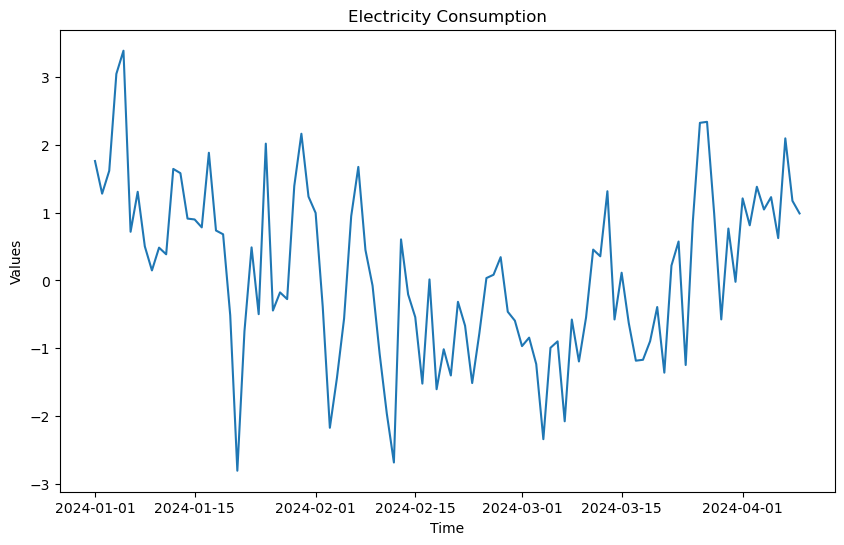

In [27]:
#Plot the time series
time_series(electricity_consumption.index,electricity_consumption['Electricity Consumption'],'Electricity Consumption','Time','Values')

#### Time interval decision
As there is no given time in the data, it is up to us to decide what a reasonable guess would be for the interval. It is fair to instantly ignore the possibility of it being a yearly measurement as the amount of electricity that is consumed now would trump the amount consumed 100 years ago. So it is between a weekly and a monthly basis. I am going to decompose for a weekly basis and a monthly basis. Looking at the seasonality pattern should be able to represent real world situations. 

#### Daily recordings
This would assume that the electricity consumption is recorded for a given day and you would want a seasonality based on the week (7). Look at the seasonality pattern and see if it makes sense

In [28]:
#Decompose the data into its individual parts, these can be accessed by indexing through the results
#[0] - Original
#[1] - Trend
#[2] - Seasonal
#[3] - Residual
weekly_electricity_consumption_decomposition = decompose_seasonality(electricity_consumption['Electricity Consumption'],7)

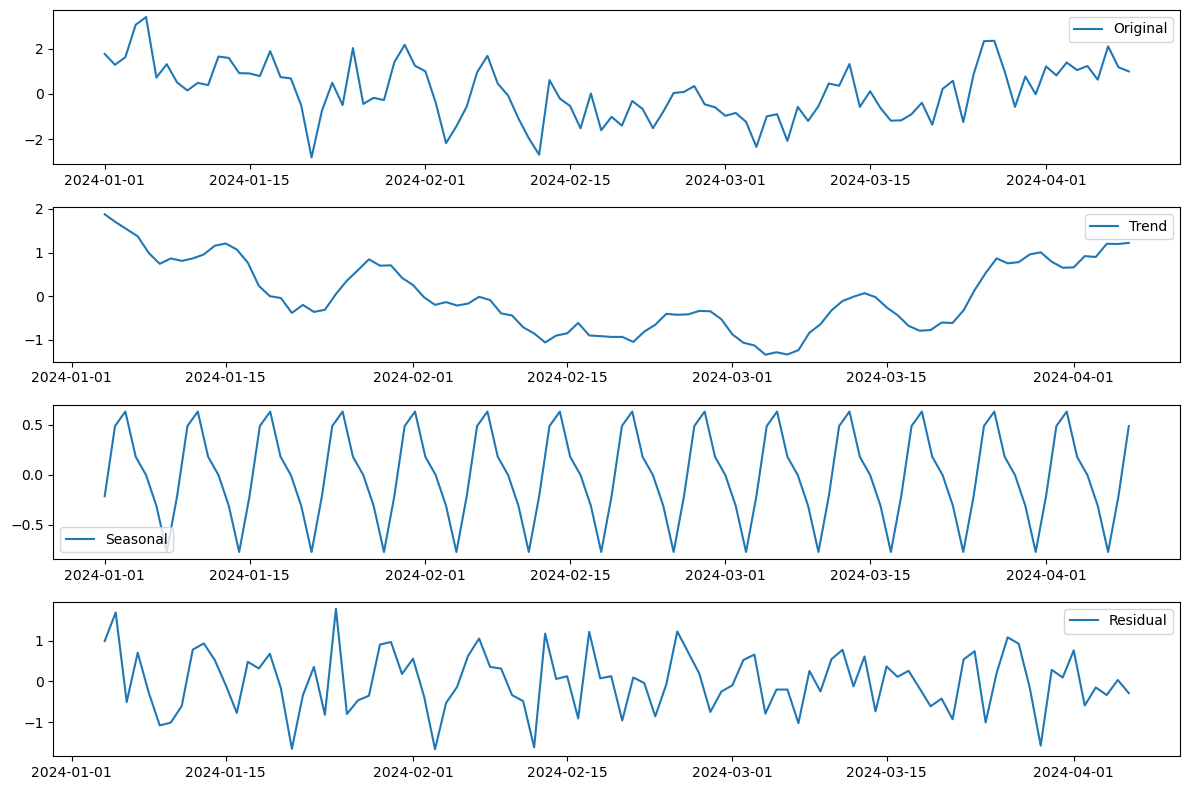

In [29]:
#Plot the electricity consumption seasonal decomposition
plot_seasonal_decomposition(electricity_consumption['Electricity Consumption'],7)

#### Weekly seasonality decomposition
Trend - There is no overall change in average values in the time series

Cycles - There is a downturn during the beginning of February which continues until the middle of March before returning to similar higher levels as seen at the start of the year. This could be due to the nicer weather that takes place during February and March that does not require A/C or a heater. Where as in January you might be using a heater to come the house warm while the AC might be turned as you head into April due to warmer temperatures.

Seasonality - There is a constant seasonality which has a period of peaks with a downturn which is going by a quick increase to the peak, which takes place within the weekly season

Residual - The residual as a constant mean around 0 with white noise

#### Seasonality Decomposition of Electricity Consumption

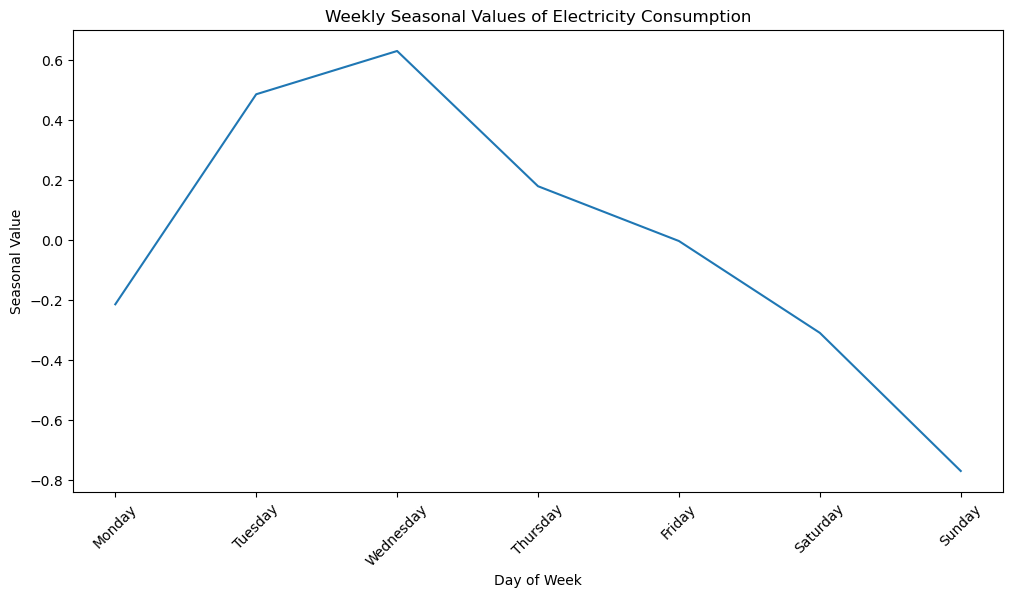

In [30]:
#plot the seasonal values on a graph so that you can understand which days have higher electricity consumed
days_column=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
seasonal_values_plot(weekly_electricity_consumption_decomposition[2],7,'seasonal',
                     'Weekly Seasonal Values of Electricity Consumption','Day of Week',days_column,'Seasonal Value')

#### Weekly Seasonal Values
The seasonal values show a peak during the working week with drops on Saturday and Sunday. This might suggest that it represents some work place where the weekends have a much smaller number of people that are working and therefore the amount fo electricity that is used is going to be much smaller. Where as during the week the electricity is higher. This would make logical sense for the period to be week.

#### Monthly recordings
This would imply that the recordings occured at the end of each month. The seasonality would reflect how the values change from month to month. 


In [31]:
#Change the index of electricity consumption to months rather than day
electricity_consumption['Month'] = pd.date_range('2015-01-01',periods=len(electricity_consumption),freq='MS')
electricity_consumption.set_index('Month',inplace=True)
electricity_consumption

Electricity Consumption  Incrementing Day
Month                                                
2015-01-01                 1.764052                 1
2015-02-01                 1.282183                 2
2015-03-01                 1.619830                 3
2015-04-01                 3.050808                 4
2015-05-01                 3.392962                 5
...                             ...               ...
2022-12-01                 1.230737                96
2023-01-01                 0.625869                97
2023-02-01                 2.098805                98
2023-03-01                 1.176315                99
2023-04-01                 0.990147               100

[100 rows x 2 columns]

In [32]:
#Monthly electricity consumption decomposition
monthly_electricity_consumption_decomposition = decompose_seasonality(electricity_consumption['Electricity Consumption'],12)

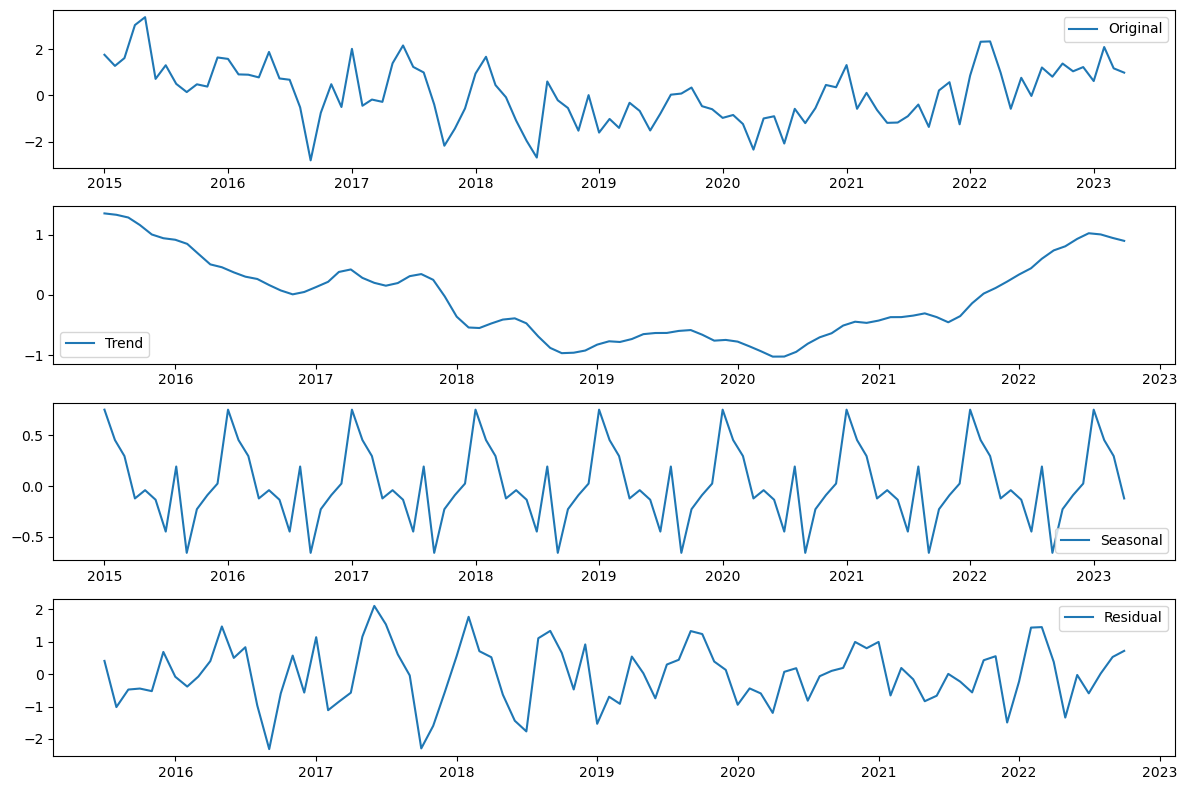

In [33]:
#Plot the electricity consumption which has a lag of 12 which would represent the months of the year
plot_seasonal_decomposition(electricity_consumption['Electricity Consumption'],12)

Monthly interval - This shows less of a consistient seasonal pattern and has spikes and dips. This would not reflect what would be expected when looking at monthly electricity consumption as it is assumed that there is a strong correlation with weather which changes more smoothly. 

Trend - There is no overall change in the average values in the time series.

Cycle - There is a cycle that takes place where there is a drop from 2018 to 2021 before 2022 and 2023 returns to values similar to 2016. This does not make a while lot of sense because it is assumed that the amount of electricity that was used during 2020 and 2021 would be far higher due to the Covid-19 Pandemic which took place due to the number of people that had to stay inside.

Seasonality - This seasonality does not follow as clear of a gradual change as it did with the weekly values

Residual - The residual values also seem to be larger

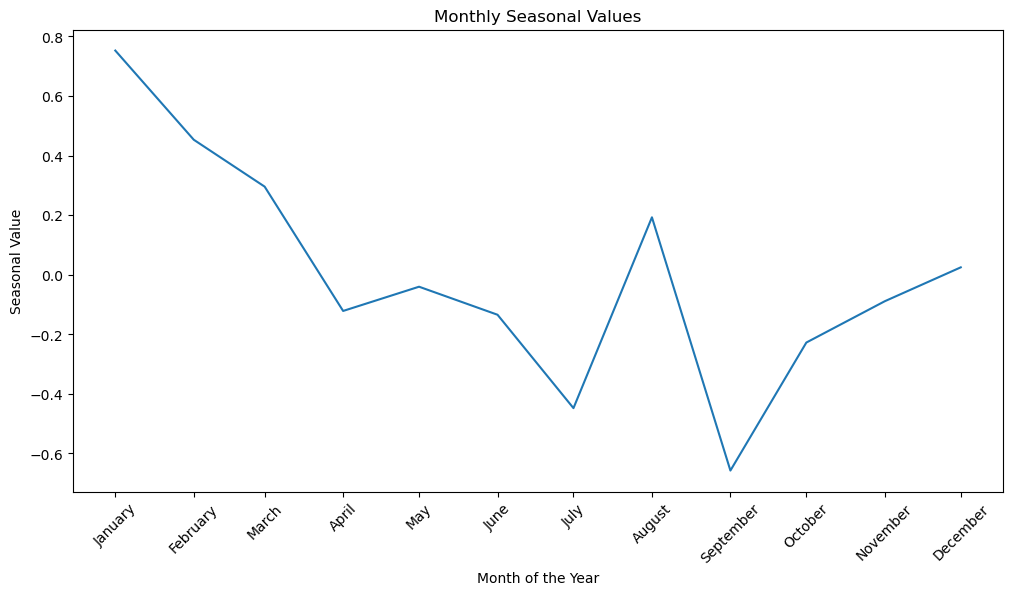

In [34]:
#Create the months of the year list
months_list = ['January','February','March','April','May','June','July','August','September','October','November','December']

#Plot the seasonal monthly values graph
seasonal_values_plot(monthly_electricity_consumption_decomposition[2],12,'seasonal',
                     'Monthly Seasonal Values','Month of the Year',months_list,'Seasonal Value')

#### Monthly Seasonal Values
Using months as the seasonal value it shows that January is the peak with decreasing values to July until a sudden spike up in August before leveling out in October through December. This does not follow as clear of a pattern as it does with the weekly seasonal values. 

#### Mean Absolute Error
This value will give you the average distance that the residuals are from the line of zero. The most accurate seasonal decomposition has residuals of 0, so the residual with the smallest mean absolute error is going to reflect a more accurate depiction of the movement of the data. Comparing the weekly and the monthly should also give better insight into which is better to use for the time interval

In [35]:
#MAE for using the period as week
weekly_electricity_consumption_decomposition[3].dropna(inplace=True)
zeros = np.zeros(len(weekly_electricity_consumption_decomposition[3]))
mean_absolute_error(zeros, weekly_electricity_consumption_decomposition[3]) 

0.5925758047097736

In [36]:
#MAE for using the period as month
monthly_electricity_consumption_decomposition[3].dropna(inplace=True)
zeros_88 = np.zeros(len(monthly_electricity_consumption_decomposition[3]))
mean_absolute_error(zeros_88,monthly_electricity_consumption_decomposition[3])

0.7489559703540682

#### Weekly or Monthly for time interval?
Weekly electricity is going to be the correct interval that is used for the time series due to the behavior of the seasonality, understanding of real world events and the lower mean absolute error.

### Preliminary Analysis
- Descriptive Statistics: Compute and interpret the mean, median, variance, and standard deviation for each dataset.

In [37]:
#Create a day column for electricity consumption and make that the index
#Remember that it was last used as month
electricity_consumption['Day'] = pd.date_range(start='2024-01-01', periods=len(electricity_consumption), freq='D')
electricity_consumption.set_index('Day',inplace=True)
electricity_consumption

Electricity Consumption  Incrementing Day
Day                                                  
2024-01-01                 1.764052                 1
2024-01-02                 1.282183                 2
2024-01-03                 1.619830                 3
2024-01-04                 3.050808                 4
2024-01-05                 3.392962                 5
...                             ...               ...
2024-04-05                 1.230737                96
2024-04-06                 0.625869                97
2024-04-07                 2.098805                98
2024-04-08                 1.176315                99
2024-04-09                 0.990147               100

[100 rows x 2 columns]

In [38]:
#Create a new dataframe that is in weekly data
#This is done so that you can look at the different statistical information easier
#You can look at these statistics based on their week and also on their day of the week
electricity_consumption_weekly = create_weekly_data(electricity_consumption,'Electricity Consumption','Incrementing Day')
electricity_consumption_weekly

Monday   Tuesday Wednesday  Thursday    Friday  Saturday    Sunday
0   1.764052  1.282183   1.61983  3.050808  3.392962  0.719203   1.30969
1   0.503488  0.148525  0.484861  0.386474  1.647511  1.584793  0.914072
2   0.900899  0.784124  1.886141  0.737912  0.682024 -0.513084 -2.809532
3  -0.751147  0.488863 -0.497734  2.020888 -0.443922 -0.176202 -0.275285
4   1.395137  2.166927  1.238411  0.997368 -0.389102 -2.175347 -1.435586
5  -0.561444  0.949569  1.677164  0.451255 -0.076675 -1.086891 -1.963463
6  -2.688002  0.606775 -0.206265 -0.541207 -1.523399  0.015791 -1.606002
7  -1.015741 -1.403337 -0.314766 -0.668188 -1.514726 -0.785545  0.035559
8   0.084297   0.34462 -0.462012 -0.593747 -0.969334  -0.84422 -1.235256
9  -2.343911 -0.994529 -0.899046 -2.079721 -0.577078 -1.195838 -0.545973
10  0.456104  0.357035  1.317918 -0.575867  0.114408 -0.627606   -1.1846
11  -1.17115 -0.897127 -0.392398 -1.361349  0.220152  0.575738 -1.248374
12  0.864065  2.327922   2.34274  0.991445  -0.57503  0.766937 -0.019709
13  1.212591   0.81457  1.383924  1.048329  1.230737  0.625869  2.098805
14  1.176315  0.990147       NaN       NaN       NaN       NaN       NaN

#### NaN Values Solutions
There are missing values in week 14 and there are a few ways to overcome this problem
1. Remove week 14, as there are only 2 real data values it might be smart to remove this week to ensure data integrity
2. Replace with mean of values, replace the NaN with the mean of the first 13 weeks - going to work when there is no overall trend
3. Replace most recent value - going to work when there is an overall trend to the data

For this dataset, replace the Nan values with the mean

In [39]:
#Find the average from weeks 1-14 and then replace na with those values
days_replace = ['Wednesday','Thursday','Friday','Saturday','Sunday']
missing_values_replace(days_replace,electricity_consumption_weekly,0,14)

Monday   Tuesday Wednesday  Thursday    Friday  Saturday    Sunday
0   1.764052  1.282183   1.61983  3.050808  3.392962  0.719203   1.30969
1   0.503488  0.148525  0.484861  0.386474  1.647511  1.584793  0.914072
2   0.900899  0.784124  1.886141  0.737912  0.682024 -0.513084 -2.809532
3  -0.751147  0.488863 -0.497734  2.020888 -0.443922 -0.176202 -0.275285
4   1.395137  2.166927  1.238411  0.997368 -0.389102 -2.175347 -1.435586
5  -0.561444  0.949569  1.677164  0.451255 -0.076675 -1.086891 -1.963463
6  -2.688002  0.606775 -0.206265 -0.541207 -1.523399  0.015791 -1.606002
7  -1.015741 -1.403337 -0.314766 -0.668188 -1.514726 -0.785545  0.035559
8   0.084297   0.34462 -0.462012 -0.593747 -0.969334  -0.84422 -1.235256
9  -2.343911 -0.994529 -0.899046 -2.079721 -0.577078 -1.195838 -0.545973
10  0.456104  0.357035  1.317918 -0.575867  0.114408 -0.627606   -1.1846
11  -1.17115 -0.897127 -0.392398 -1.361349  0.220152  0.575738 -1.248374
12  0.864065  2.327922   2.34274  0.991445  -0.57503  0.766937 -0.019709
13  1.212591   0.81457  1.383924  1.048329  1.230737  0.625869  2.098805
14  1.176315  0.990147  0.655626  0.276029  0.087038   -0.2226 -0.568975

#### Finding mean, standard deviation, median and variance

In [40]:
#Create mean, median, std and variance for days of week and each week
electricity_consumption_statistics = mean_median_variance_std_weekly(electricity_consumption_weekly,days_column)
electricity_consumption_statistics

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_11897/3543321098.py:19: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  data.iloc[rows_to_select,columns_to_select] = pd.np.nan


Monday   Tuesday Wednesday  Thursday    Friday  \
0                   1.764052  1.282183   1.61983  3.050808  3.392962   
1                   0.503488  0.148525  0.484861  0.386474  1.647511   
2                   0.900899  0.784124  1.886141  0.737912  0.682024   
3                  -0.751147  0.488863 -0.497734  2.020888 -0.443922   
4                   1.395137  2.166927  1.238411  0.997368 -0.389102   
5                  -0.561444  0.949569  1.677164  0.451255 -0.076675   
6                  -2.688002  0.606775 -0.206265 -0.541207 -1.523399   
7                  -1.015741 -1.403337 -0.314766 -0.668188 -1.514726   
8                   0.084297   0.34462 -0.462012 -0.593747 -0.969334   
9                  -2.343911 -0.994529 -0.899046 -2.079721 -0.577078   
10                  0.456104  0.357035  1.317918 -0.575867  0.114408   
11                  -1.17115 -0.897127 -0.392398 -1.361349  0.220152   
12                  0.864065  2.327922   2.34274  0.991445  -0.57503   
13                  1.212591   0.81457  1.383924  1.048329  1.230737   
14                  1.176315  0.990147  0.655626  0.276029  0.087038   
Mean                -0.01163  0.531084  0.655626  0.276029  0.087038   
Median                0.2702  0.568929  0.655626  0.331251  0.005181   
Variance            1.625875  0.958035  0.965677  1.493991  1.421308   
Standard Deviation  1.294682  0.954831  0.956145   1.21987  1.198883   

                    Saturday    Sunday  Weekly Mean  Weekly Median  \
0                   0.719203   1.30969     1.876961       1.619830   
1                   1.584793  0.914072     0.809960       0.503488   
2                  -0.513084 -2.809532     0.238355       0.737912   
3                  -0.176202 -0.275285     0.052209      -0.275285   
4                  -2.175347 -1.435586     0.256830       0.997368   
5                  -1.086891 -1.963463    -0.087212      -0.076675   
6                   0.015791 -1.606002    -0.848901      -0.541207   
7                  -0.785545  0.035559    -0.809535      -0.785545   
8                   -0.84422 -1.235256    -0.525093      -0.593747   
9                  -1.195838 -0.545973    -1.233728      -0.994529   
10                 -0.627606   -1.1846    -0.020373       0.114408   
11                  0.575738 -1.248374    -0.610644      -0.897127   
12                  0.766937 -0.019709     0.956910       0.864065   
13                  0.625869  2.098805     1.202118       1.212591   
14                   -0.2226 -0.568975     0.341940       0.276029   
Mean                 -0.2226 -0.568975          NaN            NaN   
Median               -0.2226 -0.568975          NaN            NaN   
Variance            0.813013  1.479715          NaN            NaN   
Standard Deviation   0.90817  1.275087          NaN            NaN   

                    Standard Deviation  Variance  
0                             0.980731  0.961833  
1                             0.595700  0.354858  
2                             1.513974  2.292117  
3                             0.950417  0.903292  
4                             1.615193  2.608849  
5                             1.239796  1.537095  
6                             1.139063  1.297464  
7                             0.558562  0.311992  
8                             0.568620  0.323329  
9                             0.709820  0.503845  
10                            0.837793  0.701898  
11                            0.765055  0.585309  
12                            1.091385  1.191121  
13                            0.473275  0.223990  
14                            0.636729  0.405424  
Mean                               NaN       NaN  
Median                             NaN       NaN  
Variance                           NaN       NaN  
Standard Deviation                 NaN       NaN

The dataframe above includes the mean, median, variance and standard deviation for the days of the week and the for the incrementing weeks. This allows for two different types of understanding. The daily values gives an idea of what seasonality takes place on certain days while the weekly values helps understand the trend of the data. Looking at the overall trend is more important for this data so that is what is going to be looked at in the section below.

#### Weekly Mean for Electricity Consumption

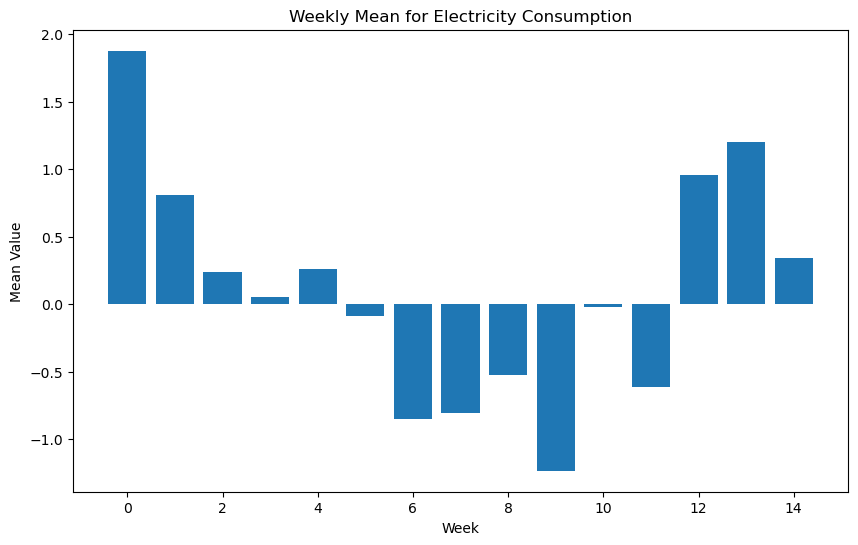

In [41]:
#Create a bar chart of the mean of the values of weeks 1-15
bar_chart(electricity_consumption_statistics.index[0:15],electricity_consumption_statistics['Weekly Mean'][0:15],'Weekly Mean for Electricity Consumption','Week','Mean Value')

There is a clear pattern that is similar to the trend that is observed for the trend of electricity consumption data. Earlier weeks and later weeks show an increase in amount of electricity used while there is a smaller amount of electricity that is used around the middle portion of the data.

#### Weekly Median for Electricity Consumption

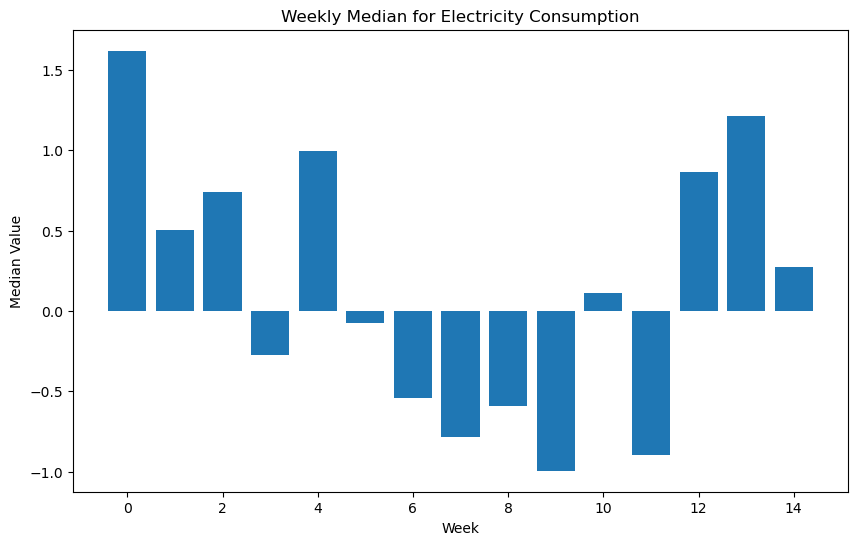

In [42]:
#Create a bar chart of the weekly median of weeks 1-15
bar_chart(electricity_consumption_statistics.index[0:15],electricity_consumption_statistics['Weekly Median'][0:15],'Weekly Median for Electricity Consumption','Week','Median Value')

The mean and the median seem to follow a simialr trend where the initial and end of the data is positive while the middle is negative. However there are certain weeks which have far different mean values vs median, such as week 4 which has a much higher median than the mean while implies that the variance is higher.

#### Weekly Variance for Electricity Consumption

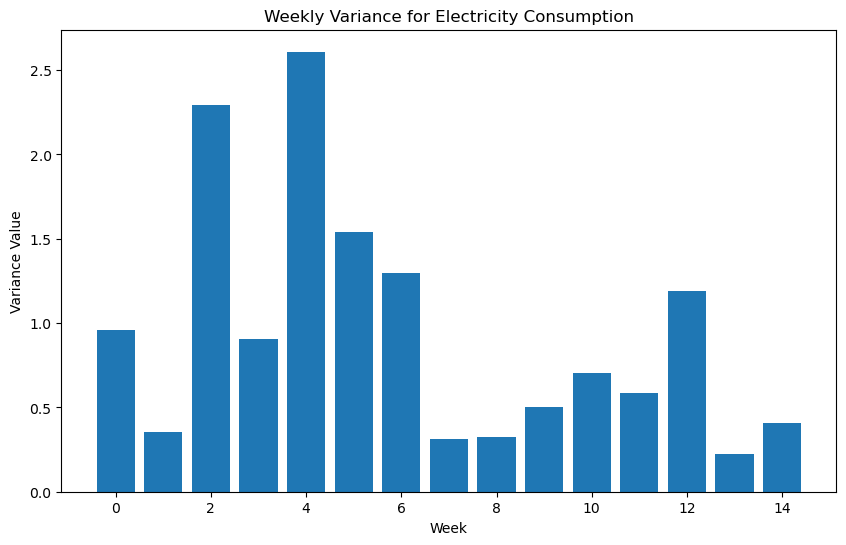

In [43]:
#Plot the bar chart for variance of the values (daily values) from weeks 1-15
bar_chart(electricity_consumption_statistics.index[0:15],electricity_consumption_statistics['Variance'][0:15],'Weekly Variance for Electricity Consumption','Week','Variance Value')

The variance has a positively skewed distribution. This means that if you were to look at the values across the weeks, the values in the earlier weeks have more oscillations in their values. This can be observed by looking at the residuals from the seasonal decomposition.

#### Weekly Standard Deviation for Electricity Consumption

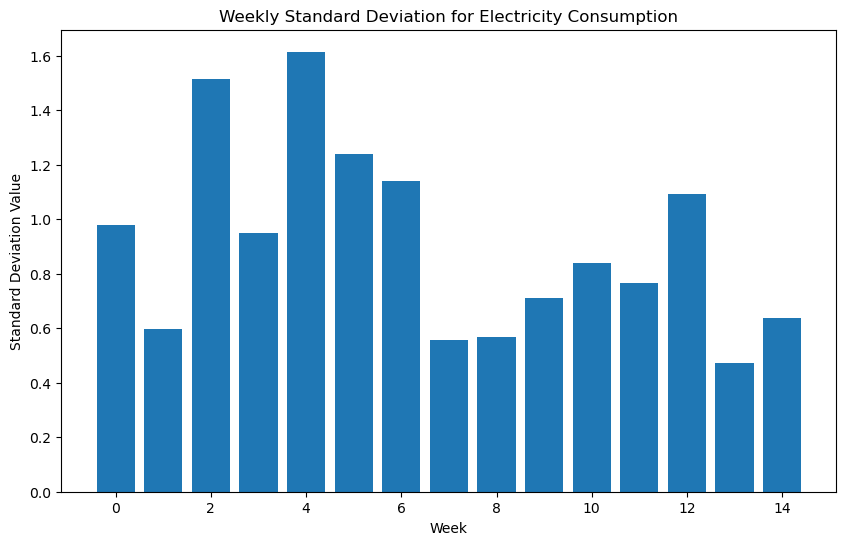

In [44]:
#Plot the standard deviation of the values (daily values) from weeks 1-15
bar_chart(electricity_consumption_statistics.index[0:15],electricity_consumption_statistics['Standard Deviation'][0:15],'Weekly Standard Deviation for Electricity Consumption','Week','Standard Deviation Value')

Standard deviation further proves that there is no clear pattern as the difference between higher and smaller values is flattened out. Standard deviation is preferred as it is experessed in the same units as the original data. 

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### Components of Box-Jenkins Models
- p: Autoregressive (AR) order for non-seasonal component.

- d: Differencing order for non-seasonal component.

- q: Moving average (MA) order for non-seasonal component.

- P: Autoregressive (AR) order for seasonal component.

- D: Differencing order for seasonal component.

- Q: Moving average (MA) order for seasonal component.

- s: Seasonal period (e.g., 12 for monthly data, 4 for quarterly data).

#### AIC Model Explanation
- Formulation: AIC is calculated as 2k - 2ln(L), where k is the number of paramters and ln(L) is the log of the likelihood model
- Purpose: AIC selets a model that is most accurate in underlying mechanisms that generates the observed data
- Penalty for complexity: It penalises the complexity based on the number of parameters
- Assumption: Does not require assumptions

#### BIC Model Explanation
- Formulation: BIC = ln(n)k - 2ln(L) where n is the same size and k is the number of parameters, and ln(L) is the log likelihood
- Purpose: aims to select the most true model based on certain assumptions
- Penalty: BIC places penalty on number of parameters in the model, more than in AIC
- Assumption: BIC is derived from Bayesian probability

AIC is focused on identifying models that closely represent the data while BIC is using assumptions to understand the true model.

#### q Order for Electricity Consumption

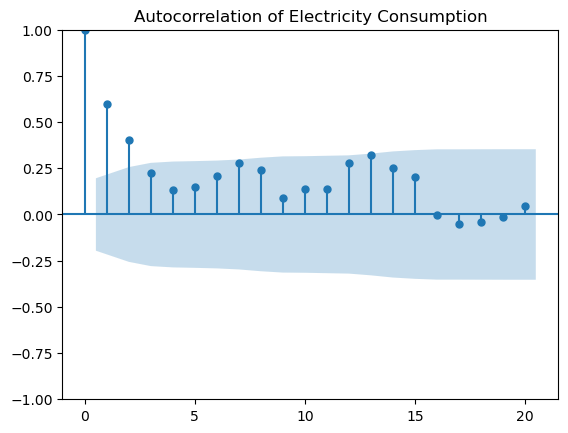

In [45]:
#Plot the ACF values
acf_values_electricity_consumption = plot_acf(electricity_consumption['Electricity Consumption'],lags=20,title='Autocorrelation of Electricity Consumption')

In [46]:
#Orders for q
q_orders_electricity_consumption = [1,2,7,13]

#### p Order for Electricity Consumption

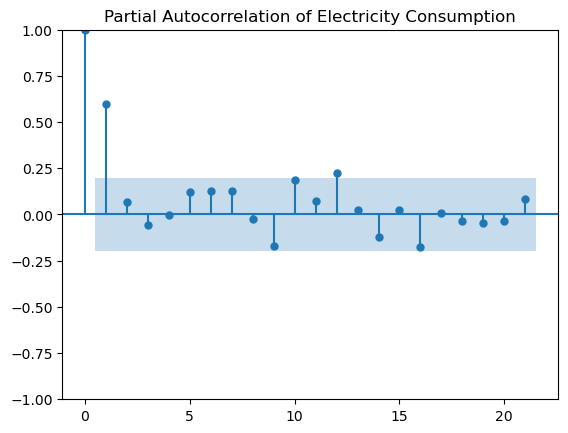

In [47]:
#Plot the PACF values
pacf_values_electricity_consumption = plot_pacf(electricity_consumption['Electricity Consumption'],lags=21,title='Partial Autocorrelation of Electricity Consumption')

In [48]:
#Potential AR (p) order
p_orders_electricity_consumption = [1,9,11]

#### d Order for Electricity Consumption

In [49]:
#Determine the stationarity of electricity consumption
adf_test(electricity_consumption['Electricity Consumption'])

ADF Statistic:  -4.978224856580164
P-Value:  2.450404893865566e-05
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


The ADF statistic shows that there is no need to difference the data as it is above the 99% confidence interval

In [50]:
#d order for stationarity
d_order_electricity_consumption = [0,1]

#### Removing Seasonality from data for P,D,Q
In trying to find the values for the SARIMA model, you have to remove the seasonality from original data. This creates seasonally adjusted data which is used for the sarima model. Once this has been done create an ACF and PACF plot and look for potential P,D,Q values.

In [51]:
#Create the series for electricity consumption that has removed the seasonality values from the original values
weekly_electricity_consumption_seasonal_removed = weekly_electricity_consumption_decomposition[0] - weekly_electricity_consumption_decomposition[2]
weekly_electricity_consumption_seasonal_removed

Day
2024-01-01    1.978450
2024-01-02    0.795224
2024-01-03    0.988383
2024-01-04    2.870932
2024-01-05    3.396079
                ...   
2024-04-05    1.233855
2024-04-06    0.935644
2024-04-07    2.869796
2024-04-08    1.390712
2024-04-09    0.503188
Length: 100, dtype: float64

#### Q Order for Electricity Consumption

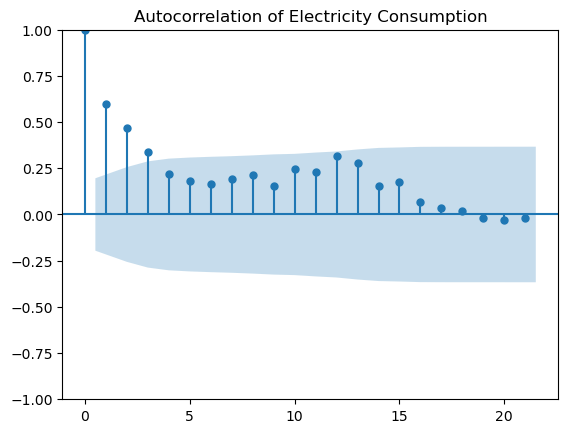

In [52]:
#Plot the new acf 
acf_values_electricity_consumption_seasonally_adjusted = plot_acf(weekly_electricity_consumption_seasonal_removed,lags=21, title='Autocorrelation of Electricity Consumption')

In [53]:
#Orders for Q
Q_orders_electricity_consumption = [1,2,3,12,13]

#### P Order for Electricity Consumption

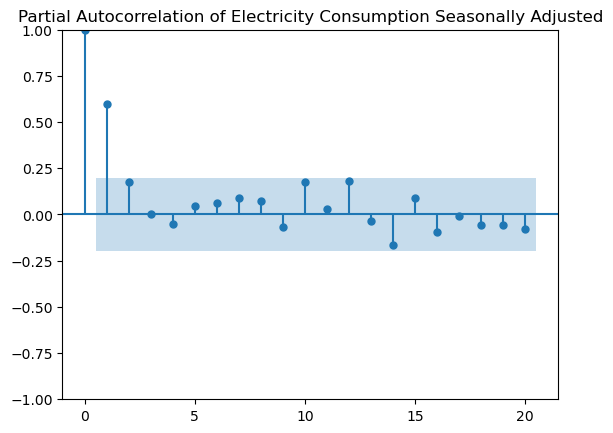

In [54]:
#Plot the PACF values
pacf_values_electricity_consumption_seasonally_adjusted = plot_pacf(weekly_electricity_consumption_seasonal_removed,lags=20,
                                                                    title='Partial Autocorrelation of Electricity Consumption Seasonally Adjusted')

In [55]:
#Orders for P
P_orders_electricity_consumption = [1,2,10,12,14]

#### D Order for Electricity Consumption

In [56]:
adf_test(weekly_electricity_consumption_seasonal_removed)

ADF Statistic:  -3.6626097320270086
P-Value:  0.00467090061942871
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


In [57]:
#D order
D_order_electricity_consumption = [0,1]

#### Parameters for Box Jenkins Models
- q: 1,2,7,13
- p: 1,9,11
- d: 0,1
- Q: 1,2,3,12,13
- P: 1,2,10,12,14
- D: 0,1
- s: 7

#### AR Model Selection

In [58]:
#Find the best AR model
#Returns p 
select_best_ar_model(electricity_consumption['Electricity Consumption'],p_orders_electricity_consumption)

{'best_aic': 289.0833594045243,
 'best_aic_model': 1,
 'best_bic': 296.89886996248856,
 'best_bic_model': 1}

#### MA Model Selection

In [59]:
#Find the best MA model
#Returns q
select_best_ma_model(electricity_consumption['Electricity Consumption'],q_orders_electricity_consumption)

{'best_aic': 294.6442220137474,
 'best_aic_model': 2,
 'best_bic': 305.06490275769977,
 'best_bic_model': 2}

#### ARMA Model Selection

In [60]:
#Find the ARMA 
#Returns p,q
select_best_arma_model(electricity_consumption['Electricity Consumption'],p_orders_electricity_consumption,q_orders_electricity_consumption)

{'best_aic': 284.58319475131304,
 'best_aic_model': (11, 1),
 'best_bic': 303.9486818228041,
 'best_bic_model': (1, 1)}

#### ARIMA Model Selection

In [61]:
#Find the ARIMA
#Returns p,d,q
select_best_arima(electricity_consumption['Electricity Consumption'],p_orders_electricity_consumption,q_orders_electricity_consumption,d_order_electricity_consumption)

{'best_aic': 285.5966269362885,
 'best_aic_model': (1, 1, 1),
 'best_bic': 293.38198648669226,
 'best_bic_model': (1, 1, 1)}

#### SARIMA Model Selection

In [62]:
#Find best SARIMA 
#Returns p,d,q
#Returns P,D,Q,s
select_best_sarima_model(electricity_consumption['Electricity Consumption'],p_orders_electricity_consumption,d_order_electricity_consumption,q_orders_electricity_consumption,P_orders_electricity_consumption,D_order_electricity_consumption,Q_orders_electricity_consumption,7)

{'aic': 285.714666551609,
 'bic': 293.5301771095733,
 'pdq': (1, 0, 0),
 'seasonal_pdq': (1, 0, 0, 7)}

#### Best Model Selection
##### AR Model
AIC : 289,
p : 1

BIC : 296.9,
p : 1

##### MA Model
AIC : 294.64,
q : 2

BIC : 305,
q : 2

##### ARMA Model
AIC : 284.58,
p : 11,
q : 1

BIC : 285.6,
p : 1,
q : 1

##### ARIMA Model
AIC : 285.59,
p : 1,
d : 1,
q : 1

BIC : 293.38,
p : 1,
d : 1,
q : 1

##### SARIMA Model
AIC : 285.71

BIC : 293.53

p : 1,
d : 0,
q : 0,
P : 1,
D : 0,
Q : 0,
s : 7

##### ARIMA was Best Model
SARIMA (1,0,0,1,0,0,7)

AIC : 285.59

## Stock Prices
The stock prices dataset includes a column that says daily stock prices. This is going to be the reason for using a weekly seasonality as there is not enough data values to look at seasonality for each day of the month (30) or year (365).

### Data Exploration
- Load the Data: Begin by loading each dataset from the Excel file.

- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components.

In [63]:
#Load in the stock prices dataset
stock_prices = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Stock Prices')

In [64]:
#Preprocess stock prices
#Remove the unnecessary column and create a datetime series which will be in the index
stock_prices['Day'] = pd.date_range('2024-01-01',periods=len(stock_prices))
stock_prices.drop(columns='Unnamed: 0',inplace=True)
stock_prices.set_index('Day',inplace=True)
stock_prices['Incrementing Day'] = range(1, len(stock_prices)+1)
stock_prices

Daily Stock Prices  Incrementing Day
Day                                             
2024-01-01            1.883151                 1
2024-01-02           -0.406184                 2
2024-01-03           -1.944365                 3
2024-01-04            0.334154                 4
2024-01-05           -0.688425                 5
...                        ...               ...
2024-04-05            0.090092                96
2024-04-06            0.686017                97
2024-04-07            1.209399                98
2024-04-08            2.574988                99
2024-04-09            2.418146               100

[100 rows x 2 columns]

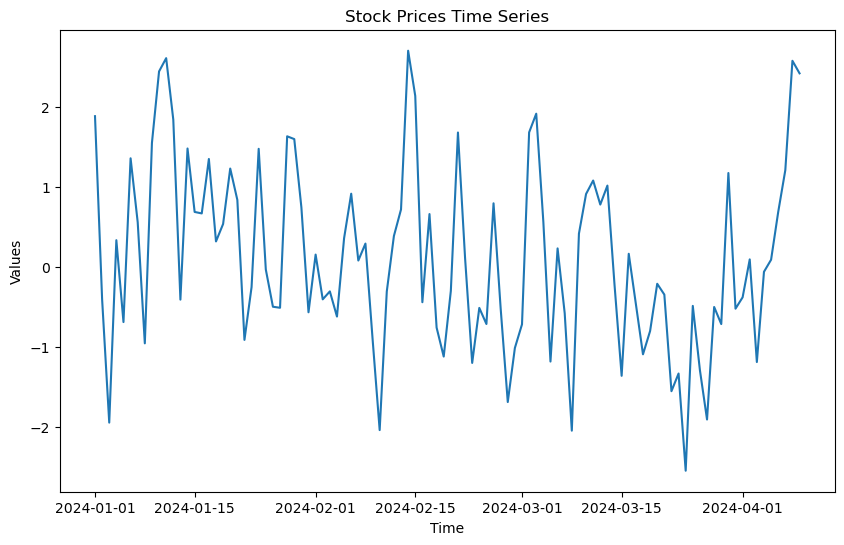

In [65]:
#Plot the time series of stock prices
time_series(stock_prices.index,stock_prices['Daily Stock Prices'],'Stock Prices Time Series','Time','Values')

#### Time Interval Decision
Stock prices are recorded always as daily. There is another factor in that weekend dates are usually not recorded so the lag is going to be 5. This is assuming that the weekend values have not been recorded as there are no NA values.

In [66]:
#Decompose the data into its individual parts, these can be accessed by indexing through the results
weekly_stock_prices_decomposition = decompose_seasonality(stock_prices['Daily Stock Prices'],5)

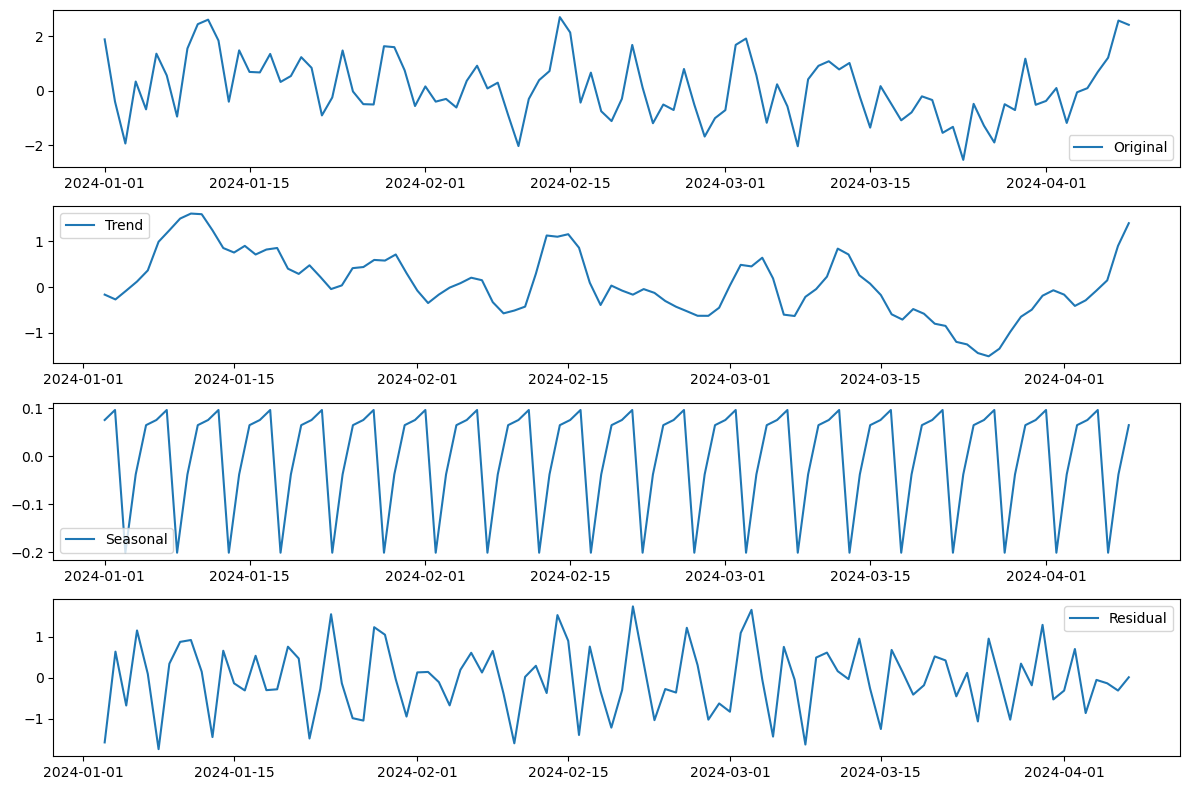

In [67]:
#Plot the stock prices seasonal decomposition
plot_seasonal_decomposition(stock_prices['Daily Stock Prices'],5)

#### Weekly seasonality decomposition
Trend - There seems to be some decreasing line, this can be explored with a line of best fit

Cycles - There are some periods of increases but nothing that is worth noticing.

Seasonality - It shows that there are values that are higher with one value that shrinks downwards to a much smaller value. However the seasonality values are quite small at -0.2 and +0.1.

Residual - The residual value has a mean around 0 with white noise fluctuations

#### Trend Decomposition of Stock Prices

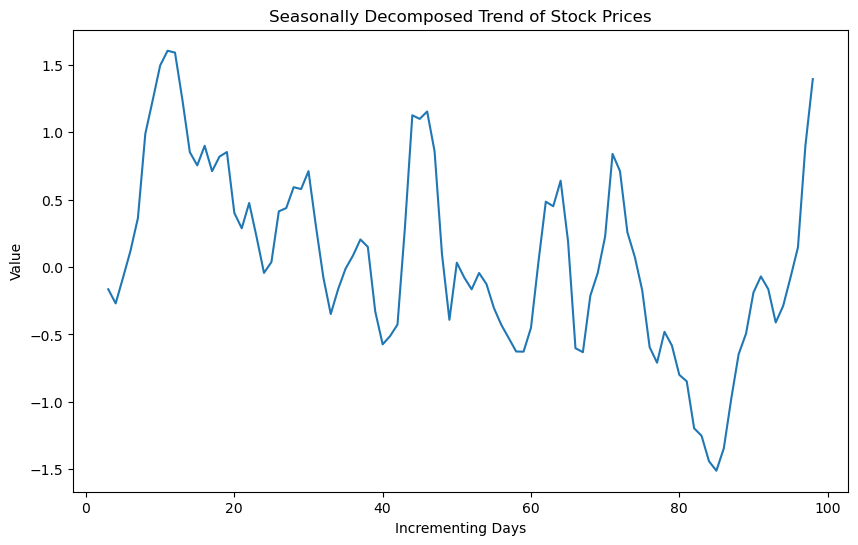

In [68]:
#Plot the line of best fit through the trend to see the downards trend
time_series(stock_prices['Incrementing Day'],weekly_stock_prices_decomposition[1],'Seasonally Decomposed Trend of Stock Prices','Incrementing Days','Value')

#### Line of Best Fit for Stock Prices

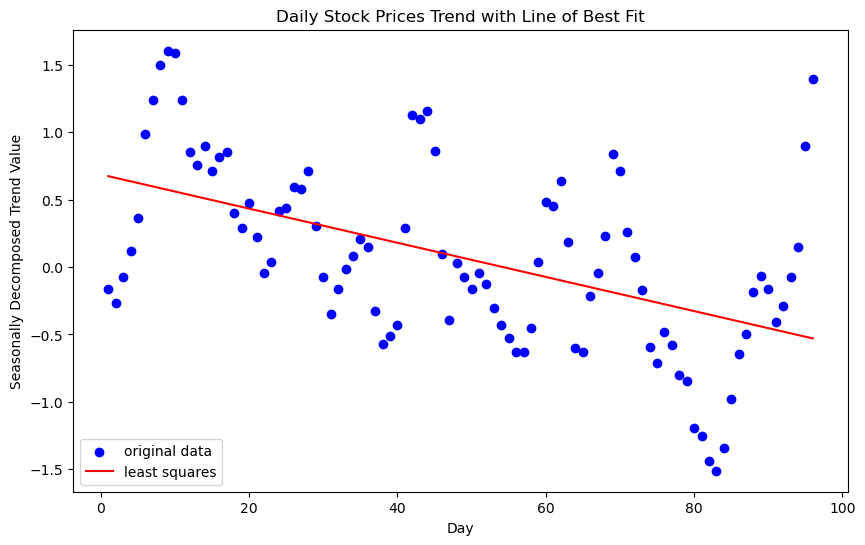

In [69]:
#Plot line of best fit against trend data
weekly_stock_prices_decomposition[1].dropna(inplace=True)
plot_least_squares_line(stock_prices['Incrementing Day'][0:96],weekly_stock_prices_decomposition[1],'Daily Stock Prices Trend with Line of Best Fit','Day','Seasonally Decomposed Trend Value')

#### Line of Best Fit of Trend after Decomposition
There is a clear decreasing trend, after the decomposition has taken place, this is suggesting that the stock price is decreasing overtime

#### Seasonality Decomposition of Stock Prices

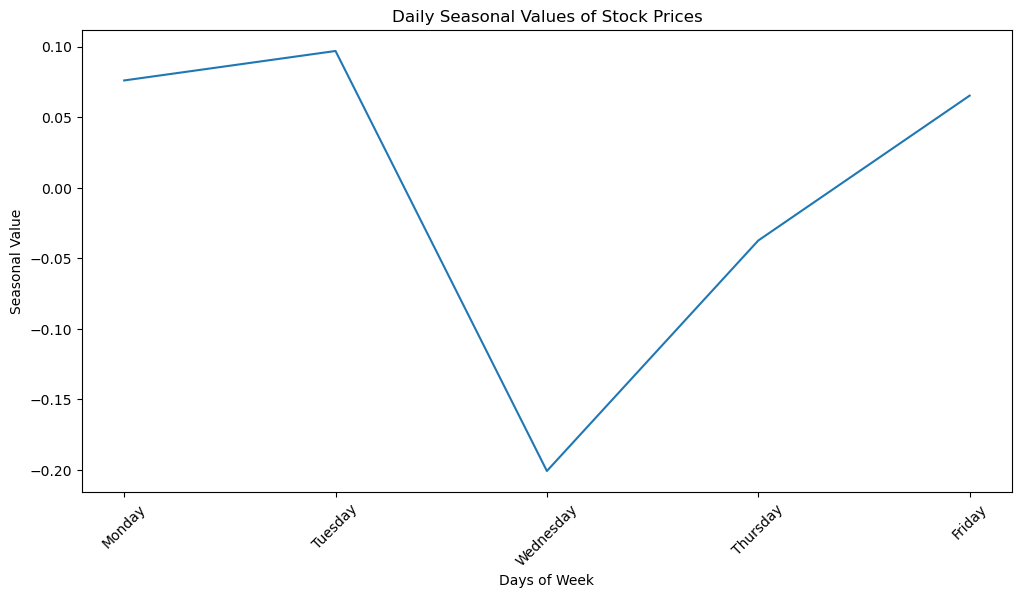

In [70]:
day_of_week_column = ['Monday','Tuesday','Wednesday','Thursday','Friday']
seasonal_values_plot(weekly_stock_prices_decomposition[2],5,'seasonal','Daily Seasonal Values of Stock Prices',
                     'Days of Week',day_of_week_column,'Seasonal Value')

#### Seasonal Values of Stock Prices
The value of the stock does not have too much dependence on the day of the week. This is established by the small seasonal values (0.3 total range). Wednesday has the biggest drop, while the other values are much higher relatively.

#### Mean Absolute Error for Daily Stock Prices

In [71]:
#MAE for Stock Prices
weekly_stock_prices_decomposition[3].dropna(inplace=True)
zeros_94 = np.zeros(len(weekly_stock_prices_decomposition[3]))
mean_absolute_error(zeros_94,weekly_stock_prices_decomposition[3])

0.6525406453688252

This mean absolute error is slightly higher than the value for electricity consumption which means that the residuals on average are further from the ideal residual line of 0.

### Preliminary Analysis
- Descriptive Statistics: Compute and interpret the mean, median, variance, and standard deviation for each dataset.

In [72]:
#Create a new dataframe that looks at the week day
stock_prices_weekly = create_week_day_data(electricity_consumption,'Electricity Consumption','Incrementing Day')
stock_prices_weekly

Monday   Tuesday Wednesday  Thursday    Friday
0   1.764052  1.282183   1.61983  3.050808  3.392962
1   0.719203   1.30969  0.503488  0.148525  0.484861
2   0.386474  1.647511  1.584793  0.914072  0.900899
3   0.784124  1.886141  0.737912  0.682024 -0.513084
4  -2.809532 -0.751147  0.488863 -0.497734  2.020888
5  -0.443922 -0.176202 -0.275285  1.395137  2.166927
6   1.238411  0.997368 -0.389102 -2.175347 -1.435586
7  -0.561444  0.949569  1.677164  0.451255 -0.076675
8  -1.086891 -1.963463 -2.688002  0.606775 -0.206265
9  -0.541207 -1.523399  0.015791 -1.606002 -1.015741
10 -1.403337 -0.314766 -0.668188 -1.514726 -0.785545
11  0.035559  0.084297   0.34462 -0.462012 -0.593747
12 -0.969334  -0.84422 -1.235256 -2.343911 -0.994529
13 -0.899046 -2.079721 -0.577078 -1.195838 -0.545973
14  0.456104  0.357035  1.317918 -0.575867  0.114408
15 -0.627606   -1.1846  -1.17115 -0.897127 -0.392398
16 -1.361349  0.220152  0.575738 -1.248374  0.864065
17  2.327922   2.34274  0.991445  -0.57503  0.766937
18 -0.019709  1.212591   0.81457  1.383924  1.048329
19  1.230737  0.625869  2.098805  1.176315  0.990147

#### Filling NaN values
There are no NaN values so there is no need to consider the options of replacing those missing values

#### Finding mean, standard deviation, median and variance

In [73]:
#Create mean, median, std and variance for days of week and each week
stock_prices_statistics = mean_median_variance_std_week_day(stock_prices_weekly,day_of_week_column)
stock_prices_statistics

Monday   Tuesday Wednesday  Thursday    Friday  \
0                   1.764052  1.282183   1.61983  3.050808  3.392962   
1                   0.719203   1.30969  0.503488  0.148525  0.484861   
2                   0.386474  1.647511  1.584793  0.914072  0.900899   
3                   0.784124  1.886141  0.737912  0.682024 -0.513084   
4                  -2.809532 -0.751147  0.488863 -0.497734  2.020888   
5                  -0.443922 -0.176202 -0.275285  1.395137  2.166927   
6                   1.238411  0.997368 -0.389102 -2.175347 -1.435586   
7                  -0.561444  0.949569  1.677164  0.451255 -0.076675   
8                  -1.086891 -1.963463 -2.688002  0.606775 -0.206265   
9                  -0.541207 -1.523399  0.015791 -1.606002 -1.015741   
10                 -1.403337 -0.314766 -0.668188 -1.514726 -0.785545   
11                  0.035559  0.084297   0.34462 -0.462012 -0.593747   
12                 -0.969334  -0.84422 -1.235256 -2.343911 -0.994529   
13                 -0.899046 -2.079721 -0.577078 -1.195838 -0.545973   
14                  0.456104  0.357035  1.317918 -0.575867  0.114408   
15                 -0.627606   -1.1846  -1.17115 -0.897127 -0.392398   
16                 -1.361349  0.220152  0.575738 -1.248374  0.864065   
17                  2.327922   2.34274  0.991445  -0.57503  0.766937   
18                 -0.019709  1.212591   0.81457  1.383924  1.048329   
19                  1.230737  0.625869  2.098805  1.176315  0.990147   
Mean               -0.089039  0.203881  0.288344 -0.164157  0.309544   
Median             -0.089039  0.220152  0.488863 -0.462012  0.114408   
Variance            1.369355  1.501976  1.272818  1.714741  1.366706   
Standard Deviation  1.183041  1.227552  1.120859  1.338846  1.163612   

                    Weekly Mean  Weekly Median  Standard Deviation  Variance  
0                      2.221967       1.764052            0.937237  0.878414  
1                      0.633153       0.503488            0.429760  0.184694  
2                      1.086750       0.914072            0.528499  0.279311  
3                      0.715423       0.737912            0.849434  0.721538  
4                     -0.309732      -0.497734            1.771210  3.137183  
5                      0.533331      -0.176202            1.175124  1.380916  
6                     -0.352851      -0.389102            1.487475  2.212582  
7                      0.487974       0.451255            0.873026  0.762174  
8                     -1.067569      -1.086891            1.320424  1.743518  
9                     -0.934112      -1.015741            0.682285  0.465512  
10                    -0.937313      -0.785545            0.508333  0.258403  
11                    -0.118257       0.035559            0.394715  0.155800  
12                    -1.277450      -0.994529            0.612737  0.375447  
13                    -1.059531      -0.899046            0.628813  0.395406  
14                     0.333920       0.357035            0.681838  0.464903  
15                    -0.854576      -0.897127            0.344989  0.119017  
16                    -0.189954       0.220152            1.043773  1.089462  
17                     1.170803       0.991445            1.220202  1.488893  
18                     0.887941       1.048329            0.549166  0.301583  
19                     1.224374       1.176315            0.543151  0.295013  
Mean                        NaN            NaN                 NaN       NaN  
Median                      NaN            NaN                 NaN       NaN  
Variance                    NaN            NaN                 NaN       NaN  
Standard Deviation          NaN            NaN                 NaN       NaN

The dataframe shows 19 weeks of Monday-Friday values. It follows the same format as per electricity consumption. Further analysis of the statistical data can be done to better understand. Again looking at mean, median, variance and standard deviation for the days of the week can be useful but understanding the overall data is going to be best to look at the incremental weeks.

#### Weekly Mean Value of Stock Prices

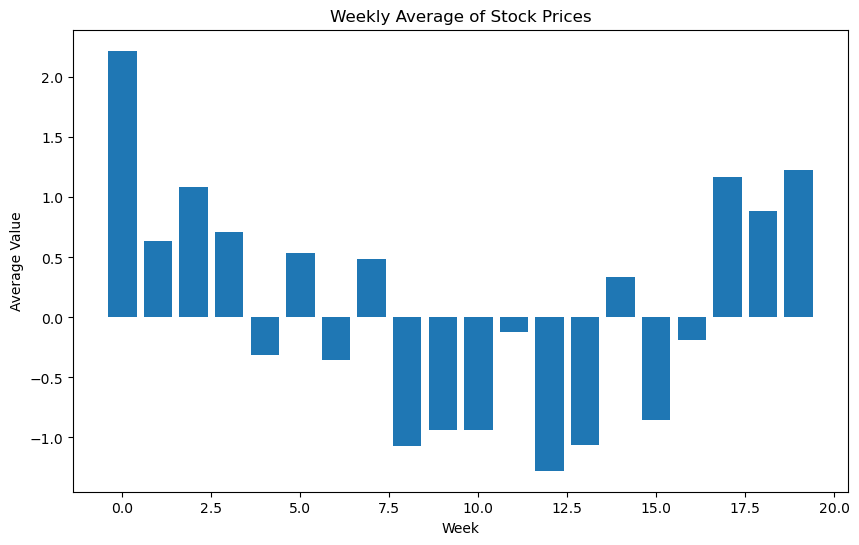

In [74]:
#Create the bar chart for weekly average of stock prices
bar_chart(stock_prices_statistics.index[0:20],stock_prices_statistics['Weekly Mean'][0:20],'Weekly Average of Stock Prices','Week','Average Value')

Similar to electricity consumption, this follows a similar trend to the line chart that is plot. As time goes on there is a movement from higher values to lower values before a sharp spike at the end of the data. However, this does prove that the dereasing trend can be observed by looking at average values and is not just the result of large fluctuations.

#### Weekly Median of Stock Prices

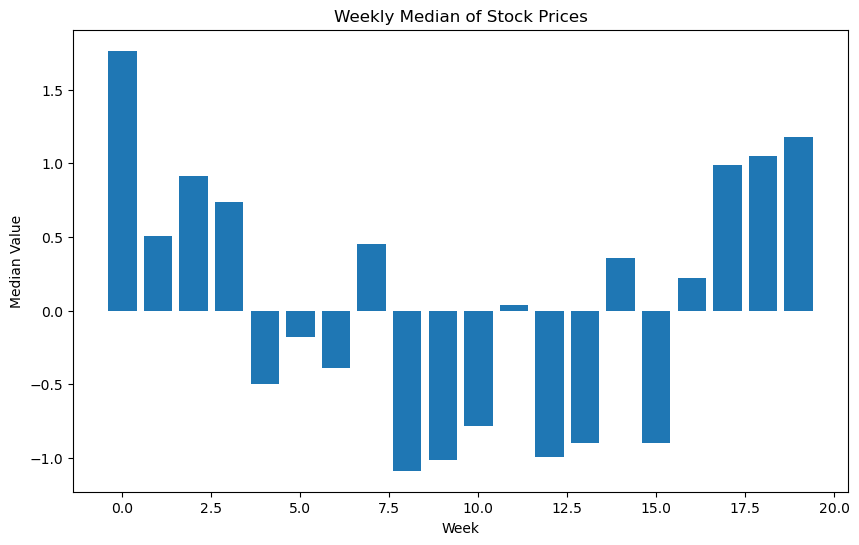

In [75]:
#Create the bar chart for median value of stock prices
bar_chart(stock_prices_statistics.index[0:20],stock_prices_statistics['Weekly Median'][0:20],'Weekly Median of Stock Prices','Week','Median Value')

The median displays a similar pattern to mean where the data starts high and decreases beofre a small return at the end of the data. This means that the spread across the days is quite small which is reflected in the seasonality being small.

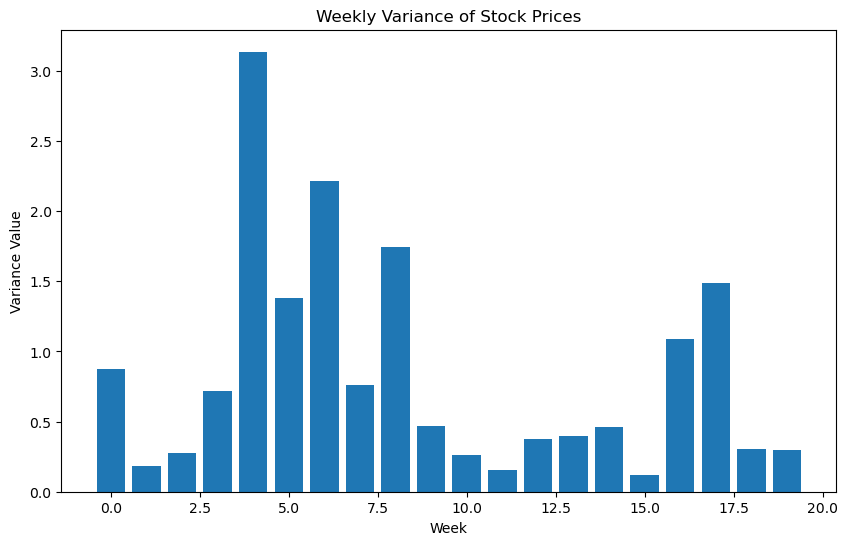

In [76]:
#Create the bar chart for variance of stock prices
bar_chart(stock_prices_statistics.index[0:20],stock_prices_statistics['Variance'][0:20],'Weekly Variance of Stock Prices','Week','Variance Value')

Variance is higher at the start of the stock prices and gets to be very small. This is presented by the residual values being higher at the start. As the higher the variance means that the model is going to be less accurate.

#### Standard Deviation of Stock Prices

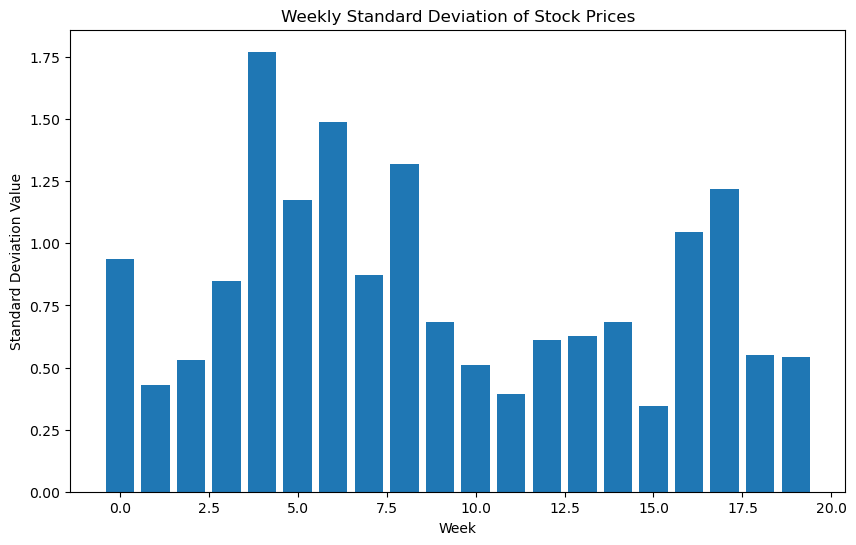

In [77]:
bar_chart(stock_prices_statistics.index[0:20],stock_prices_statistics['Standard Deviation'][0:20],'Weekly Standard Deviation of Stock Prices','Week','Standard Deviation Value')

The standard deviation gets the square root of the variance which shows a more symmetrical spread of where there is a greater distance from the mean. However it remains quite small which is reflected in a small MAE and seasonality not showing very high values

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### q Order for Stock Prices

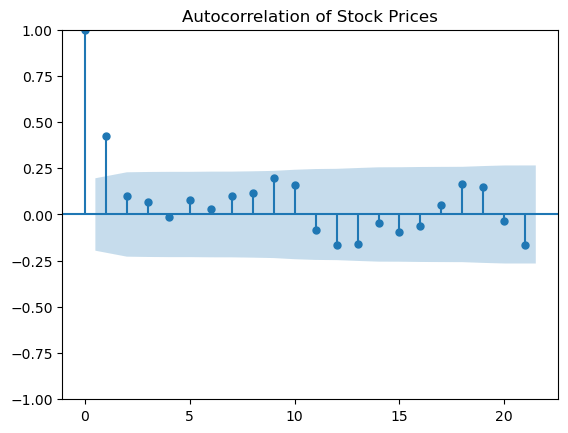

In [78]:
#Plot the ACF values
acf_values=plot_acf(stock_prices['Daily Stock Prices'],lags=21,title='Autocorrelation of Stock Prices')

In [79]:
#q Orders for Stock Prices
q_orders_stock_prices = [1,9,10]

#### p Order for Stock Prices

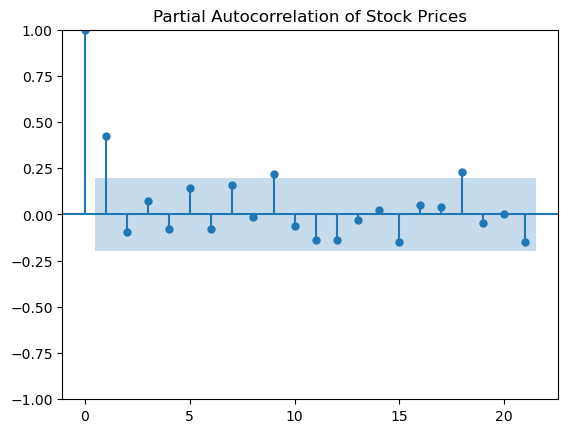

In [80]:
#Plot the PACF values
pacf_values_stock_prices=plot_pacf(stock_prices['Daily Stock Prices'],lags=21,title='Partial Autocorrelation of Stock Prices')

In [81]:
#p orders
p_orders_stock_prices = [1,17,9]

#### d Order for Stock Prices

In [82]:
#Test the stationarity of stock prices
adf_test(stock_prices['Daily Stock Prices'])

ADF Statistic:  -6.081858607650719
P-Value:  1.087386133417479e-07
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


In [83]:
#d orders
d_orders_stock_prices = [0,1]

#### Removing Seasonality from data for P,D,Q

In [84]:
#Create the new series which has seasonal components removed from the data
weekly_stock_prices_seasonally_removed = weekly_stock_prices_decomposition[0] - weekly_stock_prices_decomposition[2]
weekly_stock_prices_seasonally_removed

Day
2024-01-01    1.807161
2024-01-02   -0.503043
2024-01-03   -1.743689
2024-01-04    0.371561
2024-01-05   -0.753658
                ...   
2024-04-05    0.014103
2024-04-06    0.589158
2024-04-07    1.410075
2024-04-08    2.612395
2024-04-09    2.352913
Length: 100, dtype: float64

#### Q Order for Stock Prices

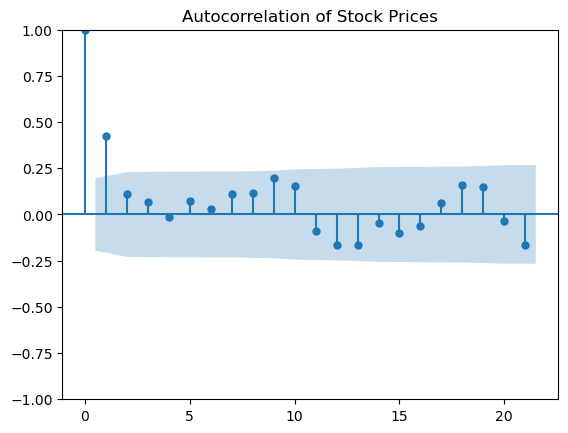

In [85]:
#Create acf plot of stock prices
acf_value_stock_prices_seasonally_removed = plot_acf(weekly_stock_prices_seasonally_removed, lags=21, title='Autocorrelation of Stock Prices')

In [86]:
#Q orders
Q_orders_stock_prices = [1,9]

#### P Orders for Stock Prices

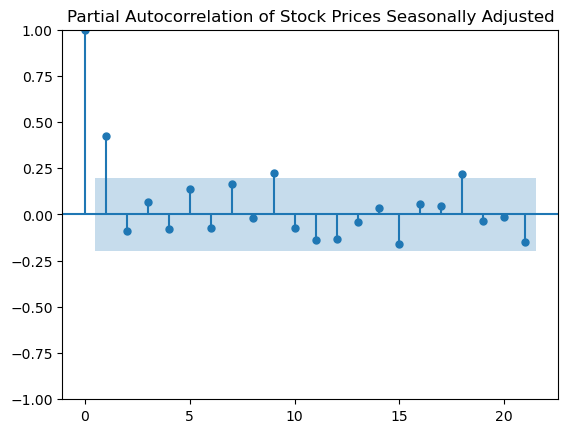

In [87]:
#Create a pacf plot of stock prices
pacf_value_stock_prices_seasonally_removed = plot_pacf(weekly_stock_prices_seasonally_removed,lags=21,title='Partial Autocorrelation of Stock Prices Seasonally Adjusted')

In [88]:
#P orders
P_orders_stock_prices = [1,5,7,9]

#### D Order for Stock Prices

In [89]:
#ADF test for stock prices
adf_test(weekly_stock_prices_seasonally_removed)

ADF Statistic:  -6.049144534378839
P-Value:  1.2901134480825736e-07
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


In [90]:
#Despite being above the stationarity allow for the model to look at the first difference
D_order_stock_prices = [0,1]

#### Parameters for Box Jenkins Models
- q: 1,9,10
- p: 1,17,9
- d: 0,1
- Q: 1,9
- P: 1,5,7,9
- D: 0,1
- s: 7

#### AR Model Selection

In [91]:
# Select Best AR Model
# Returns p
select_best_ar_model(stock_prices['Daily Stock Prices'],p_orders_stock_prices)

{'best_aic': 297.5218128829326,
 'best_aic_model': 1,
 'best_bic': 305.33732344089685,
 'best_bic_model': 1}

#### Select Best MA Model

In [92]:
#Find the best MA 
# Returns q
select_best_ma_model(stock_prices['Daily Stock Prices'],q_orders_stock_prices)

{'best_aic': 296.11780425159344,
 'best_aic_model': 1,
 'best_bic': 303.9333148095577,
 'best_bic_model': 1}

#### Select Best ARMA Model

In [93]:
#Find best ARMA  model
#Returns p,q
select_best_arma_model(stock_prices['Daily Stock Prices'],p_orders_stock_prices,q_orders_stock_prices)

{'best_aic': 301.8619194448323,
 'best_aic_model': (17, 1),
 'best_bic': 323.6405285319348,
 'best_bic_model': (1, 1)}

#### Select Best ARIMA Model

In [94]:
#Find best ARIMA model
#Returns p,d,q
select_best_arima(stock_prices['Daily Stock Prices'],p_orders_electricity_consumption,q_orders_electricity_consumption,d_orders_stock_prices)

{'best_aic': 290.46747819013325,
 'best_aic_model': (11, 0, 7),
 'best_bic': 306.4650621308442,
 'best_bic_model': (1, 1, 1)}

#### Select Best SARIMA Model

In [95]:
#Find the best SARIMA model
#Returns p,d,q,P,D,Q,s
select_best_sarima_model(stock_prices['Daily Stock Prices'],p_orders_stock_prices,d_orders_stock_prices,q_orders_stock_prices,P_orders_stock_prices,D_order_stock_prices,Q_orders_electricity_consumption,5)

{'aic': 292.80675940340893,
 'bic': 305.8326103333494,
 'pdq': (0, 0, 1),
 'seasonal_pdq': (3, 0, 0, 5)}

#### Best Model Selection
##### AR Model
AIC : 297.52, 
p : 1

BIC : 305.34,
p : 1
##### MA Model
AIC : 296.11,
q : 1

BIC : 303.93,
q : 1
##### ARMA Model
AIC : 301.86,
p : 17, 
q: 1

BIC : 323.64,
p : 1,
q : 1
##### ARIMA Model
AIC : 290.47,
p : 11, 
d : 0,
q : 7

BIC : 306.47,
p : 1,
d : 1,
q : 1
##### SARIMA Model
AIC : 292.8

BIC : 305.83

p : 0,
d : 0,
q : 1,
P : 3 ,
D : 0,
Q : 0,
s : 5

##### ARIMA was Best Model
ARIMA (11,0,7)

AIC 290.47


## Temperature Fluctuations
The temperature fluctuations data set includes a column that has normalised temperature data. Temperature fluctuations is going to be on a daily basis, assuming that these are the temperature records that were taken from the daily average on a given day.

### Data Exploration
- Load the Data: Begin by loading each dataset from the Excel file.

- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components.

In [96]:
#Load in temperature fluctuations data
temperature_fluctuations = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Temperature Fluctuations')
temperature_fluctuations

Unnamed: 0  Temperature Fluctuations
0            0                 -0.369182
1            1                 -0.608561
2            2                  0.675689
3            3                  1.542938
4            4                  1.739233
..         ...                       ...
95          95                  1.006569
96          96                  1.169455
97          97                  1.216544
98          98                  0.500300
99          99                  0.420481

[100 rows x 2 columns]

In [97]:
#Preprocess temperature fluctuations
temperature_fluctuations['Incrementing Day'] = range(1, len(temperature_fluctuations)+1)
temperature_fluctuations['Day'] = pd.date_range('2024-01-01',periods=len(temperature_fluctuations))
temperature_fluctuations.drop(columns='Unnamed: 0',inplace=True)
temperature_fluctuations.set_index('Day',inplace=True)
temperature_fluctuations

Temperature Fluctuations  Incrementing Day
Day                                                   
2024-01-01                 -0.369182                 1
2024-01-02                 -0.608561                 2
2024-01-03                  0.675689                 3
2024-01-04                  1.542938                 4
2024-01-05                  1.739233                 5
...                              ...               ...
2024-04-05                  1.006569                96
2024-04-06                  1.169455                97
2024-04-07                  1.216544                98
2024-04-08                  0.500300                99
2024-04-09                  0.420481               100

[100 rows x 2 columns]

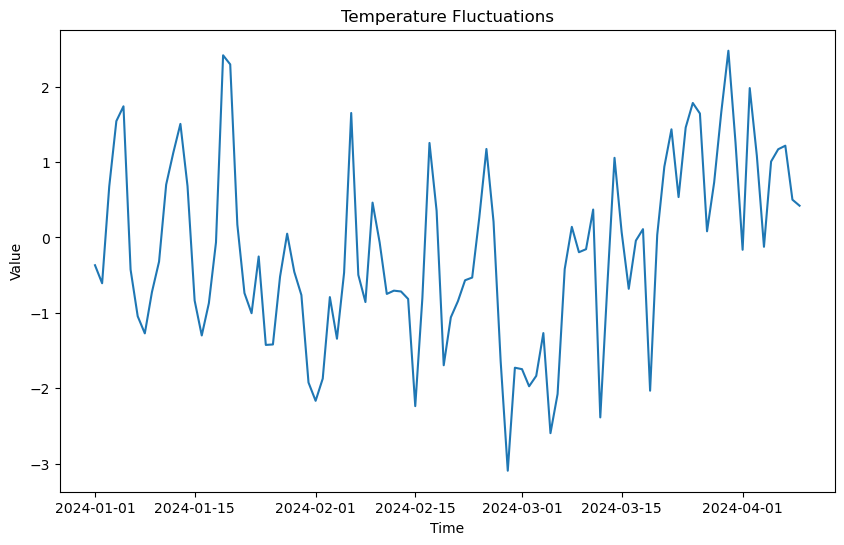

In [98]:
#Plot the time series
time_series(temperature_fluctuations.index,temperature_fluctuations['Temperature Fluctuations'],'Temperature Fluctuations','Time','Value')

#### Time Interval Decision

Temperature fluctuations are likely the daily temperatures over time. This is especially true as there is no clear overall pattern from looking at the graph, if it were weekly or monthly recordings you could expect to see a greater overall trend (likely upwards due to recent warmer temperatures across the globe)

In [99]:
#Daily temperature fluctuation data that has been decomposed
weekly_temperature_fluctuations_decomposition = decompose_seasonality(temperature_fluctuations['Temperature Fluctuations'],7)

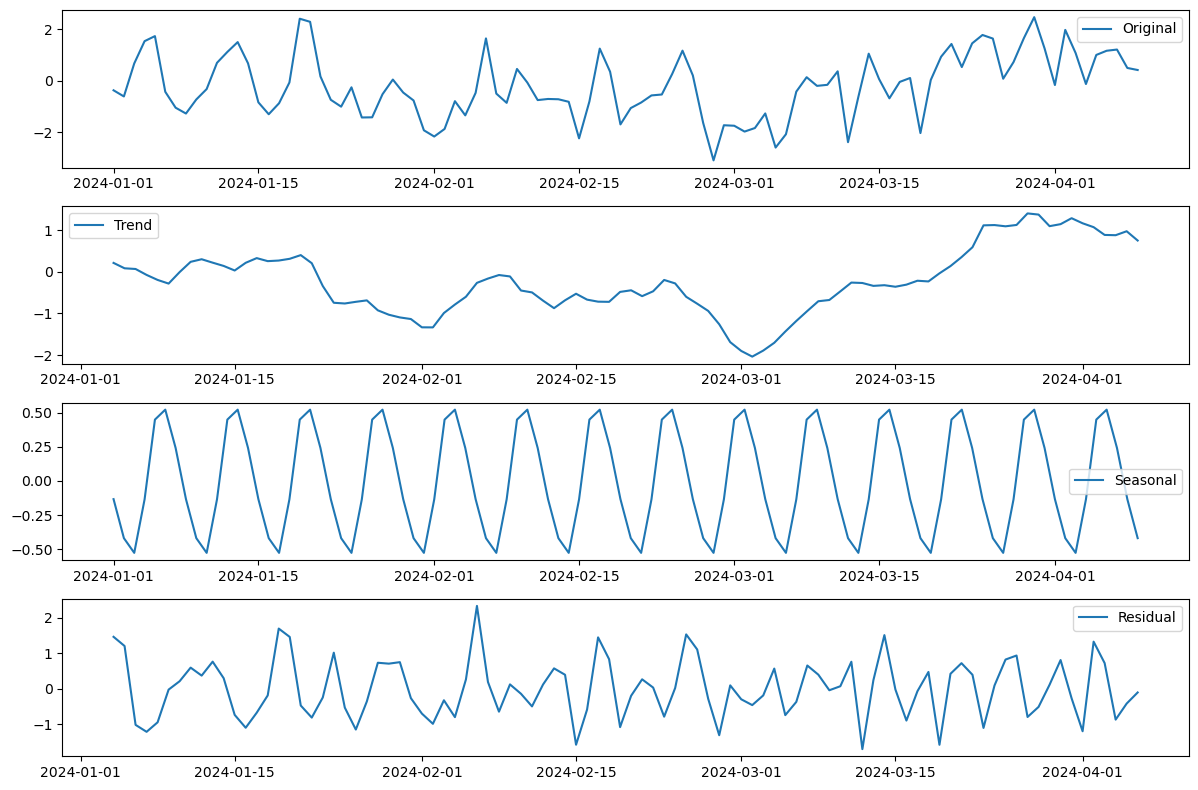

In [100]:
#Plot the temperature fluctuations seasonal decomposition
plot_seasonal_decomposition(temperature_fluctuations['Temperature Fluctuations'],7)

#### Weekly Seasonality Decomposition
Trend - The trend does not have any overall change in values

Cycles - There is a large dip in March of 2024 followed by an increase which remains constant as the data approaches April

Seasonal - There are days of the week which show higher values and lower values, these seasonal values are quite large

Residual - There is a residual value that is around the mean of 0

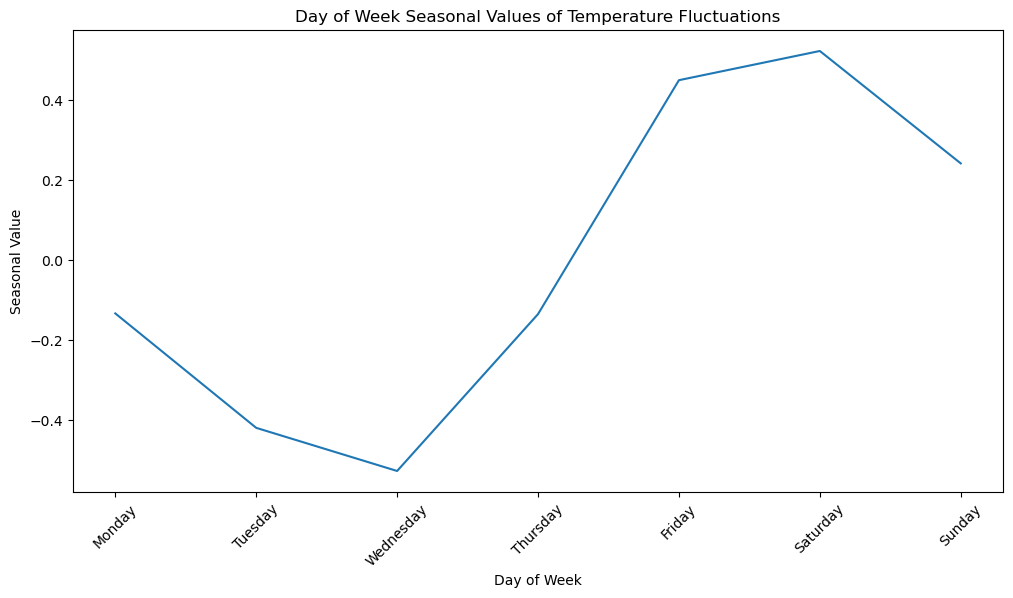

In [101]:
#Plot the seasonal values graph
seasonal_values_plot(weekly_temperature_fluctuations_decomposition[2],7,'seasonal','Day of Week Seasonal Values of Temperature Fluctuations',
                     'Day of Week',days_column,'Seasonal Value')

#### Seasonal Value of Temperature Fluctuations
The lower seasonal values are from Monday through Thursday while the values increase on Friday, Saturday and Sunday. This seems to be a great place to live where the weekend values are higher. If there was more data it could be appropriate to make the seasonality per month, however it would only result in 3 seasons in the data.

#### Mean Absolute Error for Temperature Fluctuations

In [102]:
#MAE for Temperature Fluctuations
weekly_temperature_fluctuations_decomposition[3].dropna(inplace=True)
zeros_96 = np.zeros(len(weekly_temperature_fluctuations_decomposition[3]))
mean_absolute_error(zeros_96,weekly_temperature_fluctuations_decomposition[3])

0.6695272777983745

This is a similar value to Daily Stock Prices which is a relatively low absolute error

### Preliminary Analysis
- Descriptive Statistics: Compute and interpret the mean, median, variance, and standard deviation for each dataset.

In [103]:
#Create a new data frame that has weekly data
#This is going to make it easier to draw statistics from the data based on its seasonality
temperature_fluctuations_weekly=create_weekly_data(temperature_fluctuations,'Temperature Fluctuations','Incrementing Day')
temperature_fluctuations_weekly

Monday   Tuesday Wednesday  Thursday    Friday  Saturday    Sunday
0  -0.369182 -0.608561  0.675689  1.542938  1.739233 -0.427274 -1.046441
1  -1.273415 -0.725798 -0.321087   0.70056  1.122588  1.506231   0.67986
2  -0.837726 -1.301136 -0.872613 -0.065665  2.416052  2.295423  0.170638
3  -0.738635 -1.005904 -0.253269 -1.426691 -1.420482 -0.522103  0.049383
4  -0.456534 -0.764847 -1.925445 -2.168073 -1.873558  -0.79216 -1.344237
5  -0.469012  1.650578 -0.497454 -0.857461  0.461307 -0.068329 -0.750155
6  -0.706594 -0.717528 -0.816672 -2.238847 -0.805094  1.253238  0.353064
7  -1.696575 -1.060435 -0.845473 -0.568677  -0.53269  0.265529  1.173283
8   0.208419 -1.641953 -3.095597 -1.728888 -1.748114 -1.975303 -1.837374
9  -1.269411 -2.597269 -2.077996 -0.420718  0.140009 -0.196671 -0.156378
10  0.369557 -2.388291  -0.62453  1.055785   0.07053 -0.681892 -0.042681
11  0.109426 -2.034023  0.032139  0.937775   1.43379  0.534932  1.457818
12  1.783441  1.643736  0.081037  0.729037  1.659909   2.47671  1.261191
13 -0.164476  1.981165  1.082525 -0.124695  1.006569  1.169455  1.216544
14    0.5003  0.420481       NaN       NaN       NaN       NaN       NaN

#### Filling NaN Values
As there are missing values in row 14 and there is no overall change in average values, taking the average values of weeks 1-14 would be a good value to implement into the dataframe

In [104]:
#Use the days replace function to fill in for week 14 as there is no general trend so the mean value would be appropriate to fill the NaN
missing_values_replace(days_replace,temperature_fluctuations_weekly,0,14)

Monday   Tuesday Wednesday  Thursday    Friday  Saturday    Sunday
0  -0.369182 -0.608561  0.675689  1.542938  1.739233 -0.427274 -1.046441
1  -1.273415 -0.725798 -0.321087   0.70056  1.122588  1.506231   0.67986
2  -0.837726 -1.301136 -0.872613 -0.065665  2.416052  2.295423  0.170638
3  -0.738635 -1.005904 -0.253269 -1.426691 -1.420482 -0.522103  0.049383
4  -0.456534 -0.764847 -1.925445 -2.168073 -1.873558  -0.79216 -1.344237
5  -0.469012  1.650578 -0.497454 -0.857461  0.461307 -0.068329 -0.750155
6  -0.706594 -0.717528 -0.816672 -2.238847 -0.805094  1.253238  0.353064
7  -1.696575 -1.060435 -0.845473 -0.568677  -0.53269  0.265529  1.173283
8   0.208419 -1.641953 -3.095597 -1.728888 -1.748114 -1.975303 -1.837374
9  -1.269411 -2.597269 -2.077996 -0.420718  0.140009 -0.196671 -0.156378
10  0.369557 -2.388291  -0.62453  1.055785   0.07053 -0.681892 -0.042681
11  0.109426 -2.034023  0.032139  0.937775   1.43379  0.534932  1.457818
12  1.783441  1.643736  0.081037  0.729037  1.659909   2.47671  1.261191
13 -0.164476  1.981165  1.082525 -0.124695  1.006569  1.169455  1.216544
14    0.5003  0.420481 -0.675625 -0.330973  0.262146  0.345556  0.084608

#### Finding mean, standard deviation, median and variance

In [105]:
#Create the statistical table using the function that has been used previously
temperature_fluctuations_statistics = mean_median_variance_std_weekly(temperature_fluctuations_weekly,days_column)
temperature_fluctuations_statistics

Monday   Tuesday Wednesday  Thursday    Friday  \
0                  -0.369182 -0.608561  0.675689  1.542938  1.739233   
1                  -1.273415 -0.725798 -0.321087   0.70056  1.122588   
2                  -0.837726 -1.301136 -0.872613 -0.065665  2.416052   
3                  -0.738635 -1.005904 -0.253269 -1.426691 -1.420482   
4                  -0.456534 -0.764847 -1.925445 -2.168073 -1.873558   
5                  -0.469012  1.650578 -0.497454 -0.857461  0.461307   
6                  -0.706594 -0.717528 -0.816672 -2.238847 -0.805094   
7                  -1.696575 -1.060435 -0.845473 -0.568677  -0.53269   
8                   0.208419 -1.641953 -3.095597 -1.728888 -1.748114   
9                  -1.269411 -2.597269 -2.077996 -0.420718  0.140009   
10                  0.369557 -2.388291  -0.62453  1.055785   0.07053   
11                  0.109426 -2.034023  0.032139  0.937775   1.43379   
12                  1.783441  1.643736  0.081037  0.729037  1.659909   
13                 -0.164476  1.981165  1.082525 -0.124695  1.006569   
14                    0.5003  0.420481 -0.675625 -0.330973  0.262146   
Mean               -0.334028 -0.609986 -0.675625 -0.330973  0.262146   
Median             -0.412858 -0.745323 -0.650077 -0.330973  0.262146   
Variance            0.650307  1.817087  0.987635  1.241026  1.546112   
Standard Deviation  0.816328  1.428149   1.04065  1.142503  1.243685   

                    Saturday    Sunday  Weekly Mean  Weekly Median  \
0                  -0.427274 -1.046441     0.215200      -0.369182   
1                   1.506231   0.67986     0.241277       0.679860   
2                   2.295423  0.170638     0.257854      -0.065665   
3                  -0.522103  0.049383    -0.759672      -0.738635   
4                   -0.79216 -1.344237    -1.332122      -1.344237   
5                  -0.068329 -0.750155    -0.075789      -0.469012   
6                   1.253238  0.353064    -0.525490      -0.717528   
7                   0.265529  1.173283    -0.466434      -0.568677   
8                  -1.975303 -1.837374    -1.688401      -1.748114   
9                  -0.196671 -0.156378    -0.939776      -0.420718   
10                 -0.681892 -0.042681    -0.320217      -0.042681   
11                  0.534932  1.457818     0.353122       0.534932   
12                   2.47671  1.261191     1.376437       1.643736   
13                  1.169455  1.216544     0.881013       1.082525   
14                  0.345556  0.084608     0.086642       0.262146   
Mean                0.345556  0.084608          NaN            NaN   
Median              0.305543  0.084608          NaN            NaN   
Variance             1.29933  0.872348          NaN            NaN   
Standard Deviation  1.128577  0.924937          NaN            NaN   

                    Standard Deviation  Variance  
0                             1.104703  1.220368  
1                             1.026799  1.054315  
2                             1.518249  2.305080  
3                             0.564226  0.318351  
4                             0.673815  0.454027  
5                             0.881956  0.777846  
6                             1.088115  1.183994  
7                             0.935329  0.874840  
8                             0.973824  0.948332  
9                             1.060877  1.125460  
10                            1.087752  1.183204  
11                            1.198885  1.437325  
12                            0.778731  0.606421  
13                            0.771036  0.594497  
14                            0.435097  0.189309  
Mean                               NaN       NaN  
Median                             NaN       NaN  
Variance                           NaN       NaN  
Standard Deviation                 NaN       NaN

The dataframe includes the 14 weeks of data that take place in measuring temperature fluctuations. Once again the statistical data that is applicable to this problem is the weekly mean, median standard deviation and variance columns.

#### Weekly Mean for Temperature Fluctuations

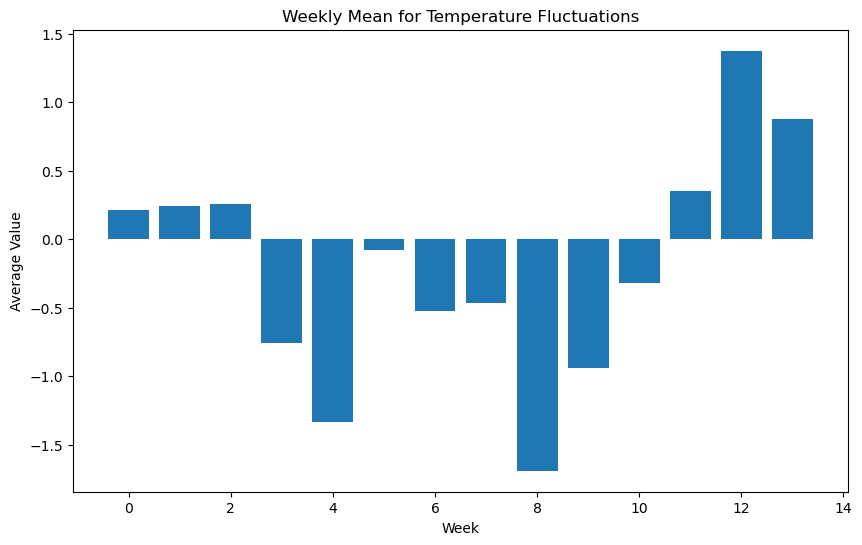

In [106]:
#Bar chart of weekly average temperature fluctuations
bar_chart(temperature_fluctuations_statistics.index[0:14],temperature_fluctuations_statistics['Weekly Mean'][0:14],'Weekly Mean for Temperature Fluctuations','Week','Average Value')

You can see the sinusodial pattern that is followed by looking at the mean value. This is from the high that takes place around week 12 with high values up until week 3. This is coupled with a period of lower values from week 4-11 which is the downturn of the sinusoidal pattern.

#### Weekly Median for Temperature Fluctuations

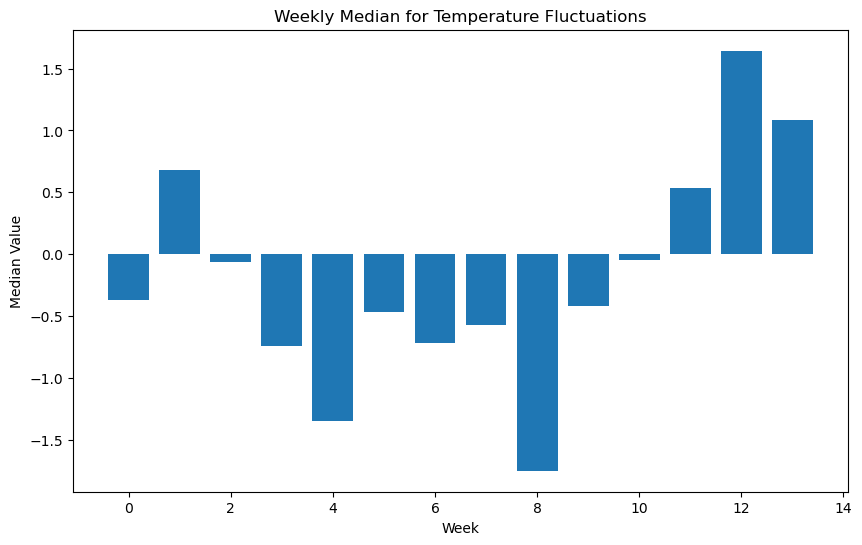

In [107]:
#Create a weekly median of temperature fluctuations graph
bar_chart(temperature_fluctuations_statistics.index[0:14],temperature_fluctuations_statistics['Weekly Median'][0:14],'Weekly Median for Temperature Fluctuations','Week','Median Value')

The median value follows an extremely similar pattern after week 3 but before that it is quite different. This might be reflected in the variance.

#### Weekly Variance for Temperature Fluctuations

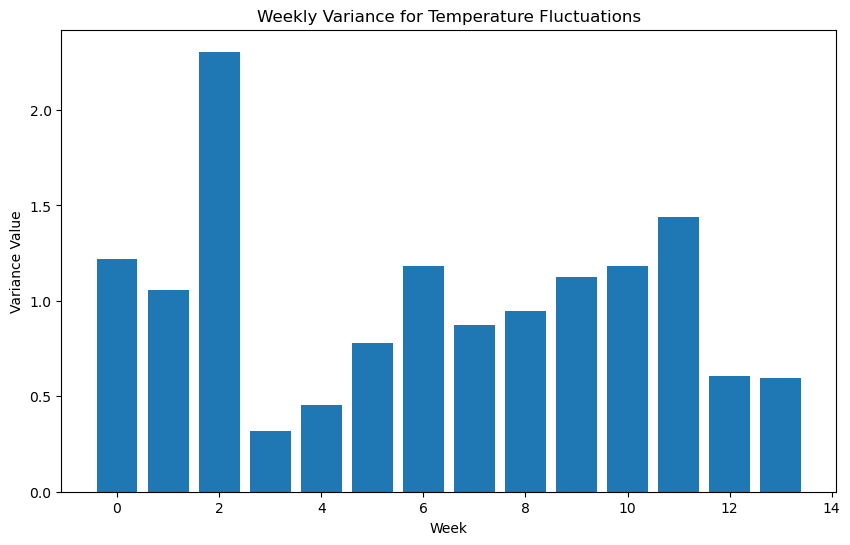

In [108]:
#Create a weekly variance of temperature fluctuations graph
bar_chart(temperature_fluctuations_statistics.index[0:14],temperature_fluctuations_statistics['Variance'][0:14],'Weekly Variance for Temperature Fluctuations','Week','Variance Value')

As predicted this does make a difference in the variance as weeks 1-3 have a much higher variance compared to the other values, especially week 3.

#### Weekly Standard Deviation for Temperature Fluctuations

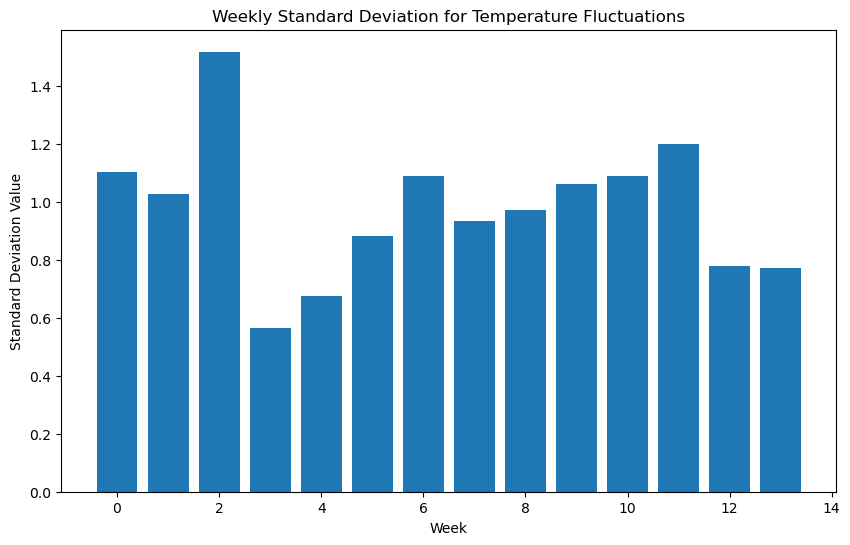

In [109]:
#Create a weekly standard deviation of temperature fluctuations graph
bar_chart(temperature_fluctuations_statistics.index[0:14],temperature_fluctuations_statistics['Standard Deviation'][0:14],'Weekly Standard Deviation for Temperature Fluctuations','Week','Standard Deviation Value')

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### q Order for Temperature Fluctuations

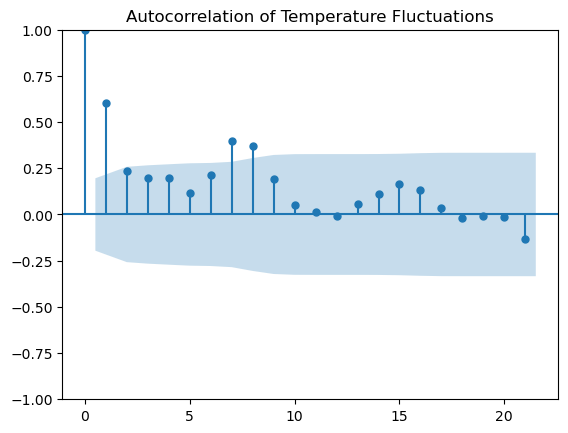

In [110]:
#Plot the ACF values
acf_values_temperature_fluctuations = plot_acf(temperature_fluctuations['Temperature Fluctuations'],lags=21,title='Autocorrelation of Temperature Fluctuations')

In [111]:
#List potential ma (q) orders
q_temperature_fluctuations = [1,7,8]

#### p Order for Temperature Fluctuation

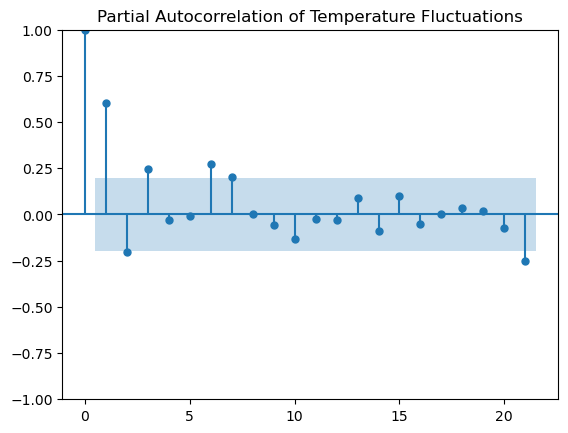

In [112]:
#Plot the PACF Values
pacf_values = plot_pacf(temperature_fluctuations['Temperature Fluctuations'],lags=21,title='Partial Autocorrelation of Temperature Fluctuations')

In [113]:
#List potential ar (p) orders
p_temperature_fluctuations = [1,2,3,6,7]

#### d Order for Temperature Fluctuation

In [114]:
#Check the stationarity of temperature fluctuations
adf_test(temperature_fluctuations['Temperature Fluctuations'])

ADF Statistic:  -1.5400991438956082
P-Value:  0.5135899098620552
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


As this is not stationary, take the first difference of the data and then recheck the ADF test

In [115]:
#Create a new column that takes the first difference of temperature fluctuations
temperature_fluctuations['First Difference'] = temperature_fluctuations['Temperature Fluctuations'].diff()
temperature_fluctuations = temperature_fluctuations[1::]
adf_test(temperature_fluctuations['First Difference'])

ADF Statistic:  -7.86588692238614
P-Value:  5.136316200920877e-12
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


As this is now below the threshold, it is considered stationary which can now be used in the ARIMA model.

In [116]:
#List the potential i (d) orders
d_orders_temperature_fluctuations = [1,2]

#### Removing Seasonality from Data for P,D,Q

We are trying to find the values for the SARIMA model. In order to do this, we have to remove the seasonality from the original data. This creates seasonally adjusted data which is used for the SARIMA model. 

In [117]:
#Create the new series which has seasonal components removed from the data
weekly_temperature_fluctuations_seasonal_removed = weekly_temperature_fluctuations_decomposition[0] - weekly_temperature_fluctuations_decomposition[2]
weekly_temperature_fluctuations_seasonal_removed

Day
2024-01-01   -0.236081
2024-01-02   -0.189652
2024-01-03    1.202355
2024-01-04    1.677718
2024-01-05    1.289765
                ...   
2024-04-05    0.557102
2024-04-06    0.647079
2024-04-07    0.974932
2024-04-08    0.633401
2024-04-09    0.839390
Length: 100, dtype: float64

#### Q order for Temperature Fluctuations

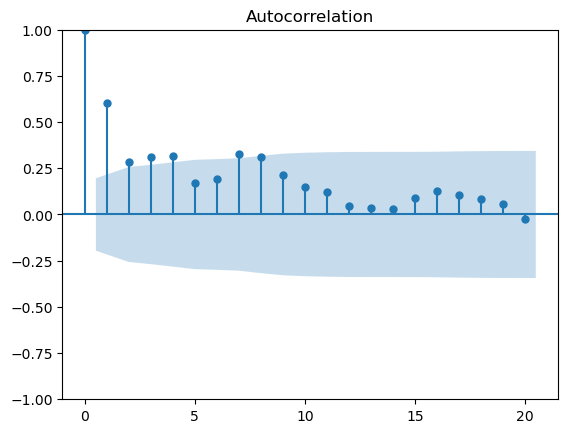

In [118]:
#Plot the new acf
acf_values_temperature_fluctuations_seasonally_adjusted = plot_acf(weekly_temperature_fluctuations_seasonal_removed)

In [119]:
#Orders for Q
Q_orders_temperature_fluctuations = [1,2,3,4,7,8]

#### P order for Temperature Fluctuations

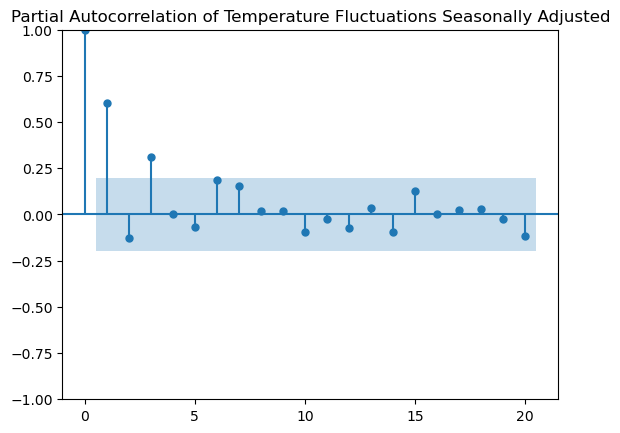

In [120]:
#Plot the PACF values
pacf_values_temperature_fluctuations_seasonally_adjusted = plot_pacf(weekly_temperature_fluctuations_seasonal_removed, lags = 20, title = 'Partial Autocorrelation of Temperature Fluctuations Seasonally Adjusted')

In [121]:
#Orders for P
P_orders_temperature_fluctuations = [1,3,6]

#### D order for Temperature Fluctuations

In [122]:
#ADF test for temperature fluctuations
adf_test(weekly_temperature_fluctuations_seasonal_removed)

ADF Statistic:  -3.0580656215215885
P-Value:  0.029816220695146455
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


In [123]:
D_order_temperature_fluctuations = [0,1]

#### Parameters for Box Jenkins Models
- q: 1,7,8
- p: 1,2,3,6,7
- d: 1,2
- Q: 1,2,3,4,7,8
- P: 1,3,6
- D: 0,1
- s: 7 

#### AR Model Selection

In [124]:
# Find the best AR model
# Returns p
select_best_ar_model(temperature_fluctuations['Temperature Fluctuations'],p_temperature_fluctuations)

{'best_aic': 271.4686143349624,
 'best_aic_model': 7,
 'best_bic': 289.0746822099516,
 'best_bic_model': 3}

#### MA Model Selection

In [125]:
# Find the best MA model
# Returns q
select_best_ma_model(temperature_fluctuations['Temperature Fluctuations'],q_temperature_fluctuations)

{'best_aic': 274.2621941817288,
 'best_aic_model': 8,
 'best_bic': 287.5314239361821,
 'best_bic_model': 1}

#### ARMA Model Selection

In [126]:
# Find the ARMA
# Returns p,q
select_best_arma_model(temperature_fluctuations['Temperature Fluctuations'],p_temperature_fluctuations, q_temperature_fluctuations)

{'best_aic': 268.6012616519961,
 'best_aic_model': (6, 1),
 'best_bic': 286.6960340026901,
 'best_bic_model': (6, 1)}

#### ARIMA Model Selection

In [127]:
# Find the ARIMA
# Returns p,d,qar_orders_temperature_fluctuations, ma_orders_temperature_fluctuations, i_orders_temperature_fluctuations
select_best_arima(temperature_fluctuations['Temperature Fluctuations'],p_temperature_fluctuations, q_temperature_fluctuations, d_orders_temperature_fluctuations)

{'best_aic': 268.05891876645956,
 'best_aic_model': (2, 1, 8),
 'best_bic': 284.4590122033004,
 'best_bic_model': (2, 1, 1)}

#### SARIMA Model Selection

In [128]:
#Find best SARIMA 
#Returns p,d,q
#Returns P,D,Q,s
select_best_sarima_model(electricity_consumption['Electricity Consumption'],p_temperature_fluctuations,d_orders_temperature_fluctuations,q_temperature_fluctuations,P_orders_temperature_fluctuations,D_order_temperature_fluctuations,Q_orders_temperature_fluctuations,7)

{'aic': 285.0722283367739,
 'bic': 295.45270773731227,
 'pdq': (1, 1, 1),
 'seasonal_pdq': (1, 0, 0, 7)}

#### Best Model Selection
##### AR Model
AIC : 271.47
p : 7

BIC : 289.07
p : 3
##### MA Model
AIC : 274.26
q : 8

BIC : 287.53
q : 1
##### ARMA Model
AIC : 267.70
p : 6,
q : 1

BIC : 286.69
p : 6,
q : 1
##### ARIMA Model
AIC : 267.70
p : 2,
d : 0,
q : 7

BIC : 284.50
p : 2,
d : 1,
q : 1

##### SARIMA Model
AIC :  285.71

BIC : 293.53

p : 1,
d : 0,
q : 0,
P : 1,
D : 0,
Q : 0,
s : 7

##### The Best Model is ARMA/ARIMA
ARMA (6,1)
AIC : 267.70

ARIMA (2,0,7)
AIC : 267.70

## Advertising Impact
The adveritisng impact dataset includes a column called Advertising Impact. This is likely going to look at a performance metric of sales and seeing how much a marketing technique helped with that performance mectric

### Data Exploration
- Load the Data: Begin by loading each dataset from the Excel file.

- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components.

In [129]:
#load in the advertising imapct data
advertising_impact = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Advertising Impact')
advertising_impact

Unnamed: 0  Advertising Impact
0            0           -1.306527
1            1           -0.954923
2            2           -0.068220
3            3           -0.364128
4            4           -0.185789
..         ...                 ...
95          95          -69.300932
96          96          -69.789283
97          97          -68.463394
98          98          -65.763320
99          99          -62.827442

[100 rows x 2 columns]

In [130]:
#Preprocess the data
advertising_impact.drop(columns='Unnamed: 0',inplace=True)
advertising_impact['Incrementing Day'] = range(1, len(advertising_impact)+1)
advertising_impact['Day'] = pd.date_range('2024-01-01',periods=len(advertising_impact))
advertising_impact.set_index('Day',inplace=True)
advertising_impact

Advertising Impact  Incrementing Day
Day                                             
2024-01-01           -1.306527                 1
2024-01-02           -0.954923                 2
2024-01-03           -0.068220                 3
2024-01-04           -0.364128                 4
2024-01-05           -0.185789                 5
...                        ...               ...
2024-04-05          -69.300932                96
2024-04-06          -69.789283                97
2024-04-07          -68.463394                98
2024-04-08          -65.763320                99
2024-04-09          -62.827442               100

[100 rows x 2 columns]

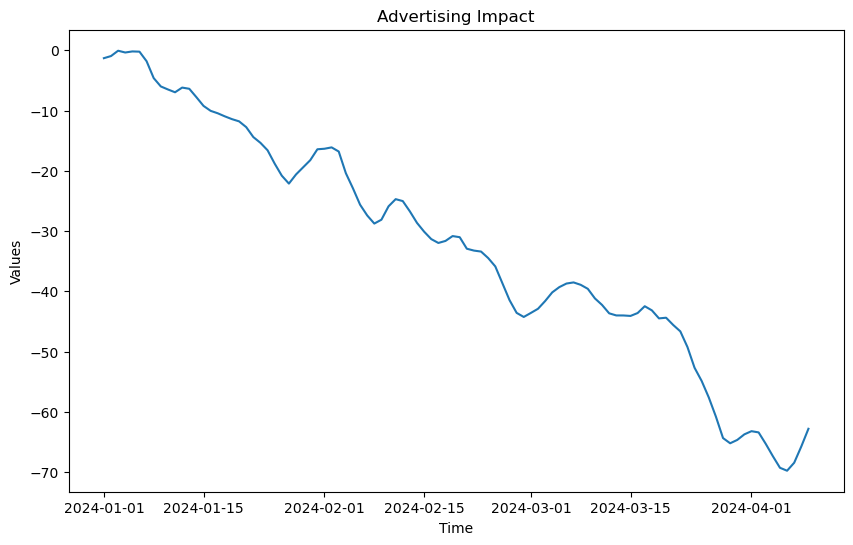

In [131]:
#Plot the time series
time_series(advertising_impact.index,advertising_impact['Advertising Impact'],'Advertising Impact','Time','Values')

#### Time Interval Decision
The impact of advertising is likely to be recorded on a daily basis. At large corporations there is daily spending of advertising and measuring its impact on a daily basis makes logical sense.

In [132]:
#Decompose the data into its individual parts, these can be accessed by indexing through the results
weekly_advertising_impact_decomposition = decompose_seasonality(advertising_impact['Advertising Impact'],7)

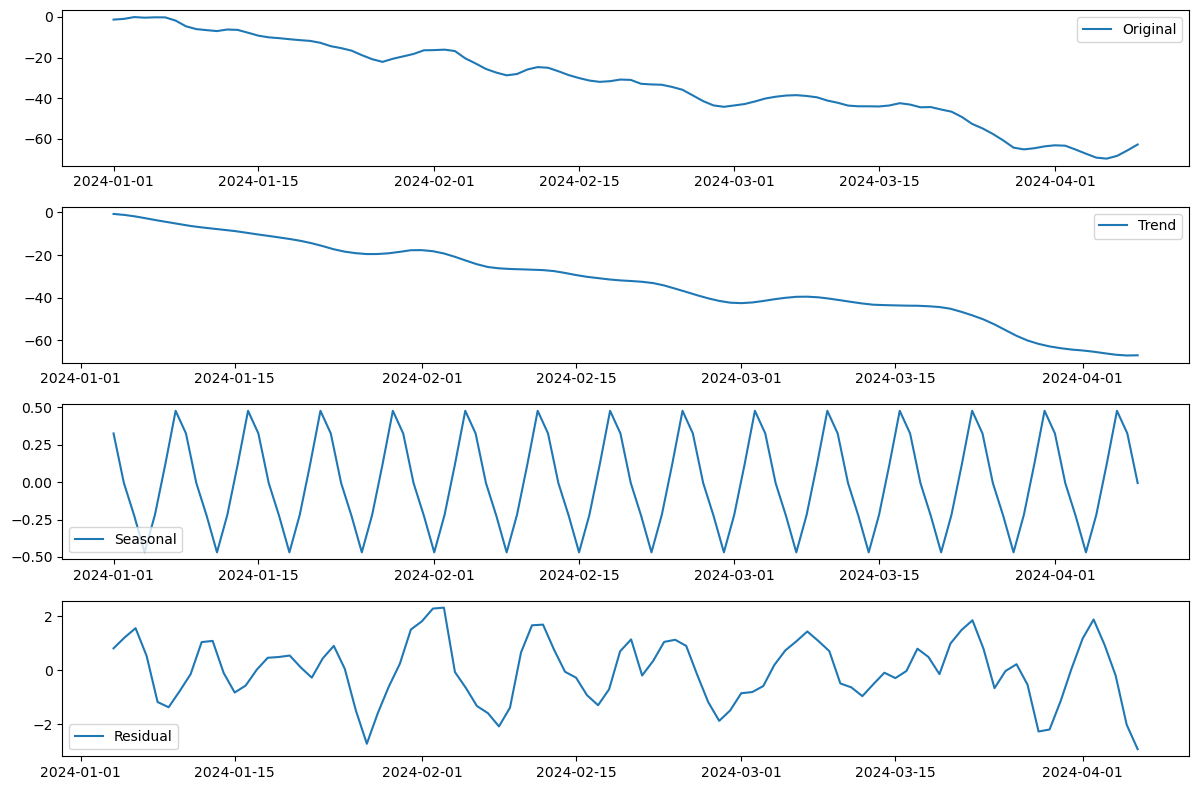

In [133]:
#Plot the seasonal decomposition of advertising impact
plot_seasonal_decomposition(advertising_impact['Advertising Impact'],7)

#### Weekly Seasonality Decomposition

Trend - There is a very clear trend that seems to be almost completely linear once the seasonal movement has been taken out

Cycles - There are no cycles

Seasonality - There are spikes and troughs that are displayed in the seasonality

Residual - The residual value seems to have periods where there is prolonged peaks

#### Trend Decomposition of Advertising Impact

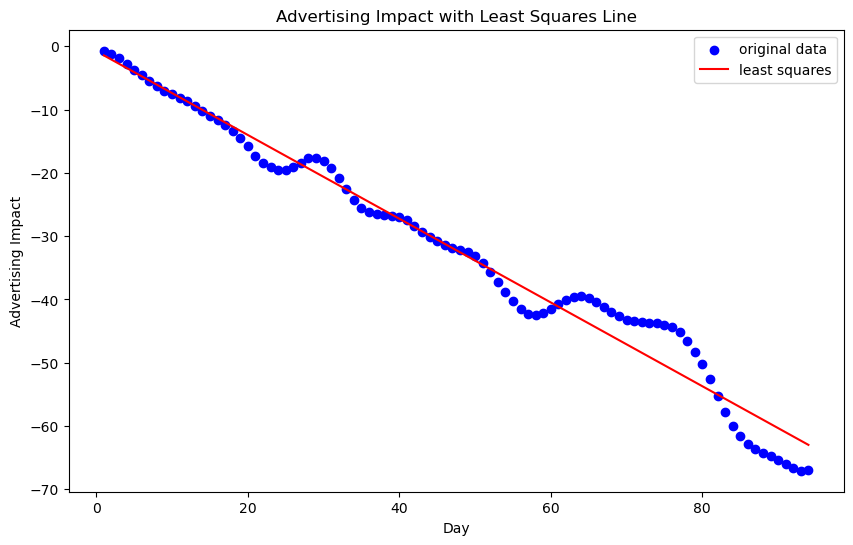

In [134]:
#Plot the trend with line of best fit
weekly_advertising_impact_decomposition[1].dropna(inplace=True)
plot_least_squares_line(advertising_impact['Incrementing Day'][0:94],weekly_advertising_impact_decomposition[1],
                        'Advertising Impact with Least Squares Line','Day','Advertising Impact')

The line of best fit very accurately follows the original data. This confirms that there is a trend that is present in the graph.

#### Seasonality Decomposition of Advertising Impact

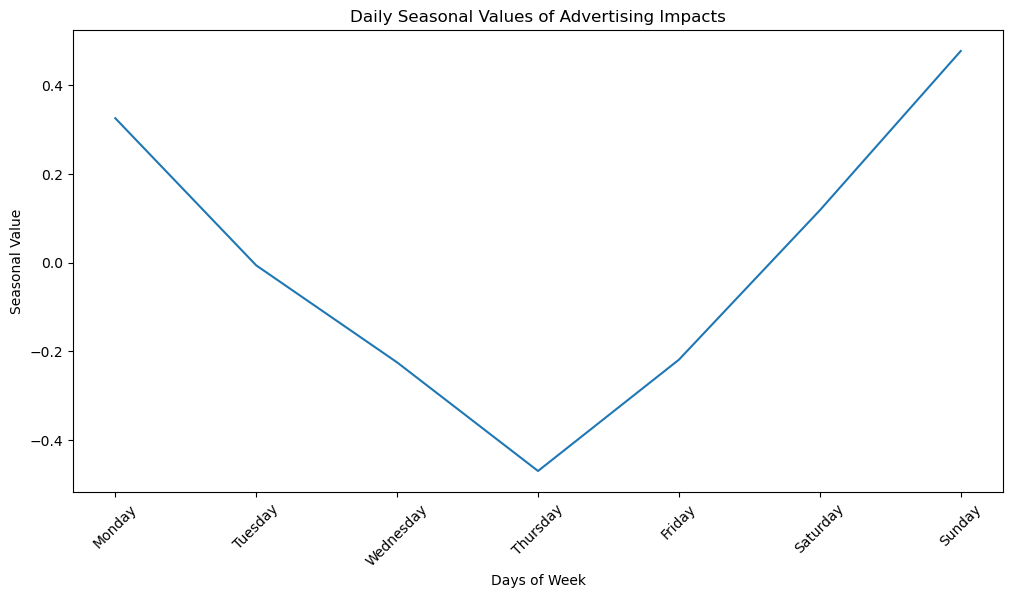

In [135]:
#Graph the seasonal values
seasonal_values_plot(weekly_advertising_impact_decomposition[2],7,'seasonal','Daily Seasonal Values of Advertising Impacts',
                     'Days of Week',days_column,'Seasonal Value')

Advertising impacts are lowest on Thursdays while they peak around Sunday and Monday, the movement is pretty linear. The middle of the week might be a time where people are not on their phones as much which might reduced the impact of using social media marketing.

In [136]:
#MAE for Advertising Impact
weekly_advertising_impact_decomposition[3].dropna(inplace=True)
mean_absolute_error(zeros_96,weekly_advertising_impact_decomposition[3])

0.9325936387550366

Observe that the mae is much higher than other values, this might be revelaed in the acf and pacf plots for why this is the case.

### Preliminary Analysis

In [137]:
#Create a new data frame that converts daily recordings to weekly
#This is goign to improve ease of drawing insightful statistics based on weeks and day of week
advertising_impact_weekly = create_weekly_data(advertising_impact,'Advertising Impact', 'Incrementing Day')
advertising_impact_weekly

Monday    Tuesday  Wednesday   Thursday     Friday   Saturday  \
0   -1.306527  -0.954923   -0.06822  -0.364128  -0.185789  -0.224147   
1    -4.61369  -5.996149  -6.500065  -6.965511  -6.187341   -6.38621   
2   -9.226716 -10.048295 -10.454081 -10.964946 -11.425449 -11.793819   
3  -14.402777 -15.360515 -16.593041 -18.812117 -20.812625 -22.126692   
4  -19.421745  -18.23879 -16.428494 -16.338696 -16.115017 -16.800431   
5  -22.914428 -25.627247 -27.410667 -28.760921 -28.118503 -25.899009   
6  -25.027615 -26.745223 -28.651988 -30.106187 -31.338158 -31.979787   
7  -30.836783 -31.022627 -32.935412 -33.246169 -33.408731  -34.48703   
8  -38.670422 -41.468385 -43.586009  -44.26429 -43.594795 -42.907047   
9  -40.184747   -39.3081  -38.71669 -38.531174 -38.928592  -39.59246   
10 -42.266741 -43.659879 -44.011379 -44.015771 -44.093202 -43.613333   
11 -43.167048 -44.501205 -44.391556 -45.594748 -46.658116 -49.251725   
12 -54.894987 -57.630471 -60.812082 -64.367478 -65.232958 -64.677403   
13 -63.225661 -63.428149 -65.322584 -67.369876 -69.300932 -69.789283   
14  -65.76332 -62.827442        NaN        NaN        NaN        NaN   

       Sunday  
0   -1.807945  
1   -7.779735  
2  -12.751261  
3  -20.605835  
4  -20.394251  
5  -24.708393  
6  -31.643727  
7  -35.873515  
8   -41.62944  
9  -41.186272  
10 -42.483165  
11 -52.698818  
12 -63.750221  
13 -68.463394  
14        NaN

#### Filling NaN Values
As there is a clear linear trend, the missing values are going to replaced with the most recent values in week 14. This is going to reduce the impact of not moving with the trend as week incremental continues.

In [138]:
#Replace the NaN values with the values from before
for day in days_replace:
    advertising_impact_weekly[day][14:15] = advertising_impact_weekly[day][13:14]
    advertising_impact_weekly

#### Finding mean, standard deviation, median and variance

In [139]:
#Create the statistical table that includes the components apart of the preliminary analysis
advertising_impact_statistics = mean_median_variance_std_weekly(advertising_impact_weekly,days_column)
advertising_impact_statistics

Monday     Tuesday   Wednesday    Thursday  \
0                    -1.306527   -0.954923    -0.06822   -0.364128   
1                     -4.61369   -5.996149   -6.500065   -6.965511   
2                    -9.226716  -10.048295  -10.454081  -10.964946   
3                   -14.402777  -15.360515  -16.593041  -18.812117   
4                   -19.421745   -18.23879  -16.428494  -16.338696   
5                   -22.914428  -25.627247  -27.410667  -28.760921   
6                   -25.027615  -26.745223  -28.651988  -30.106187   
7                   -30.836783  -31.022627  -32.935412  -33.246169   
8                   -38.670422  -41.468385  -43.586009   -44.26429   
9                   -40.184747    -39.3081   -38.71669  -38.531174   
10                  -42.266741  -43.659879  -44.011379  -44.015771   
11                  -43.167048  -44.501205  -44.391556  -45.594748   
12                  -54.894987  -57.630471  -60.812082  -64.367478   
13                  -63.225661  -63.428149  -65.322584  -67.369876   
14                   -65.76332  -62.827442  -65.322584  -67.369876   
Mean                -31.728214  -32.454493  -33.413657  -34.471459   
Median              -31.282498   -31.73856  -33.174535  -33.858814   
Variance            361.935496  355.309627  384.080024  405.347605   
Standard Deviation    94.59918   93.198628  100.220866  105.482009   

                        Friday    Saturday      Sunday  Weekly Mean  \
0                    -0.185789   -0.224147   -1.807945    -0.701668   
1                    -6.187341    -6.38621   -7.779735    -6.346957   
2                   -11.425449  -11.793819  -12.751261   -10.952081   
3                   -20.812625  -22.126692  -20.605835   -18.387657   
4                   -16.115017  -16.800431  -20.394251   -17.676775   
5                   -28.118503  -25.899009  -24.708393   -26.205595   
6                   -31.338158  -31.979787  -31.643727   -29.356098   
7                   -33.408731   -34.48703  -35.873515   -33.115752   
8                   -43.594795  -42.907047   -41.62944   -42.302913   
9                   -38.928592   -39.59246  -41.186272   -39.492576   
10                  -44.093202  -43.613333  -42.483165   -43.449067   
11                  -46.658116  -49.251725  -52.698818   -46.609031   
12                  -65.232958  -64.677403  -63.750221   -61.623657   
13                  -69.300932  -69.789283  -68.463394   -66.699983   
14                  -69.300932  -69.789283  -68.463394   -66.976690   
Mean                -34.980076  -35.287844  -35.615958          NaN   
Median              -34.194403  -34.887437  -35.744737          NaN   
Variance            424.674721  426.059562  399.255565          NaN   
Standard Deviation   110.16012  110.563618  104.318873          NaN   

                    Weekly Median  Standard Deviation   Variance  
0                       -0.364128            0.666232   0.443865  
1                       -6.386210            0.967230   0.935534  
2                      -10.964946            1.169867   1.368588  
3                      -18.812117            2.978390   8.870806  
4                      -16.800431            1.698096   2.883531  
5                      -25.899009            2.047070   4.190497  
6                      -30.106187            2.666345   7.109398  
7                      -33.246169            1.788664   3.199317  
8                      -42.907047            1.909287   3.645377  
9                      -39.308100            0.934174   0.872681  
10                     -43.659879            0.758787   0.575757  
11                     -45.594748            3.324352  11.051314  
12                     -63.750221            4.005880  16.047072  
13                     -67.369876            2.724583   7.423355  
14                     -67.369876            2.486707   6.183709  
Mean                          NaN                 NaN        NaN  
Median                        NaN                 NaN        Na

#### Weekly Mean of Advertising Impact

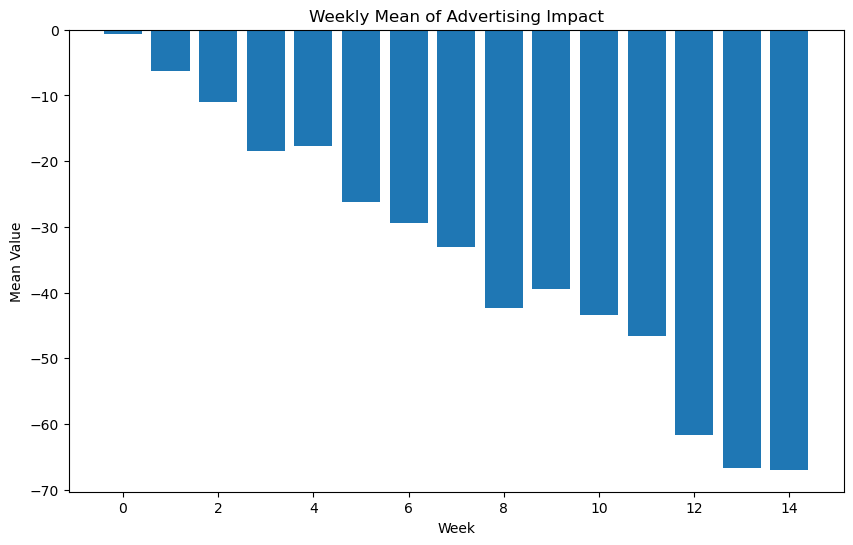

In [140]:
#Create a bar chart of the mean of the values from weeks 1-15
bar_chart(advertising_impact_statistics.index[0:15],advertising_impact_statistics['Weekly Mean'][0:15],
          'Weekly Mean of Advertising Impact','Week','Mean Value')

This has a clear negatively skewed spread which represents the negative trend to the data. This is very clear and clearly as time has continued the impacts of advertising has increasingly gotten worst

#### Weekly Median of Advertising Impact

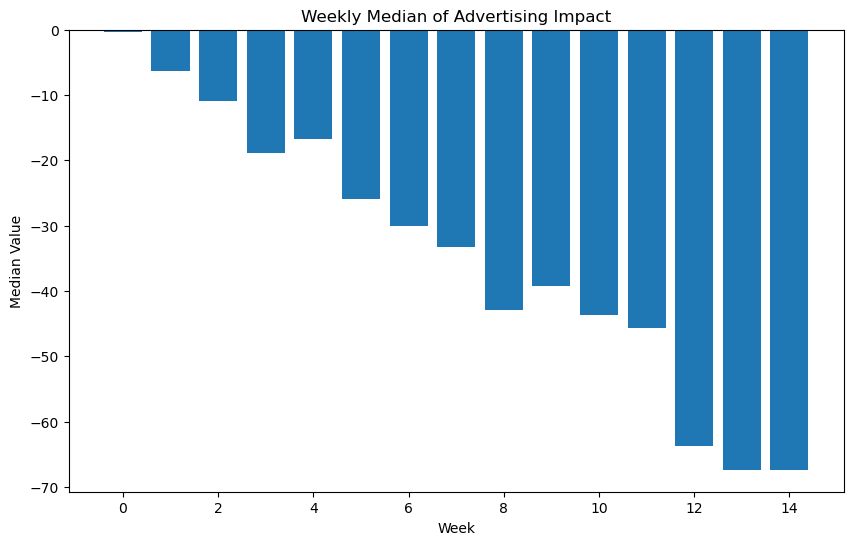

In [141]:
#Create a bar chart of the median of advertising impact
bar_chart(advertising_impact_statistics.index[0:15],advertising_impact_statistics['Weekly Median'][0:15],
          'Weekly Median of Advertising Impact','Week','Median Value')

The median value follows an extremely similar progression as mean does. 

#### Weekly Variance of Advertising Impact

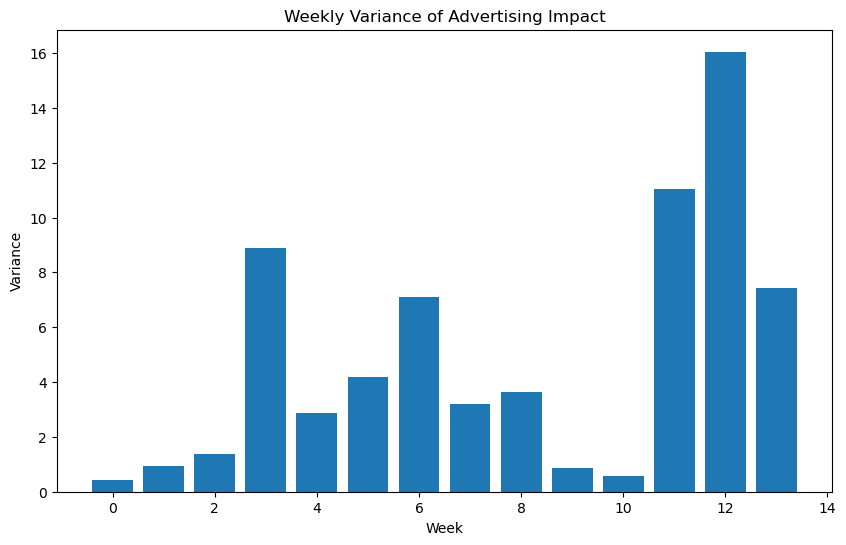

In [142]:
#Create a bar chart of the variance
bar_chart(advertising_impact_statistics.index[0:14],advertising_impact_statistics['Variance'][0:14],
          'Weekly Variance of Advertising Impact','Week','Variance')

The variance is quite low which makes sense considering the similar pattern that the mean and median follows. THis is the variance with denormalised values which is why they are not as small as before.

#### Weekly Standard Deviation of Advertising Impact

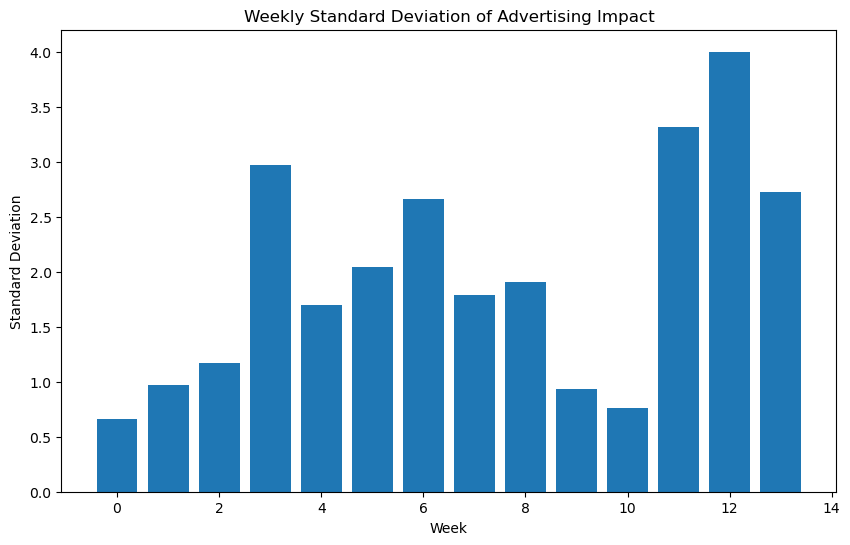

In [143]:
#Create a bar chart of standard deviation
bar_chart(advertising_impact_statistics.index[0:14],advertising_impact_statistics['Standard Deviation'][0:14],
          'Weekly Standard Deviation of Advertising Impact','Week','Standard Deviation')

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### q order for Advertising Impact

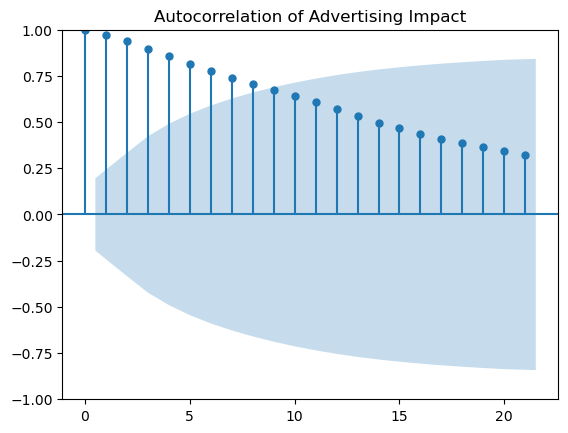

In [144]:
#Plot the ACF values
acf_values_advertising_impact = plot_acf(advertising_impact['Advertising Impact'], lags=21,title='Autocorrelation of Advertising Impact')

In [145]:
#q orders for advertising impact
q_orders_advertising_impact = [1,2,3,4,5]

#### p Order for Advertising Impact

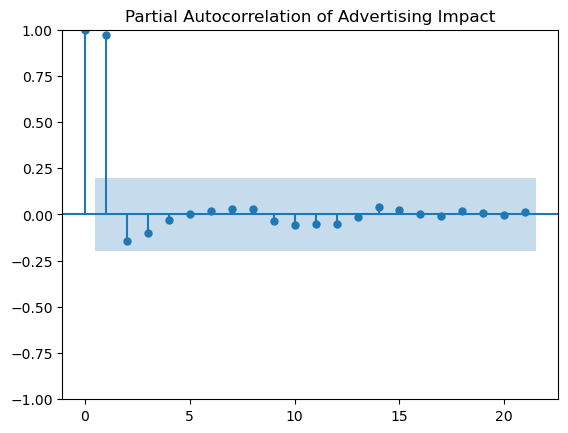

In [146]:
#Plot the PACF values
pacf_values_advertising_impact = plot_pacf(advertising_impact['Advertising Impact'],lags=21,title='Partial Autocorrelation of Advertising Impact')

In [147]:
#p orders
p_orders_advertising_impact = [1,2]

#### d order for Advertising Impact

In [148]:
#Check ADF test
adf_test(advertising_impact['Advertising Impact'])

ADF Statistic:  -0.6691826318973068
P-Value:  0.8545712849049061
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


In [149]:
#The adf statistic is not above any threshold so the difference needs to be done
advertising_impact['First Difference'] = advertising_impact['Advertising Impact'].diff()
advertising_impact = advertising_impact[1::]
advertising_impact

Advertising Impact  Incrementing Day  First Difference
Day                                                               
2024-01-02           -0.954923                 2          0.351604
2024-01-03           -0.068220                 3          0.886703
2024-01-04           -0.364128                 4         -0.295909
2024-01-05           -0.185789                 5          0.178340
2024-01-06           -0.224147                 6         -0.038358
...                        ...               ...               ...
2024-04-05          -69.300932                96         -1.931057
2024-04-06          -69.789283                97         -0.488351
2024-04-07          -68.463394                98          1.325889
2024-04-08          -65.763320                99          2.700074
2024-04-09          -62.827442               100          2.935878

[99 rows x 3 columns]

In [150]:
#Look at the ADF test
adf_test(advertising_impact['First Difference'])

ADF Statistic:  -5.8251524040953315
P-Value:  4.095712772366002e-07
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


In [151]:
#d order 
d_orders_advertising_impact = [1,2]

#### Removing Seasonality from data for P,D,Q

In [152]:
#Create the new series which has seasonal components removed from the data
weekly_advertising_impact_seasonally_removed = weekly_advertising_impact_decomposition[0] - weekly_advertising_impact_decomposition[2]
weekly_advertising_impact_seasonally_removed

Day
2024-01-01    -1.631611
2024-01-02    -0.948616
2024-01-03     0.156636
2024-01-04     0.105315
2024-01-05     0.032947
                ...    
2024-04-05   -69.082197
2024-04-06   -69.907031
2024-04-07   -68.939904
2024-04-08   -66.088405
2024-04-09   -62.821135
Length: 100, dtype: float64

#### Q order for Advertising Impact

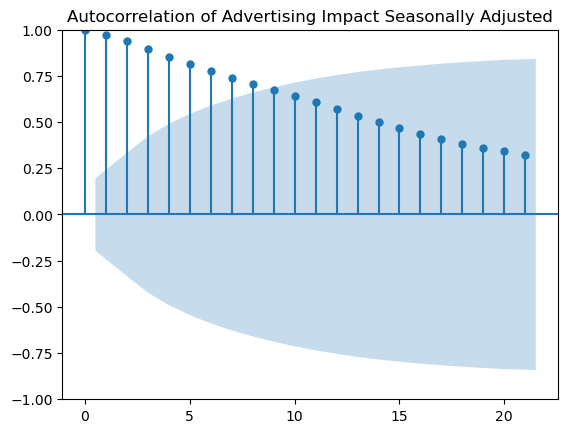

In [153]:
#Create an acf plot for advertising impact
acf_values_advertising_impact_seasonally=plot_acf(weekly_advertising_impact_seasonally_removed,lags=21,title='Autocorrelation of Advertising Impact Seasonally Adjusted')

In [154]:
#Q order 
Q_orders_advertising_impact = [1,2,3,4,5]

#### P order for Advertising Impact

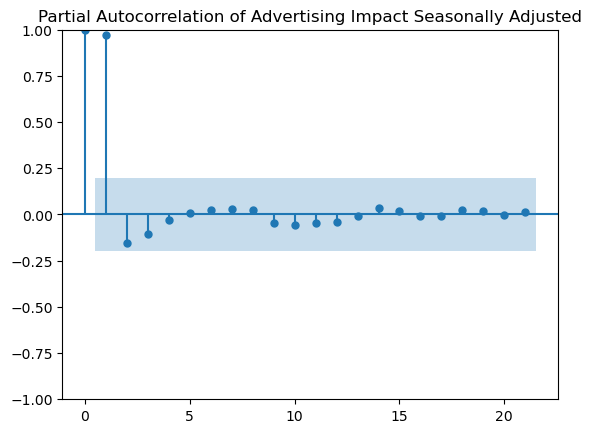

In [155]:
#Create a pacf plot of stock prices
pacf_value_advertising_impact_seasonally_removed = plot_pacf(weekly_advertising_impact_seasonally_removed,lags=21,title='Partial Autocorrelation of Advertising Impact Seasonally Adjusted')

In [156]:
#P orders
P_orders_advertising_impact = [1,2,3]

#### D Order for Advertising Impact

In [157]:
#ADF test for advertising impact
adf_test(weekly_advertising_impact_seasonally_removed)

ADF Statistic:  -0.6870330485370345
P-Value:  0.8500797414602144
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


Similar to the non seasonally adjusted data, the first difference needs to be completed

In [158]:
advertising_impact['First Different SA'] = weekly_advertising_impact_seasonally_removed.diff()
advertising_impact = advertising_impact[1::]
advertising_impact

Advertising Impact  Incrementing Day  First Difference  \
Day                                                                  
2024-01-03           -0.068220                 3          0.886703   
2024-01-04           -0.364128                 4         -0.295909   
2024-01-05           -0.185789                 5          0.178340   
2024-01-06           -0.224147                 6         -0.038358   
2024-01-07           -1.807945                 7         -1.583798   
...                        ...               ...               ...   
2024-04-05          -69.300932                96         -1.931057   
2024-04-06          -69.789283                97         -0.488351   
2024-04-07          -68.463394                98          1.325889   
2024-04-08          -65.763320                99          2.700074   
2024-04-09          -62.827442               100          2.935878   

            First Different SA  
Day                             
2024-01-03            1.105252  
2024-01-04           -0.051320  
2024-01-05           -0.072369  
2024-01-06           -0.374842  
2024-01-07           -1.942560  
...                        ...  
2024-04-05           -2.181765  
2024-04-06           -0.824834  
2024-04-07            0.967127  
2024-04-08            2.851500  
2024-04-09            3.267269  

[98 rows x 4 columns]

In [159]:
#Rerun the ADF test
adf_test(advertising_impact['First Different SA'])

ADF Statistic:  -5.64904473200669
P-Value:  9.958030572737319e-07
Critical Value: 
	1%: -3.50
	5%: -2.89
	10%: -2.58


This is now beyond the threshold that is required

In [160]:
#D Order
D_orders_advertising_impact = [1,2]

#### Parameters for Box Jenkins Models
- q: 1,2,3,4,5
- p: 1,2
- d: 1,2
- Q: 1,2,3,4,5
- P: 1,2,3
- D: 1,2
- s: 7

#### AR Model Selection

In [161]:
#Find the best AR model
#Returns p
select_best_ar_model(advertising_impact['Advertising Impact'],p_orders_advertising_impact)

{'best_aic': 287.651992653593,
 'best_aic_model': 2,
 'best_bic': 297.99186256827534,
 'best_bic_model': 2}

#### MA Model Selection

In [162]:
#Find best MA model
#Returns q
select_best_ma_model(advertising_impact['Advertising Impact'],q_orders_advertising_impact)

{'best_aic': 431.02130042942616,
 'best_aic_model': 5,
 'best_bic': 449.1160727801202,
 'best_bic_model': 5}

#### ARMA Model Selection

In [163]:
#Find the ARMA
#Returns p,q
select_best_arma_model(advertising_impact['Advertising Impact'],p_orders_advertising_impact,q_orders_advertising_impact)

{'best_aic': 265.9856817474751,
 'best_aic_model': (2, 1),
 'best_bic': 273.70981468298527,
 'best_bic_model': (2, 1)}

#### ARIMA Model

In [164]:
#Find the ARIMA
#Returns p,d,q
select_best_arima(advertising_impact['Advertising Impact'],p_orders_advertising_impact,q_orders_advertising_impact,d_orders_advertising_impact)

{'best_aic': 260.82485772152995,
 'best_aic_model': (2, 2, 2),
 'best_bic': 273.6465986788691,
 'best_bic_model': (2, 2, 2)}

In [165]:
#Find the best SARIMA
#Returns p,d,q
#Returns P,D,Q,s
select_best_sarima_model(advertising_impact['Advertising Impact'],p_orders_advertising_impact,d_orders_advertising_impact,q_orders_advertising_impact,P_orders_advertising_impact,D_order_electricity_consumption,Q_orders_advertising_impact,7)

{'aic': 258.7828572204112,
 'bic': 271.6564121129281,
 'pdq': (2, 1, 1),
 'seasonal_pdq': (0, 0, 0, 7)}

#### Best Model Selection
##### AR Model
AIC : 285.51, 
p : 2

BIC : 295.81,
p : 2
##### MA Model
AIC : 461.02,
q : 5

BIC : 479.05,
q : 5
##### ARMA Model
AIC : 264.02,
p : 2, 
q: 1

BIC : 271.72,
p : 2,
q : 1
##### ARIMA Model
AIC : 258.89,
p : 2, 
d : 2,
q : 2

BIC : 271.66
p : 2,
d : 2,
q : 2
##### SARIMA Model
AIC : 256.86

BIC : 269.67

p : 2,
d : 1,
q : 1,
P : 0,
D : 0,
Q : 0,
s : 7

#### ARIMA is Best Model
ARIMA (2,2,2)

AIC : 258.89


## Sales Data
Sales data explicity states that the sales are monthly with an index of 120 it can be assumed that the data is taken from 10 years. 

### Data Exploration
- Load the Data: Begin by loading each dataset from the Excel file.

- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components.

In [166]:
#Load in the sales data
sales_data = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Sales Data')
sales_data

Unnamed: 0  Monthly Sales
0             0      -0.598654
1             1      -2.313205
2             2      -2.961766
3             3      -2.546422
4             4      -3.929142
..          ...            ...
115         115     -15.306840
116         116     -15.505981
117         117     -14.308235
118         118     -12.901095
119         119     -10.312717

[120 rows x 2 columns]

#### Time Interval Decision
Given in the name of the the dataframe, this is sales data from the past 10 years (12 months in each year). 

In [167]:
#Preprocess data
sales_data['Incrementing Month'] = range(1, len(sales_data)+1)
sales_data.drop(columns='Unnamed: 0',inplace=True)
sales_data['Month'] = pd.date_range('2014-01-01',periods=len(sales_data),freq='M')
sales_data.set_index('Month',inplace=True)
sales_data

Monthly Sales  Incrementing Month
Month                                        
2014-01-31      -0.598654                   1
2014-02-28      -2.313205                   2
2014-03-31      -2.961766                   3
2014-04-30      -2.546422                   4
2014-05-31      -3.929142                   5
...                   ...                 ...
2023-08-31     -15.306840                 116
2023-09-30     -15.505981                 117
2023-10-31     -14.308235                 118
2023-11-30     -12.901095                 119
2023-12-31     -10.312717                 120

[120 rows x 2 columns]

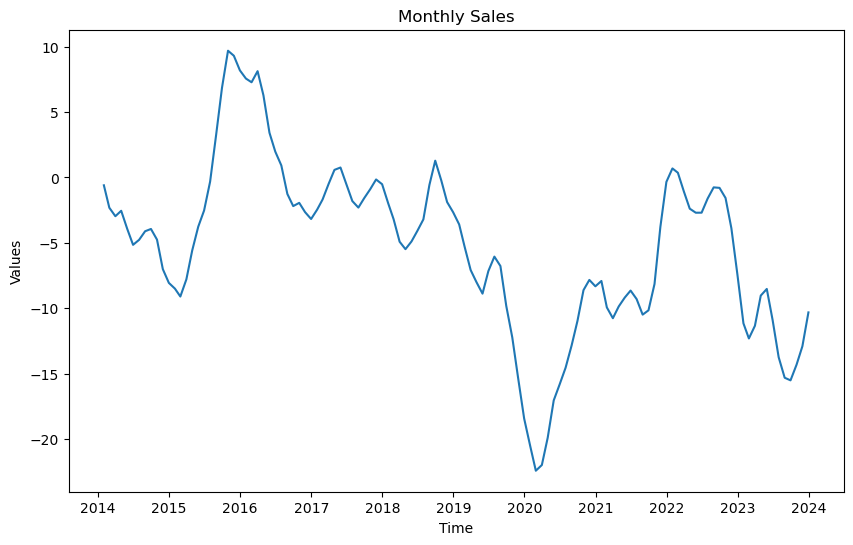

In [168]:
#Plot the time series
time_series(sales_data.index,sales_data['Monthly Sales'],'Monthly Sales','Time','Values')

In [169]:
#Seasonally decompose the sales data into its own parts as variables
monthly_sales_data_decomposition = decompose_seasonality(sales_data['Monthly Sales'],12)

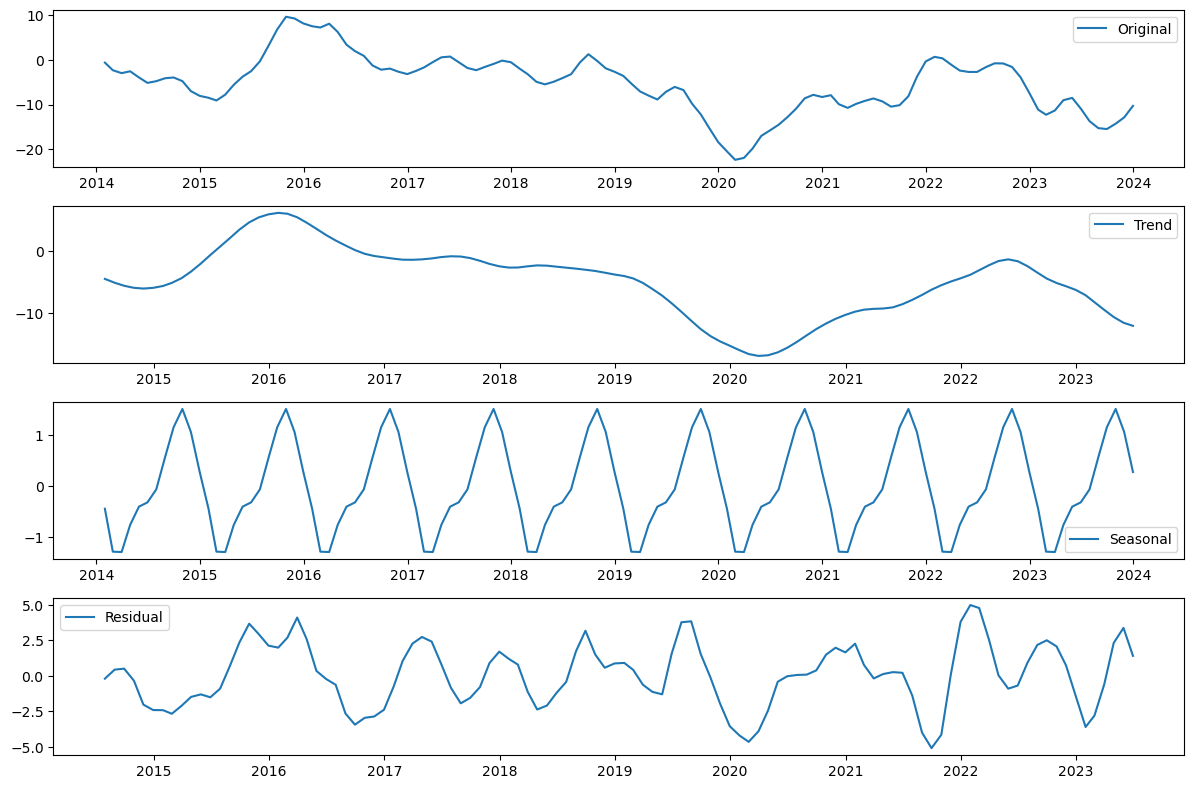

In [170]:
#Plot the above variables as individual graphs
plot_seasonal_decomposition(sales_data['Monthly Sales'],12)

Trend - There is an overall decrease in the average value of data

Cycles - There is a cycle of higher values from 2015 to 2019 before a slump in 2020 to 2021 and another decline through 2022

Seasonal - There are months which seem to be performing better than others

Residual - The residual values are quite high but do hover around a mean of between 0 and 1

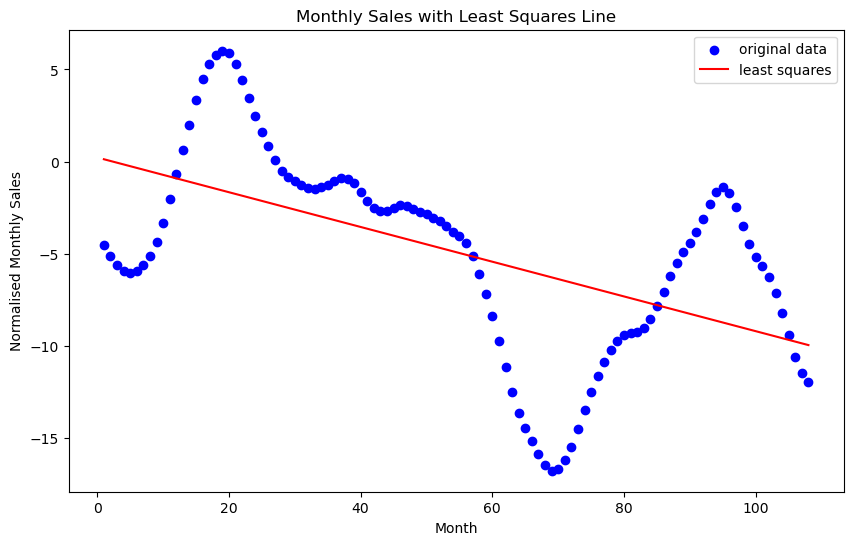

In [171]:
#Plot the trend with line of best fit
monthly_sales_data_decomposition[1].dropna(inplace=True)
plot_least_squares_line(sales_data['Incrementing Month'][0:108],monthly_sales_data_decomposition[1],
                        'Monthly Sales with Least Squares Line','Month','Normalised Monthly Sales')

There is an overall decrease in the number of sales over this time period. 

#### Seasonality Decomposition of Sales Data

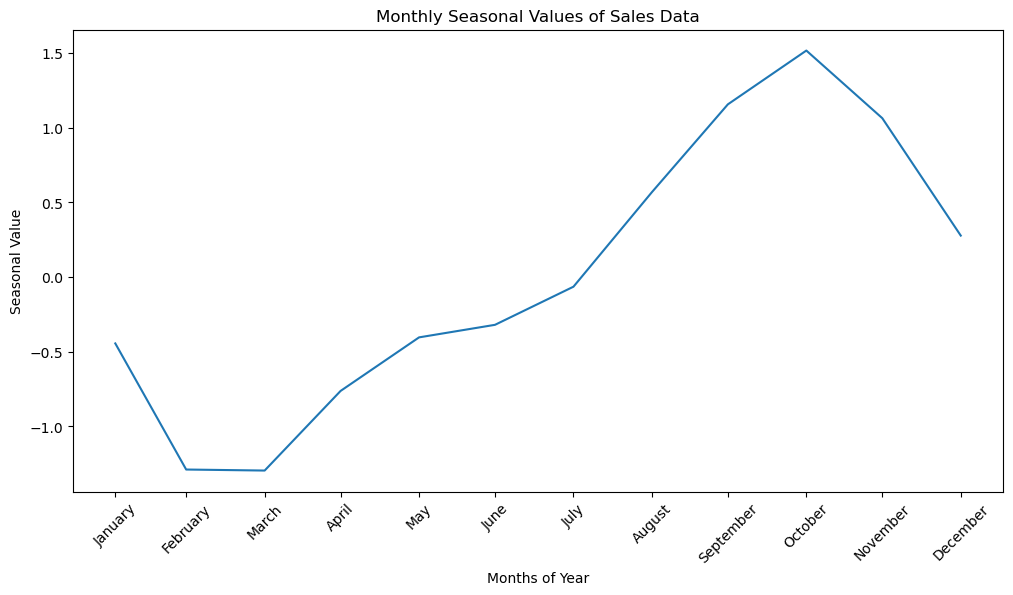

In [172]:
#Plot the seasonal values
seasonal_values_plot(monthly_sales_data_decomposition[2],12,'seasonal','Monthly Seasonal Values of Sales Data',
                     'Months of Year',months_list,'Seasonal Value')

Seasonal values show that February and March are the lowest while sales peak in October. This is likely the result of sales for a product that is most popular in the fall. This could be the sale of outdoor furniture. 

In [173]:
#MAE for Sales Data
monthly_sales_data_decomposition[3].dropna(inplace=True)
zeros_108 = np.zeros(len(monthly_sales_data_decomposition[3]))
mean_absolute_error(zeros_108,monthly_sales_data_decomposition[3])

1.794207200954402

This is the worst average absolute error that has been observed. Perhaps the seasonal value was incorrect, this will be explored later through the ACF and PACF plots

In [174]:
#Create a new dataframe that converts monthly records into yearly with months as the column
#This is going to improve ease of drawing insightful statistics based on months and the year
sales_data_monthly = create_monthly_data(sales_data,'Monthly Sales', 'Incrementing Month')
sales_data_monthly

January   February      March     April        May       June       July  \
0  -0.598654  -2.313205  -2.961766 -2.546422  -3.929142  -5.149289  -4.767102   
1  -8.493918  -9.099315  -7.786026 -5.578519   -3.76169  -2.525802  -0.316832   
2   7.559436   7.275234   8.123156  6.278963   3.417716    1.97234   0.917759   
3   -2.45893  -1.684665  -0.494321  0.579394   0.760152  -0.506504  -1.805473   
4  -1.964838  -3.190206  -4.912712 -5.481032  -4.891938   -4.08673  -3.205674   
5  -3.590384  -5.294005   -7.07442 -8.002884  -8.879263  -7.156408  -6.049257   
6 -20.518482 -22.412952 -21.976178 -19.89396 -17.036518 -15.830646 -14.540326   
7  -7.911403  -9.932485 -10.757508 -9.860223  -9.180719  -8.643311  -9.294288   
8    0.69014     0.3614  -1.078129  -2.38477  -2.694285  -2.691918   -1.61151   
9 -11.150463 -12.304923 -11.336179 -9.029212  -8.520459 -10.900812 -13.735358   

      August  September    October   November   December  
0  -4.109823  -3.936774  -4.750425   -7.00761  -8.059172  
1    3.26724   6.848576   9.686221   9.301553   8.185639  
2   -1.25986  -2.188159  -1.940955  -2.650022   -3.17529  
3   -2.30363  -1.579729  -0.894969  -0.152728  -0.517511  
4   -0.57465   1.282519  -0.224769  -1.879834   -2.65832  
5  -6.769052  -9.814128 -12.229491 -15.327837 -18.424668  
6 -12.834868 -10.962733  -8.611523  -7.829962  -8.317881  
7 -10.484688 -10.154575  -8.141355  -3.789509  -0.339399  
8  -0.757347  -0.794825  -1.568558  -3.878693  -7.417845  
9  -15.30684 -15.505981 -14.308235 -12.901095 -10.312717

#### Finding mean, median, variance and standard deviation

In [175]:
#Create statistical table using the function above
sales_data_statistics = mean_median_variance_std_monthly(sales_data_monthly,months_list)
sales_data_statistics

January   February      March      April        May  \
0                   -0.598654  -2.313205  -2.961766  -2.546422  -3.929142   
1                   -8.493918  -9.099315  -7.786026  -5.578519   -3.76169   
2                    7.559436   7.275234   8.123156   6.278963   3.417716   
3                    -2.45893  -1.684665  -0.494321   0.579394   0.760152   
4                   -1.964838  -3.190206  -4.912712  -5.481032  -4.891938   
5                   -3.590384  -5.294005   -7.07442  -8.002884  -8.879263   
6                  -20.518482 -22.412952 -21.976178  -19.89396 -17.036518   
7                   -7.911403  -9.932485 -10.757508  -9.860223  -9.180719   
8                     0.69014     0.3614  -1.078129   -2.38477  -2.694285   
9                  -11.150463 -12.304923 -11.336179  -9.029212  -8.520459   
Mean                 -4.84375  -5.859512  -6.025408  -5.591867  -5.471615   
Median              -3.590384  -5.294005  -6.025408  -5.578519  -4.891938   
Variance            47.970574  53.782747  52.281697  39.906453  27.266158   
Standard Deviation  16.052751  17.958266  17.590955  13.993261  10.353457   

                         June       July     August  September    October  \
0                   -5.149289  -4.767102  -4.109823  -3.936774  -4.750425   
1                   -2.525802  -0.316832    3.26724   6.848576   9.686221   
2                     1.97234   0.917759   -1.25986  -2.188159  -1.940955   
3                   -0.506504  -1.805473   -2.30363  -1.579729  -0.894969   
4                    -4.08673  -3.205674   -0.57465   1.282519  -0.224769   
5                   -7.156408  -6.049257  -6.769052  -9.814128 -12.229491   
6                  -15.830646 -14.540326 -12.834868 -10.962733  -8.611523   
7                   -8.643311  -9.294288 -10.484688 -10.154575  -8.141355   
8                   -2.691918   -1.61151  -0.757347  -0.794825  -1.568558   
9                  -10.900812 -13.735358  -15.30684 -15.505981 -14.308235   
Mean                -5.551908  -5.440806  -5.113352  -4.680581  -4.298406   
Median              -5.149289  -4.767102  -4.109823  -3.936774  -4.298406   
Variance            22.569014  24.295616  29.964062  37.585418  39.402879   
Standard Deviation   9.020693   9.488624  11.030157  13.094543  13.528754   

                     November   December  Monthly Mean  Monthly Median  \
0                    -7.00761  -8.059172     -7.161340       -4.023299   
1                    9.301553   8.185639     -0.038982       -1.421317   
2                   -2.650022   -3.17529      3.475760        1.445050   
3                   -0.152728  -0.517511     -1.579845       -0.706240   
4                   -1.879834   -2.65832     -4.541169       -2.924263   
5                  -15.327837 -18.424668    -15.515971       -7.579646   
6                   -7.829962  -8.317881    -25.823719      -15.185486   
7                   -3.789509  -0.339399    -14.069924       -9.237503   
8                   -3.878693  -7.417845     -3.403763       -1.590034   
9                  -12.901095 -10.312717    -20.758896      -11.820551   
Mean                -4.611574  -5.103717           NaN             NaN   
Median              -3.878693  -5.103717           NaN             NaN   
Variance            38.738657  41.730905           NaN             NaN   
Standard Deviation   13.40375  14.386893           NaN             NaN   

                    Standard Deviation   Variance  
0                             2.028065   4.113047  
1                             7.212582  52.021335  
2                             4.367396  19.074150  
3                             1.055778   1.114666  
4                             2.078939   4.321989  
5                             4.314089  18.611364  
6                             5.401038  29.171208  
7                             3.089898   9.547472  
8                             2.152915   4.635042  
9                             2.305690   5.316204  
Mean                       

The dataframe is similar to the weekly mean, median, variance and standard deviation table creation that took place before. However, now it is based on the month of the year for the year value. This is going to be useful for looking at how the year values change over time.

#### Yearly Mean for Sales Data

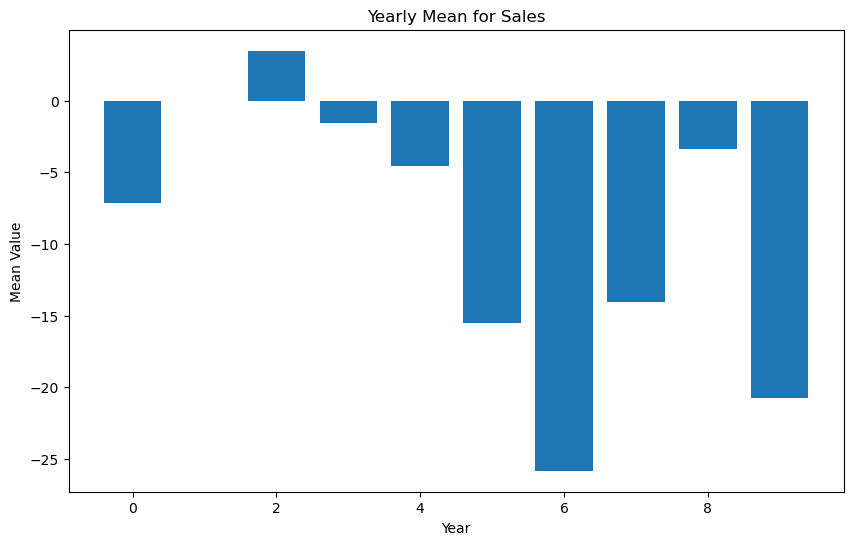

In [176]:
#Create a bar chart of the mean of the values from years 1-10
bar_chart(sales_data_statistics.index[0:10],sales_data_statistics['Monthly Mean'][0:10],
          'Yearly Mean for Sales','Year','Mean Value')

The mean value for each incrementing year shows higher values at the beginning before having much larger decreases to the later years. However, this is not as clear as the patterns that were observed in advertising impact.

#### Yearly Median for Sales Data

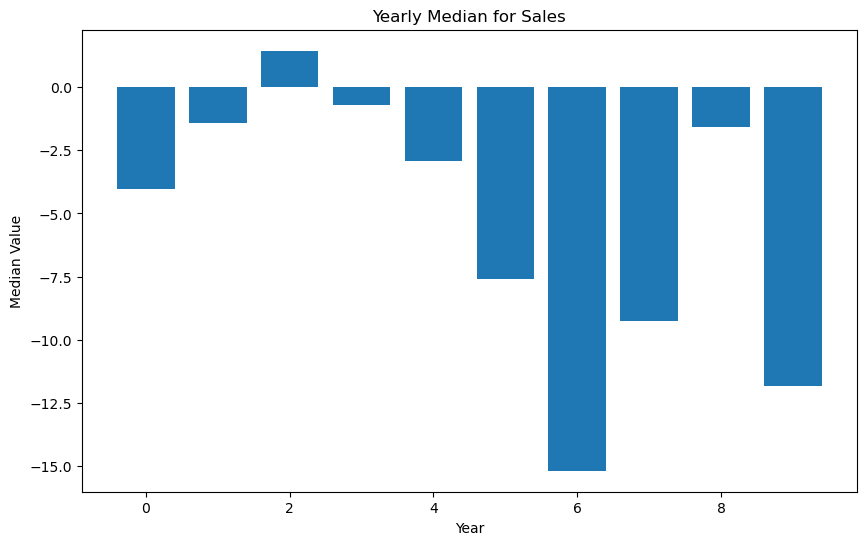

In [177]:
#Create a bar chart of the median values of sales data
bar_chart(sales_data_statistics.index[0:10],sales_data_statistics['Monthly Median'][0:10],
          'Yearly Median for Sales','Year', 'Median Value')

The median values follow the same pattern but are lower on average.

#### Yearly Variance for Sales Data

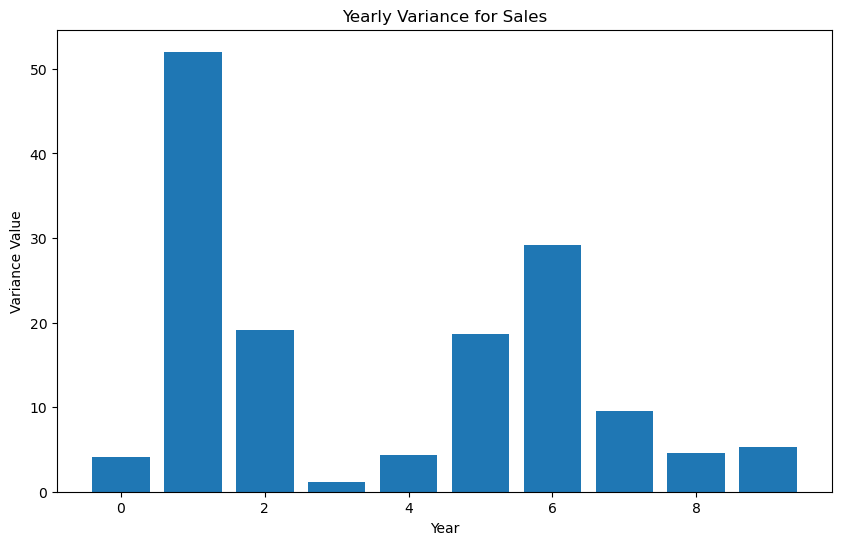

In [178]:
#Create a bar chart for for variance of sales data
bar_chart(sales_data_statistics.index[0:10],sales_data_statistics['Variance'][0:10],
          'Yearly Variance for Sales','Year', 'Variance Value')

There is a large variance in sales in year 2 

#### Yearly Standard Deviation for Sales Data

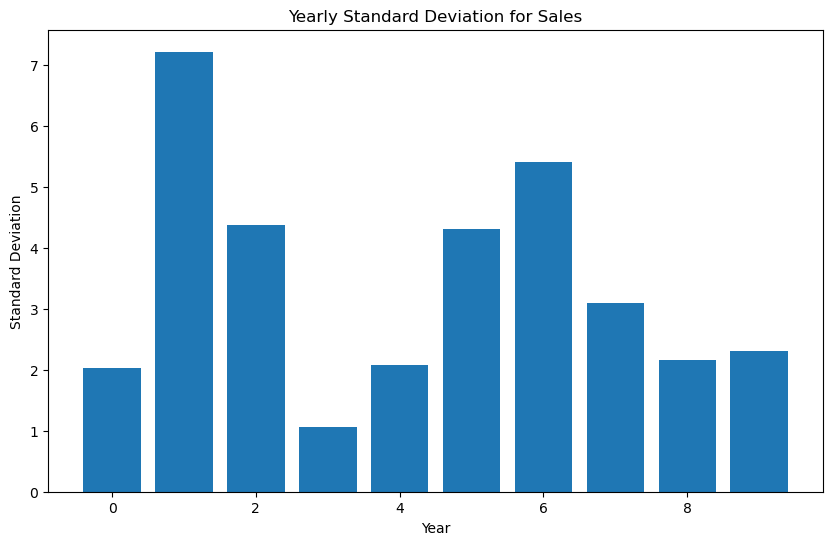

In [179]:
#Bar chart for standard deviaiton of sales data
bar_chart(sales_data_statistics.index[0:10],sales_data_statistics['Standard Deviation'][0:10],
          'Yearly Standard Deviation for Sales','Year', 'Standard Deviation')

The large variation is still observed in year 2 but is not as bad compared to the other values and is quite symmetrical.

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### q Order for Sales Data

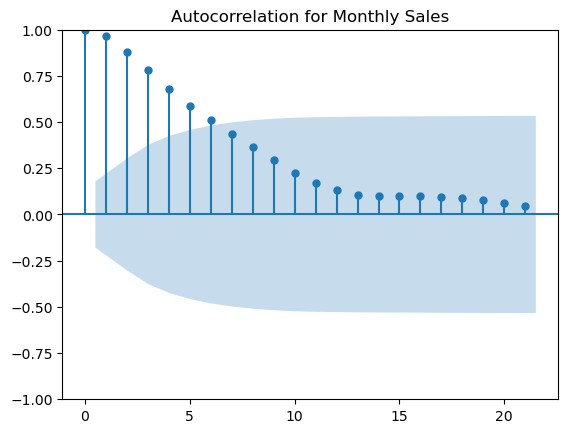

In [180]:
#Plot the ACF values
acf_values_sales_data = plot_acf(sales_data['Monthly Sales'],lags=21,title='Autocorrelation for Monthly Sales')

In [181]:
#List potential ma (q) orders
q_sales_data = [1,2,3,4,5]

#### p Order for Sales Data

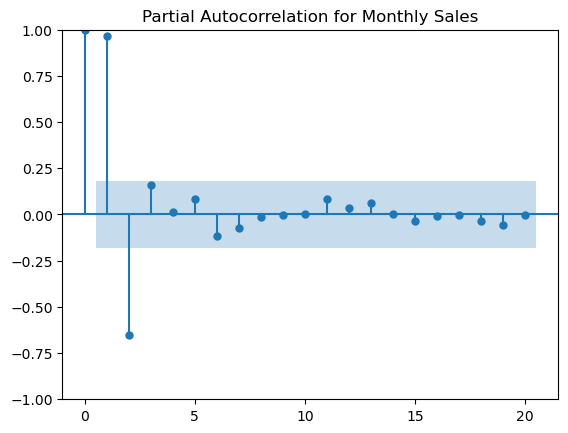

In [182]:
pacf_values_sales_data = plot_pacf(sales_data['Monthly Sales'],lags=20,title='Partial Autocorrelation for Monthly Sales')

In [183]:
#List potential ar (p) orders
p_sales_data = [1,2,3]

#### d Order for Sales Data

In [184]:
#Check stationarity using dickey fuller test
adf_test(sales_data['Monthly Sales'])

ADF Statistic:  -2.2241682319536644
P-Value:  0.19759099515747625
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


As this is not stationary, take the first difference then recheck.

In [185]:
#Take the first difference of sales data
sales_data['First Difference'] = sales_data['Monthly Sales'].diff()
sales_data = sales_data[1::]
sales_data

Monthly Sales  Incrementing Month  First Difference
Month                                                          
2014-02-28      -2.313205                   2         -1.714551
2014-03-31      -2.961766                   3         -0.648561
2014-04-30      -2.546422                   4          0.415344
2014-05-31      -3.929142                   5         -1.382720
2014-06-30      -5.149289                   6         -1.220147
...                   ...                 ...               ...
2023-08-31     -15.306840                 116         -1.571482
2023-09-30     -15.505981                 117         -0.199141
2023-10-31     -14.308235                 118          1.197747
2023-11-30     -12.901095                 119          1.407139
2023-12-31     -10.312717                 120          2.588378

[119 rows x 3 columns]

In [186]:
#Look at the dickey fuller test again
adf_test(sales_data['First Difference'])

ADF Statistic:  -6.459348451886727
P-Value:  1.456319390373206e-08
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


As this is now below the threshold, it is considered stationary, which can now be used in the ARIMA model. 

In [187]:
# List the potential i (d) orders
d_orders_sales_data = [1,2]

#### Removing Seasonality from Data for P,D,Q

We are trying to find the values for the SARIMA model. In order to do this, we have to remove the seasonality from the original data. This creates seasonally adjusted data which is used for the SARIMA model. 

In [188]:
#Create a new series which has the seasonal components removed from the data
monthly_sales_data_seasonal_removed = monthly_sales_data_decomposition[0] - monthly_sales_data_decomposition[2]
monthly_sales_data_seasonal_removed

Month
2014-01-31    -0.153753
2014-02-28    -1.023543
2014-03-31    -1.665236
2014-04-30    -1.783266
2014-05-31    -3.524769
                ...    
2023-08-31   -15.875513
2023-09-30   -16.662666
2023-10-31   -15.825258
2023-11-30   -13.965075
2023-12-31   -10.590158
Length: 120, dtype: float64

#### Q order for Monthly Sales

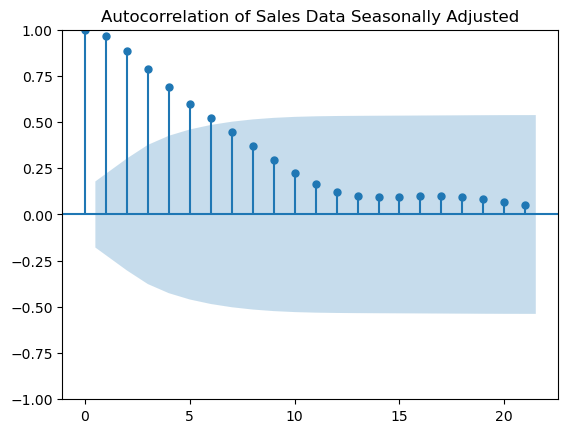

In [189]:
#Plot the new acf
acf_values_sales_data_seasonally_adjusted = plot_acf(monthly_sales_data_seasonal_removed,lags=21,title='Autocorrelation of Sales Data Seasonally Adjusted')

In [190]:
# Orders for Q
Q_orders_sales_data = [1,2,3,4,5]

#### P order for Monthly Sales

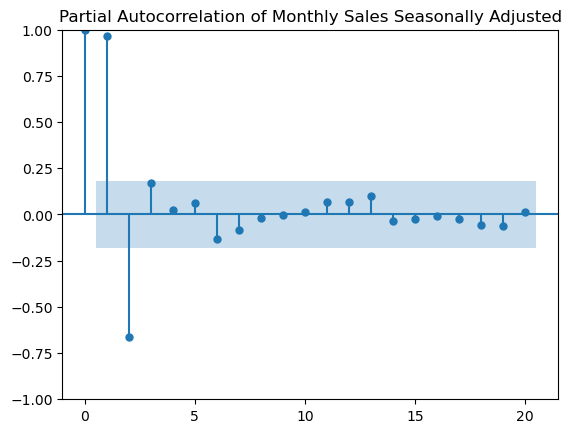

In [191]:
#Plot the PACF values
pacf_values_sales_data_seasonally_adjusted = plot_pacf(monthly_sales_data_seasonal_removed, lags = 20, title = 'Partial Autocorrelation of Monthly Sales Seasonally Adjusted')

In [192]:
#Orders for P
P_orders_sales_data = [1,2,3]

#### D order for Monthly Sales

In [193]:
#Check for stationarity
adf_test(monthly_sales_data_seasonal_removed)

ADF Statistic:  -2.2257177559947063
P-Value:  0.19704413721929226
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [194]:
#Get the difference of the seasonally adjusted data
sales_data['First Difference SA'] = sales_data['First Difference'].diff()
sales_data = sales_data[1::]
sales_data

Monthly Sales  Incrementing Month  First Difference  \
Month                                                             
2014-03-31      -2.961766                   3         -0.648561   
2014-04-30      -2.546422                   4          0.415344   
2014-05-31      -3.929142                   5         -1.382720   
2014-06-30      -5.149289                   6         -1.220147   
2014-07-31      -4.767102                   7          0.382187   
...                   ...                 ...               ...   
2023-08-31     -15.306840                 116         -1.571482   
2023-09-30     -15.505981                 117         -0.199141   
2023-10-31     -14.308235                 118          1.197747   
2023-11-30     -12.901095                 119          1.407139   
2023-12-31     -10.312717                 120          2.588378   

            First Difference SA  
Month                            
2014-03-31             1.065990  
2014-04-30             1.063905  
2014-05-31            -1.798064  
2014-06-30             0.162573  
2014-07-31             1.602334  
...                         ...  
2023-08-31             1.263064  
2023-09-30             1.372341  
2023-10-31             1.396888  
2023-11-30             0.209392  
2023-12-31             1.181239  

[118 rows x 4 columns]

In [195]:
#Find the adf statistic for stationarity
adf_test(sales_data['First Difference SA'])

ADF Statistic:  -8.141618042027657
P-Value:  1.0245349482492843e-12
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [196]:
#D order for sales data
D_order_sales_data = [1,2]

#### Parameters for Box Jenkins Models
- q: 1,2,3,4,5
- p: 1,2
- d: 0,1,2
- Q: 1,2,3,4,5
- P: 1,2,3
- D: 1,2
- s: 12

#### AR Model Selection

In [197]:
# Find the best AR model
# Returns p
select_best_ar_model(sales_data['Monthly Sales'],p_sales_data)

{'best_aic': 351.14322421580243,
 'best_aic_model': 3,
 'best_bic': 364.99664733813074,
 'best_bic_model': 3}

#### MA Model Selection

In [198]:
# Find the best MA model
# Returns q
select_best_ma_model(sales_data['Monthly Sales'],q_sales_data)

{'best_aic': 372.4369006136185,
 'best_aic_model': 5,
 'best_bic': 391.83169298487815,
 'best_bic_model': 5}

#### ARMA Model Selection

In [199]:
# Find the ARMA
# Returns p,q
select_best_arma_model(sales_data['Monthly Sales'],p_sales_data,q_sales_data)

{'best_aic': 346.4019191704487,
 'best_aic_model': (2, 1),
 'best_bic': 354.68844097484197,
 'best_bic_model': (2, 1)}

#### ARIMA Model Selection

In [200]:
# Find the ARIMA
# Returns p,d,qar_orders_temperature_fluctuations, ma_orders_temperature_fluctuations, i_orders_temperature_fluctuations
select_best_arima(sales_data['Monthly Sales'],p_sales_data, q_sales_data, d_orders_sales_data)

{'best_aic': 345.58994050864277,
 'best_aic_model': (3, 1, 3),
 'best_bic': 356.9928724047495,
 'best_bic_model': (1, 1, 1)}

In [201]:
#Find the SARIMA
# Returns p,d,q,P,D,Q,s
select_best_sarima_model(sales_data['Monthly Sales'],p_sales_data,d_orders_sales_data,q_sales_data,P_orders_sales_data,D_order_sales_data,Q_orders_sales_data,12)

{'aic': 345.1055473618359,
 'bic': 361.02930946278104,
 'pdq': (2, 1, 0),
 'seasonal_pdq': (2, 1, 1, 12)}

#### Best Model Selection
##### AR Model
AIC : 369.1
p : 2

BIC : 380.19
p : 2
##### MA Model
AIC : 372.44
q : 5

BIC : 391.44
q : 5
##### ARMA Model
AIC : 346.4
p : 2
q : 1

BIC : 354.4
p : 2,
q : 1
##### ARIMA Model
AIC : 346.75
p : 2,
d : 1,
q : 2

BIC : 356.00
p : 1,
d : 1,
q : 1

##### SARIMA Model
AIC :  345.11

BIC : 361.03

p : 2,
d : 1,
q : 0,
P : 2,
D : 2,
Q : 1,
s : 12

##### The Best Model is SARIMA
SARIMA  (2,1,0,2,2,1,12)

AIC : 345.11

## Exchange Rate Data
This sheet in the dataset includes two different columns, one of the exchange rates and one of the economic indicators. This is likely going to require the SARIMAX model to combine the two series

### Data Exploration
- Load the Data: Begin by loading each dataset from the Excel file.

- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components.

In [202]:
#Load in the exchange rates
exchange_rate = pd.read_excel('time_series_mixed_order.xlsx',sheet_name='Exchange Rates')
exchange_rate

Unnamed: 0  Exchange Rates  Economic Indicators
0             0       -0.201685            -0.222606
1             1        0.709373            -0.913079
2             2        1.004016            -1.681218
3             3       -0.841790            -0.888971
4             4       -2.238124             0.242118
..          ...             ...                  ...
115         115        1.510929             0.403265
116         116        1.478552            -0.918005
117         117        0.263802             0.252497
118         118        0.291200             0.820322
119         119       -0.516457             1.359949

[120 rows x 3 columns]

In [203]:
#Preprocess data
exchange_rate['Incrementing Month'] = range(1,len(exchange_rate)+1)
exchange_rate.drop(columns='Unnamed: 0', inplace=True)
exchange_rate['Month'] = pd.date_range('2014-01-01',periods=len(exchange_rate),freq='M')
exchange_rate.set_index('Month',inplace=True)
exchange_rate

Exchange Rates  Economic Indicators  Incrementing Month
Month                                                              
2014-01-31       -0.201685            -0.222606                   1
2014-02-28        0.709373            -0.913079                   2
2014-03-31        1.004016            -1.681218                   3
2014-04-30       -0.841790            -0.888971                   4
2014-05-31       -2.238124             0.242118                   5
...                    ...                  ...                 ...
2023-08-31        1.510929             0.403265                 116
2023-09-30        1.478552            -0.918005                 117
2023-10-31        0.263802             0.252497                 118
2023-11-30        0.291200             0.820322                 119
2023-12-31       -0.516457             1.359949                 120

[120 rows x 3 columns]

#### Time Interval Decision
As economic data is usually recorded on a monthly basis, as well as having 120 values (likely the past 10 years), the chosen time interval is going to be months.

In [204]:
import matplotlib.pyplot as plt

def multiple_time_series(series_list, title, xlabel, ylabel, legend_labels=['Exchange Rate','Economic Indicators']):
    plt.figure(figsize=(10, 6))
    for i, (xdata, ydata) in enumerate(series_list, start=1):
        label = f'Series {i}'
        if legend_labels and i <= len(legend_labels):
            label = legend_labels[i - 1]
        plt.plot(xdata, ydata, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

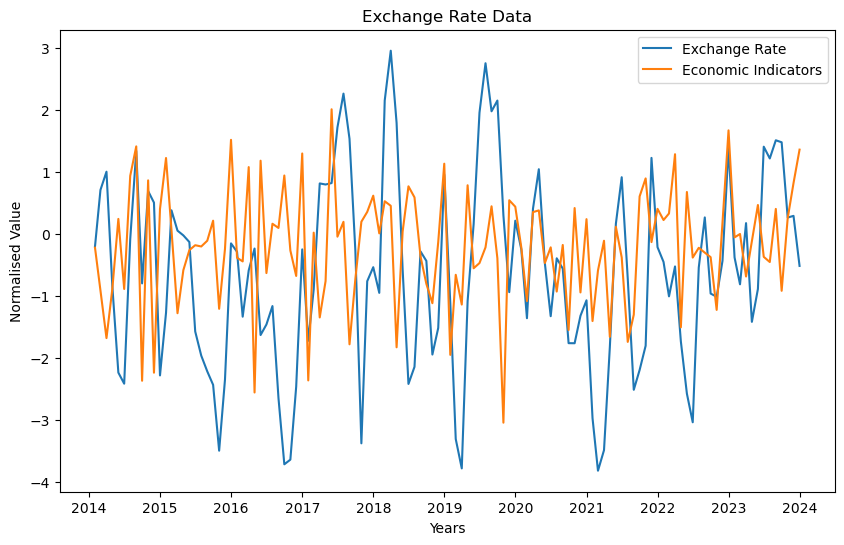

In [205]:
#Create a list of series to plot
list_series = [(exchange_rate.index,exchange_rate['Exchange Rates']),(exchange_rate.index,exchange_rate['Economic Indicators'])]

#Plot the time series
multiple_time_series(list_series,'Exchange Rate Data','Years','Normalised Value')

Notice that these values have been normalised as they move above and below zero. They also have similar trend, this can be explored by decomposing each of them individually.

#### Economic Exchange Rate Decomposition

In [206]:
#Seasonally decompose the exchange rates data into its individual components and save them as variables
monthly_exchange_rate_decomposition = decompose_seasonality(exchange_rate['Exchange Rates'],12)

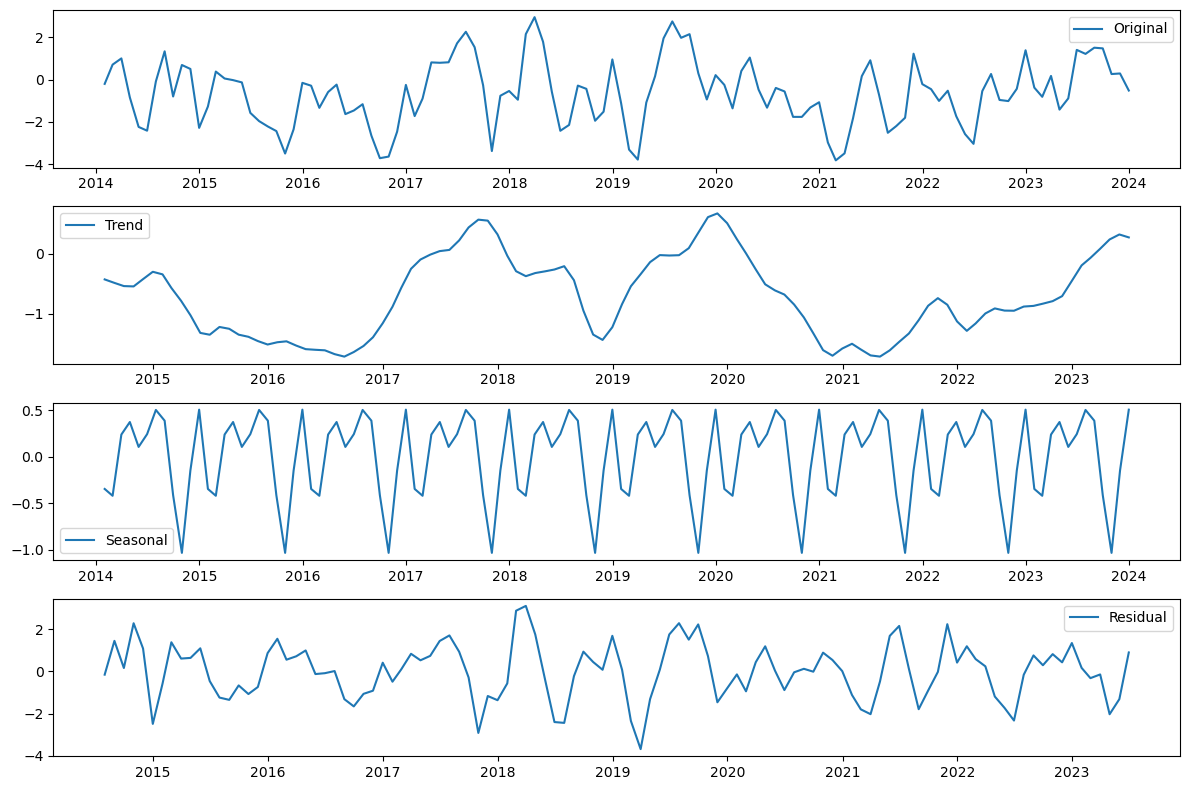

In [207]:
#Plot the variables as graphs
plot_seasonal_decomposition(exchange_rate['Exchange Rates'],12)

The seasonality does not look very clear so I am going to briefly look at the pacf plot to make sure that an assumption of 12 as the seasonality is ok.

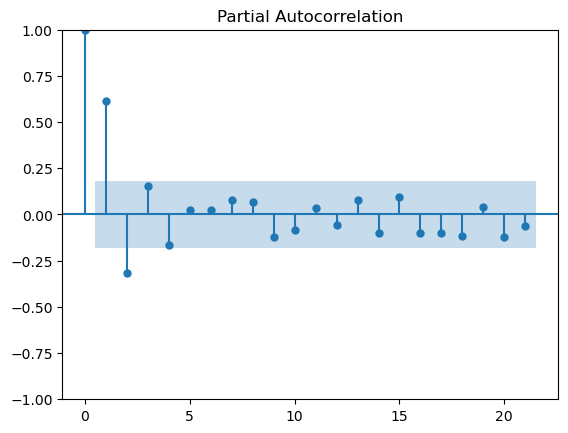

In [208]:
pacf_check = plot_pacf(exchange_rate['Exchange Rates'])

There is no clear pacf value which would suggest a strong seasonality, the seasonality that consists over a year is going to be the chosen time period. Let's go back to the decomposition

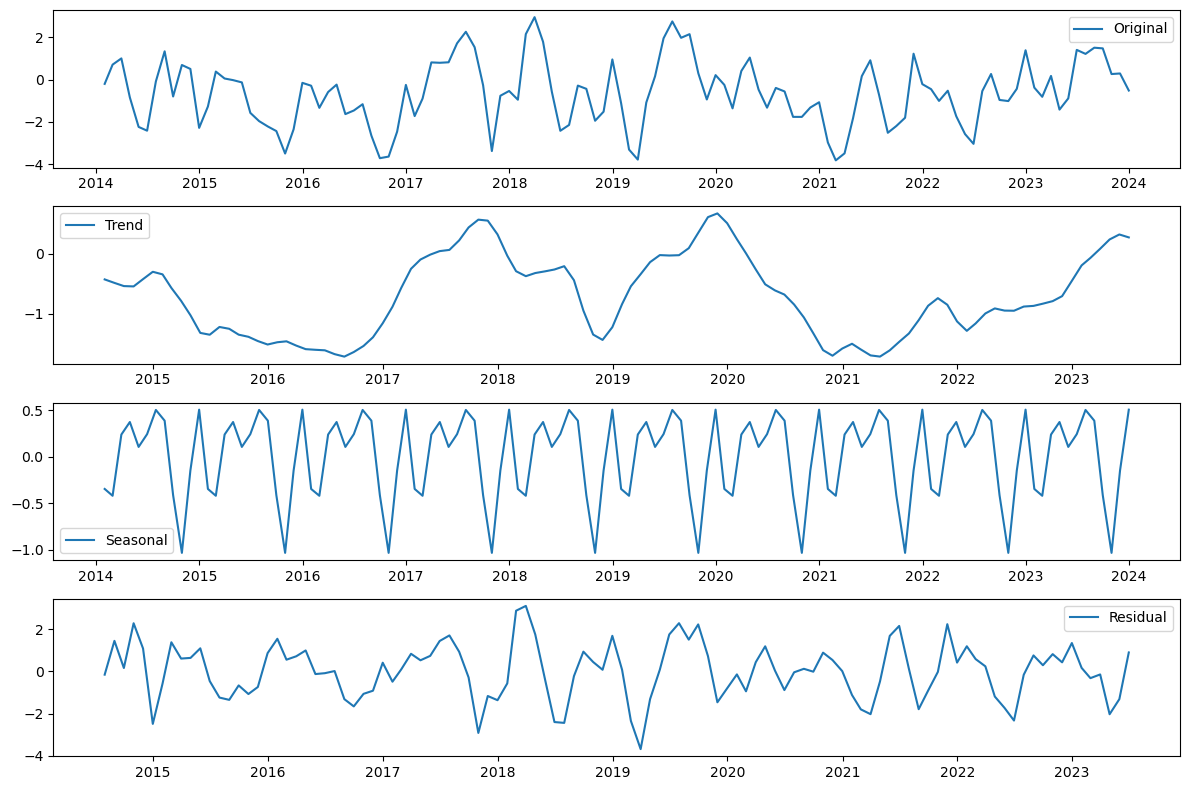

In [209]:
#Plot the seasonal decomposition
plot_seasonal_decomposition(exchange_rate['Exchange Rates'],12)

Trend - There is no overall change in values compared with time in the time series

Cycles - There seems to be a period of increase values from 2017 to 2019 which has a dip then a similar pattern is displayed where there is an increase from 2019 to 2021 which shows a lower pattern.

Seasonal - The seasonality looks to not follow a gradual trend and has a fair amount of volitality to the seasonal values.

Residual - The residual values are quite high but still are found to be around the mean of 0.

#### Seasonality Decomposition of Exchange Rate

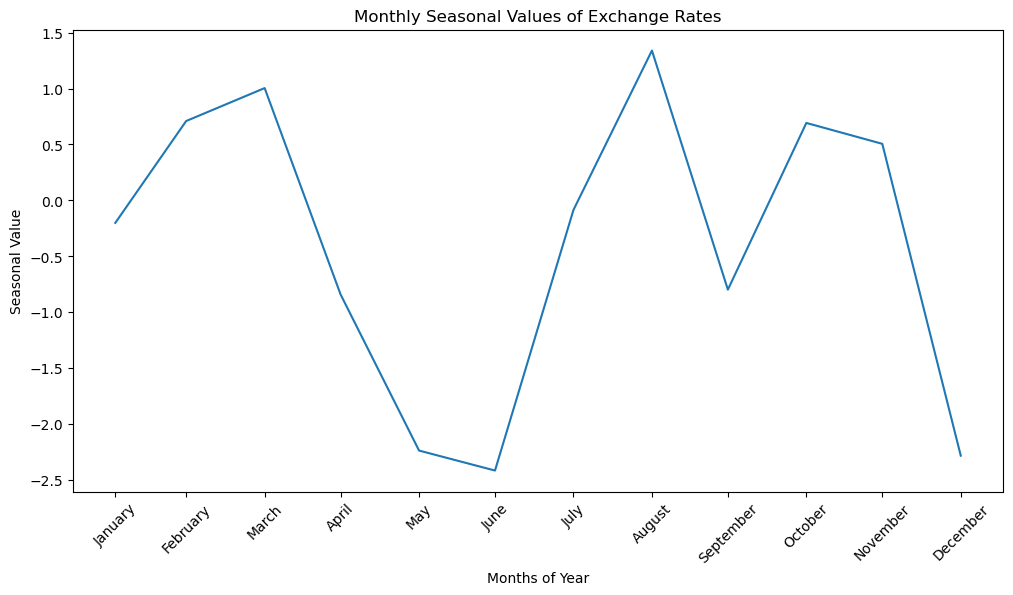

In [210]:
#Plot the seasonal values and observe them
seasonal_values_plot(exchange_rate,12,'Exchange Rates', 'Monthly Seasonal Values of Exchange Rates',
                     'Months of Year',months_list,'Seasonal Value')

The values do not really show much pattern, there is a decline from March to May and June before spiking back up in July through December before another trough.

In [211]:
#MAE for Exchange Rates
monthly_exchange_rate_decomposition[3].dropna(inplace=True)
zeros_108 = np.zeros(len(monthly_exchange_rate_decomposition[3]))
mean_absolute_error(zeros_108,monthly_exchange_rate_decomposition[3])

1.0280443944583608

The mean absolute error is better than it was before but is not quite as good as the earlier datasets. This gives confidence in that the seasonality might be the accurate interval (monthly)

In [212]:
#Create a new dataframe that converts monthly records into yearly with months as the column
#This is going to improve ease of drawing insightful statistics based on the month and the year
exchange_rate_monthly = create_monthly_data(exchange_rate,'Exchange Rates','Incrementing Month')
exchange_rate_monthly

January  February     March     April       May      June      July  \
0 -0.201685  0.709373  1.004016  -0.84179 -2.238124 -2.416825 -0.085768   
1 -1.272139  0.381197  0.052597 -0.023823 -0.131512 -1.574323 -1.964073   
2 -0.288412 -1.335706 -0.587805 -0.236462 -1.631956 -1.461817 -1.164194   
3 -1.725001 -0.895847  0.814691  0.797156  0.820454  1.719461  2.263722   
4  -0.95126  2.152891  2.956037  1.791128 -0.571141 -2.421233 -2.145237   
5 -1.118661  -3.31024 -3.783935 -1.084136  0.159157  1.955247  2.754012   
6 -0.249823 -1.360376  0.407277  1.043811 -0.472084 -1.327824 -0.393552   
7 -2.973619 -3.821428 -3.489853 -1.825974  0.163746  0.914683 -0.720352   
8  -0.45251 -1.008031 -0.525237 -1.734795 -2.577547 -3.039674  -0.54258   
9 -0.379861 -0.813181  0.173911 -1.418858 -0.888318  1.407541  1.217541   

     August September   October  November  December  
0  1.339646 -0.798689  0.692199  0.505337 -2.283625  
1  -2.21867 -2.435614 -3.498163  -2.35128 -0.152874  
2 -2.650396  -3.71788 -3.642755 -2.464171 -0.249852  
3  1.534952 -0.265197 -3.379367 -0.763652 -0.537176  
4  -0.28268 -0.435992  -1.94632 -1.517616  0.955887  
5  1.978593   2.15198  0.298857 -0.939624  0.213052  
6 -0.560255 -1.763131 -1.764241 -1.321196 -1.071166  
7 -2.515857 -2.196593 -1.804877  1.226756  -0.21394  
8  0.266025  -0.96232 -1.015109 -0.434191  1.389419  
9  1.510929  1.478552  0.263802    0.2912 -0.516457

#### Finding mean, median, variance and standard deviation

In [213]:
#Create statistical table using the function above
exchange_rate_statistics = mean_median_variance_std_monthly(exchange_rate_monthly,months_list)
exchange_rate_statistics

January  February     March     April       May  \
0                  -0.201685  0.709373  1.004016  -0.84179 -2.238124   
1                  -1.272139  0.381197  0.052597 -0.023823 -0.131512   
2                  -0.288412 -1.335706 -0.587805 -0.236462 -1.631956   
3                  -1.725001 -0.895847  0.814691  0.797156  0.820454   
4                   -0.95126  2.152891  2.956037  1.791128 -0.571141   
5                  -1.118661  -3.31024 -3.783935 -1.084136  0.159157   
6                  -0.249823 -1.360376  0.407277  1.043811 -0.472084   
7                  -2.973619 -3.821428 -3.489853 -1.825974  0.163746   
8                   -0.45251 -1.008031 -0.525237 -1.734795 -2.577547   
9                  -0.379861 -0.813181  0.173911 -1.418858 -0.888318   
Mean               -0.961297 -0.930135  -0.29783 -0.353374 -0.736733   
Median              -0.95126 -0.930135  0.052597 -0.353374 -0.571141   
Variance            0.626107   2.57342  3.359361  1.271064  0.999488   
Standard Deviation  0.876106  1.817468  2.022844  1.169669   1.06977   

                        June      July    August September   October  \
0                  -2.416825 -0.085768  1.339646 -0.798689  0.692199   
1                  -1.574323 -1.964073  -2.21867 -2.435614 -3.498163   
2                  -1.461817 -1.164194 -2.650396  -3.71788 -3.642755   
3                   1.719461  2.263722  1.534952 -0.265197 -3.379367   
4                  -2.421233 -2.145237  -0.28268 -0.435992  -1.94632   
5                   1.955247  2.754012  1.978593   2.15198  0.298857   
6                  -1.327824 -0.393552 -0.560255 -1.763131 -1.764241   
7                   0.914683 -0.720352 -2.515857 -2.196593 -1.804877   
8                  -3.039674  -0.54258  0.266025  -0.96232 -1.015109   
9                   1.407541  1.217541  1.510929  1.478552  0.263802   
Mean               -0.624477 -0.078048 -0.159771 -0.894488 -1.579597   
Median             -1.327824 -0.393552 -0.159771 -0.894488 -1.764241   
Variance            3.042969  2.273843  2.621308  2.575356  2.166699   
Standard Deviation  1.964014  1.587266  1.731421  1.812976   1.75346   

                    November  December  Monthly Mean  Monthly Median  \
0                   0.505337 -2.283625     -0.659419       -0.143726   
1                   -2.35128 -0.152874     -2.169811       -1.423231   
2                  -2.464171 -0.249852     -2.775915       -1.398761   
3                  -0.763652 -0.537176      0.054885        0.265980   
4                  -1.517616  0.955887     -0.345077       -0.503567   
5                  -0.939624  0.213052     -0.103671        0.186105   
6                  -1.321196 -1.071166     -1.261794       -0.815710   
7                   1.226756  -0.21394     -2.465330       -1.815425   
8                  -0.434191  1.389419     -1.519507       -0.752450   
9                     0.2912 -0.516457      0.332400        0.218857   
Mean               -0.776844 -0.246673           NaN             NaN   
Median             -0.776844 -0.246673           NaN             NaN   
Variance            1.192199   0.84821           NaN             NaN   
Standard Deviation  1.179445  0.932598           NaN             NaN   

                    Standard Deviation  Variance  
0                             1.339083  1.793143  
1                             1.262733  1.594495  
2                             1.250845  1.564614  
3                             1.610687  2.594312  
4                             1.785435  3.187777  
5                             2.103138  4.423188  
6                             0.865299  0.748742  
7                             1.691860  2.862390  
8                             1.183304  1.400209  
9                             1.024279  1.049147  
Mean                               NaN       NaN  
Median                             NaN       NaN  
Variance                           NaN       NaN  
Standard Deviation                 NaN       NaN

The dataframe creates statistical information for both months of the year and incremental years to observe how the data changes over time.

#### Yearly Mean for Exchange Rate

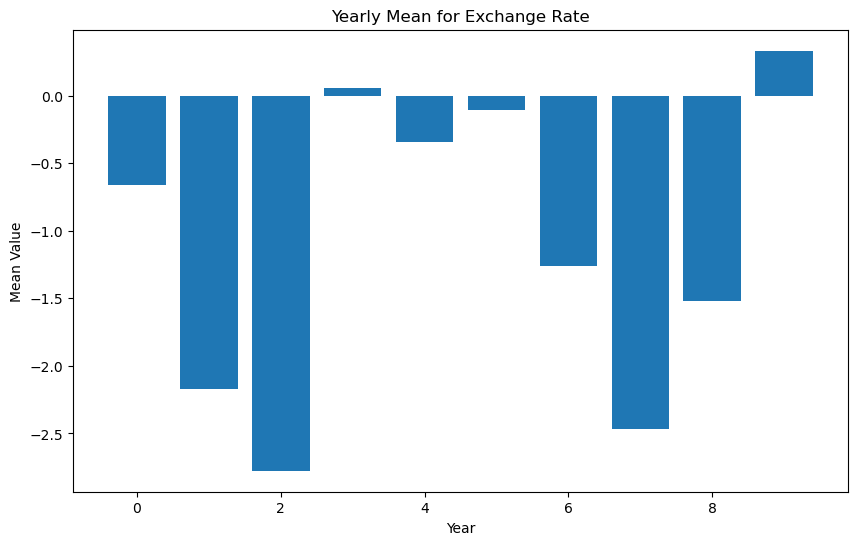

In [214]:
#Create a bar chart of the mean of the values from years 1-10
bar_chart(exchange_rate_statistics.index[0:10],exchange_rate_statistics['Monthly Mean'][0:10],
          'Yearly Mean for Exchange Rate', 'Year', 'Mean Value')

#### Yearly Median for Exchange Rate

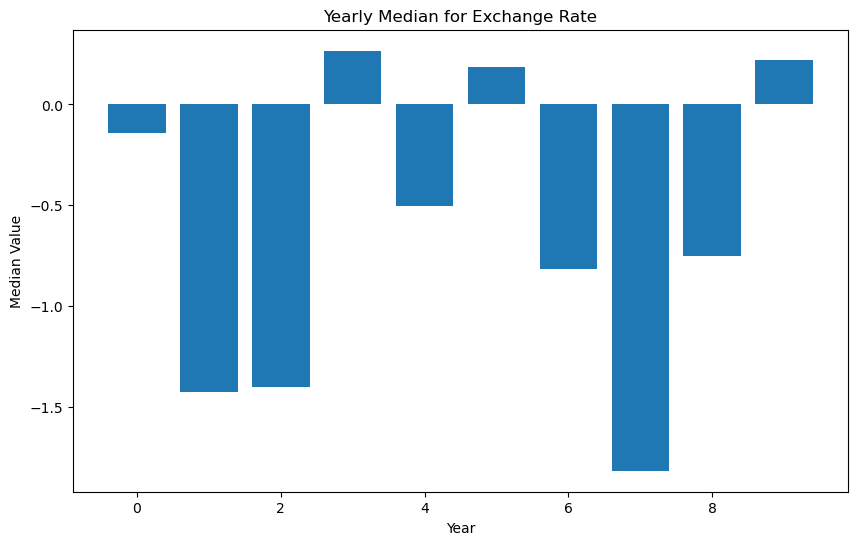

In [215]:
#Create a bar chart of the median for the value from years 1-10
bar_chart(exchange_rate_statistics.index[0:10],exchange_rate_statistics['Monthly Median'][0:10],
          'Yearly Median for Exchange Rate','Year', 'Median Value')

#### Yearly Variance for Exchange Rate

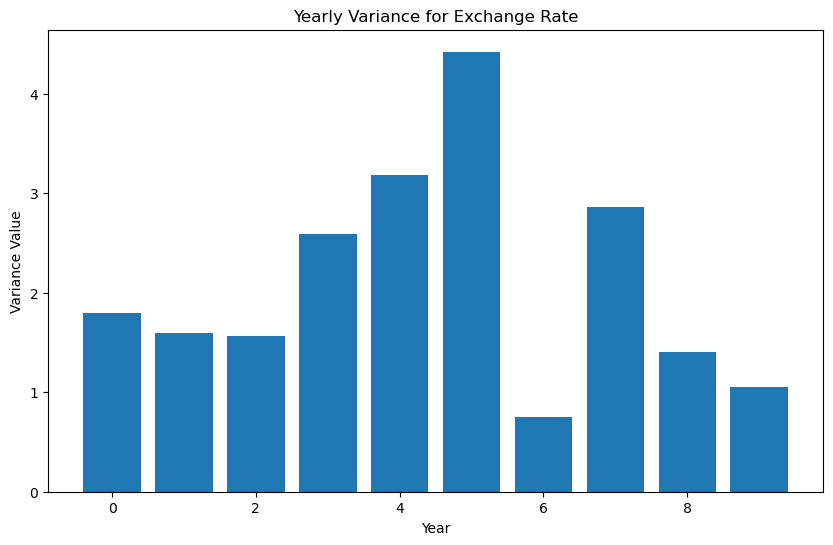

In [216]:
#Create a bar chart of the median for the value from years 1-10
bar_chart(exchange_rate_statistics.index[0:10],exchange_rate_statistics['Variance'][0:10],
          'Yearly Variance for Exchange Rate','Year', 'Variance Value')

#### Yearly Standard Deviation for Exchange Rate

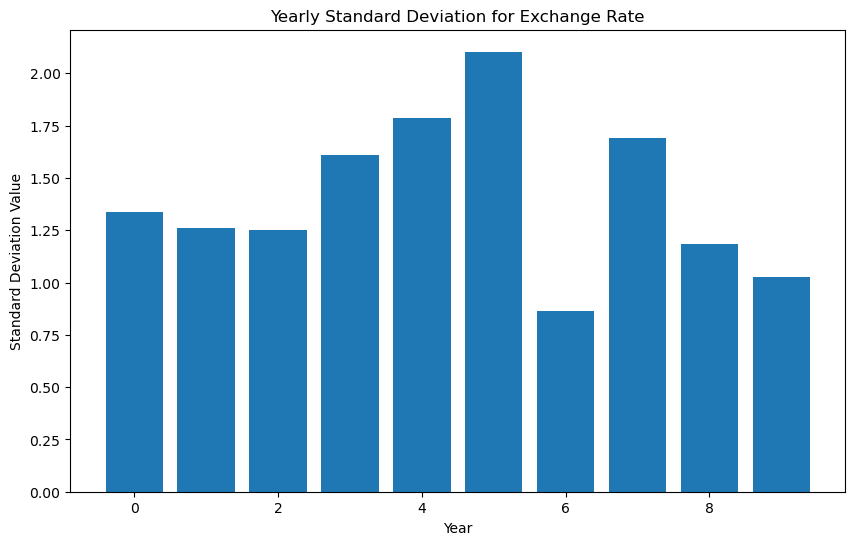

In [217]:
#Create a bar chart of the median for the value from years 1-10
bar_chart(exchange_rate_statistics.index[0:10],exchange_rate_statistics['Standard Deviation'][0:10],
          'Yearly Standard Deviation for Exchange Rate','Year', 'Standard Deviation Value')

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### q Orders for Exchange Rate

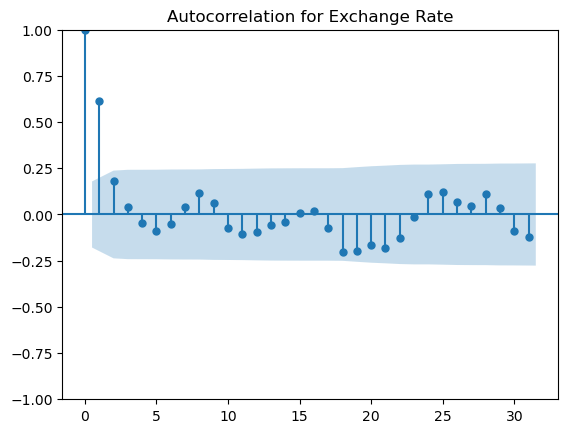

In [218]:
#Plot the ACF values
acf_values_exchange_rate = plot_acf(exchange_rate['Exchange Rates'],lags=31,title='Autocorrelation for Exchange Rate')

In [219]:
#Create the q order
q_orders_exchange_rate = [1,2,8,16]

#### p Orders for Exchange Rate

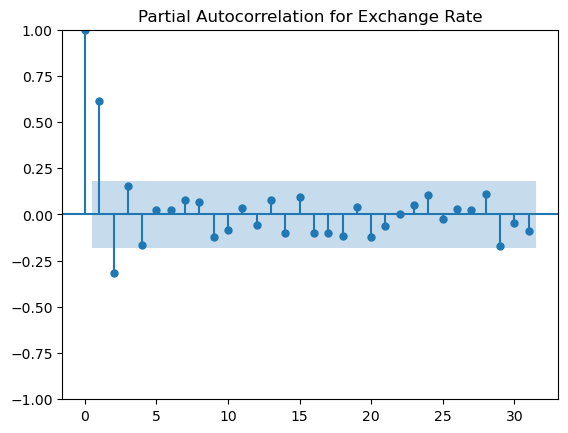

In [220]:
#Plot the PACF values
pacf_values_exchange_rate = plot_pacf(exchange_rate['Exchange Rates'],lags='31',title='Partial Autocorrelation for Exchange Rate')

In [221]:
#Create the p order
p_orders_exchange_rate = [1,2,4,16]

#### d Orders for Exchange Rate

In [222]:
#ADF test for exchange rates
adf_test(exchange_rate['Exchange Rates'])

ADF Statistic:  -5.0780110651199735
P-Value:  1.551873595681542e-05
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [223]:
#d orders
d_order_exchange_rate = [0,1]

#### Removing Seasonality from Data for P,D,Q

In [224]:
#Create a new series which has the seasonal components removed from the data
monthly_exchange_rate_seasonally_adjusted = monthly_exchange_rate_decomposition[0] - monthly_exchange_rate_decomposition[2]
monthly_exchange_rate_seasonally_adjusted

Month
2014-01-31    0.144338
2014-02-28    1.128827
2014-03-31    0.764983
2014-04-30   -1.215637
2014-05-31   -2.344140
                ...   
2023-08-31    1.122794
2023-09-30    1.892279
2023-10-31    1.297276
2023-11-30    0.439346
2023-12-31   -1.023174
Length: 120, dtype: float64

#### Q Orders for Exchange Rate

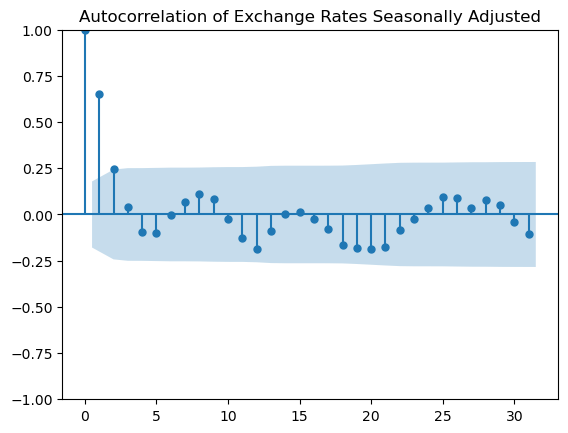

In [225]:
#Plot the new acf 
acf_values_exchange_rate_seasonally_adjusted = plot_acf(monthly_exchange_rate_seasonally_adjusted,lags=31,title='Autocorrelation of Exchange Rates Seasonally Adjusted')

In [226]:
#Q orders
Q_orders_exchange_rate = [1,2,8,20]

#### P Orders for Exchange Rate

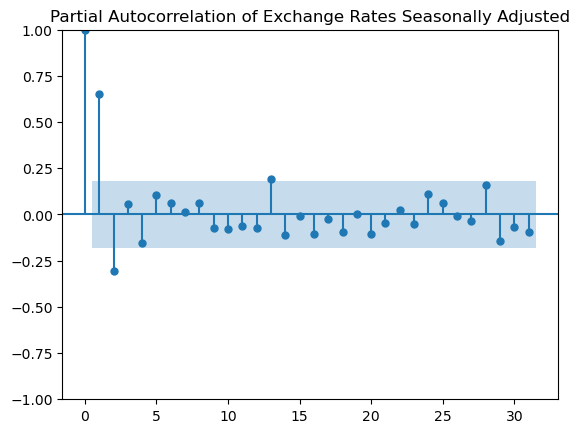

In [227]:
#Plot the new pacf
pacf_values_exchange_rate_seasonally_adjusted = plot_pacf(monthly_exchange_rate_seasonally_adjusted, lags=31,title='Partial Autocorrelation of Exchange Rates Seasonally Adjusted')

In [228]:
#P orders
P_orders_exchange_rate = [1,2,4,14]

#### D Orders for Exchange Rate

In [229]:
#Check ADF statistic
adf_test(monthly_exchange_rate_seasonally_adjusted)

ADF Statistic:  -6.254825680637863
P-Value:  4.364719269207996e-08
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [230]:
#D orders
D_order_exchange_rate = [0,1]

#### Parameters for Box Jenkins Models
- q : 1,2,8,16
- p : 1,2,4,16
- d : 0,1
- Q : 1,2,8,20
- P : 1,2,4,14
- D : 0,1
- s : 12

#### AR Model Selection

In [231]:
#Find the best AR model
#Returns p 
select_best_ar_model(exchange_rate['Exchange Rates'],p_orders_exchange_rate)

{'best_aic': 378.40015248568994,
 'best_aic_model': 4,
 'best_bic': 391.62799576571973,
 'best_bic_model': 2}

#### MA Model Selection

In [232]:
#Find the best MA model
#Returns q
select_best_ma_model(exchange_rate['Exchange Rates'], q_orders_exchange_rate)

{'best_aic': 375.58602608646333,
 'best_aic_model': 2,
 'best_bic': 386.73599305759154,
 'best_bic_model': 2}

#### ARMA Model Selection

In [233]:
#Find the best ARMA model
#Returns p,q
select_best_arma_model(exchange_rate['Exchange Rates'],p_orders_exchange_rate,q_orders_exchange_rate)

{'best_aic': 393.2146703472822,
 'best_aic_model': (4, 1),
 'best_bic': 402.91136520630727,
 'best_bic_model': (2, 1)}

#### ARIMA Model Selection

In [234]:
#Find the best ARIMA model
#Returns p,d,q
select_best_arima(exchange_rate['Exchange Rates'],p_orders_exchange_rate,q_orders_exchange_rate,d_order_exchange_rate)

{'best_aic': 375.3509130761571,
 'best_aic_model': (1, 0, 1),
 'best_bic': 386.5008800472853,
 'best_bic_model': (1, 0, 1)}

#### SARIMA Model Selection

In [235]:
#Find the best SARIMA model
#Returns p,d,q,P,D,Q,s
select_best_sarima_model(exchange_rate['Exchange Rates'],p_orders_exchange_rate,d_order_exchange_rate,q_orders_exchange_rate,P_orders_exchange_rate,D_order_exchange_rate,Q_orders_exchange_rate,12)

{'aic': 375.1906337435057,
 'bic': 391.915584200198,
 'pdq': (1, 0, 1),
 'seasonal_pdq': (2, 0, 0, 12)}

#### SARIMAX Model Selection

In [286]:
sarimax_model = SARIMAX(endog=exchange_rate['Exchange Rates'], exog=exchange_rate['Economic Indicators'], order=(1,0, 1), seasonal_order=(2, 0, 0, 12))
sarimax_result = sarimax_model.fit()
print(f'aic: {sarimax_result.aic}')
print(f'bic: {sarimax_result.bic}')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55471D+00    |proj g|=  2.48244D-01

At iterate    5    f=  1.52532D+00    |proj g|=  8.69893D-03

At iterate   10    f=  1.52528D+00    |proj g|=  1.40934D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     14      1     0     0   1.409D-06   1.525D+00
  F =   1.5252812656593440     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
aic: 378.06750375824254
bic: 394.7924542149348


#### Best Model Selection
##### AR Model
AIC : 378.40
p : 4

BIC : 391.63
p : 2
##### MA Model
AIC : 375.59
q : 2

BIC : 386.74
q : 2
##### ARMA Model
AIC : 393.21
p : 4,
q : 1

BIC : 402.91
p : 2,
q : 1
##### ARIMA Model
AIC : 375.35
p : 1,
d : 0,
q : 1

BIC : 386.50
p : 1,
d : 0,
q : 1

##### SARIMA Model
AIC :  375.19

BIC : 391.92

p : 1,
d : 0,
q : 1,
P : 2,
D : 0,
Q : 0,
s : 12

##### SARIMAX Model

AIC : 378.07

BIC : 394.80

##### The Best Model is SARIMA
SARIMA (1,0,1,2,0,0,12)

AIC : 375.19

## Economic Indicators

This is the second part of the Exchange Rates dataset. 

#### Data Exploration
- Load the Data: Begin by loading each dataset from the Excel file.
- Visualize the Data: Plot each time series to understand its trend, seasonality, and noise components 

In [236]:
# Seasonally decompose the economic indicators data into its individual components and save them as variables
monthly_economic_indicators_decomposition = decompose_seasonality(exchange_rate['Economic Indicators'],12)

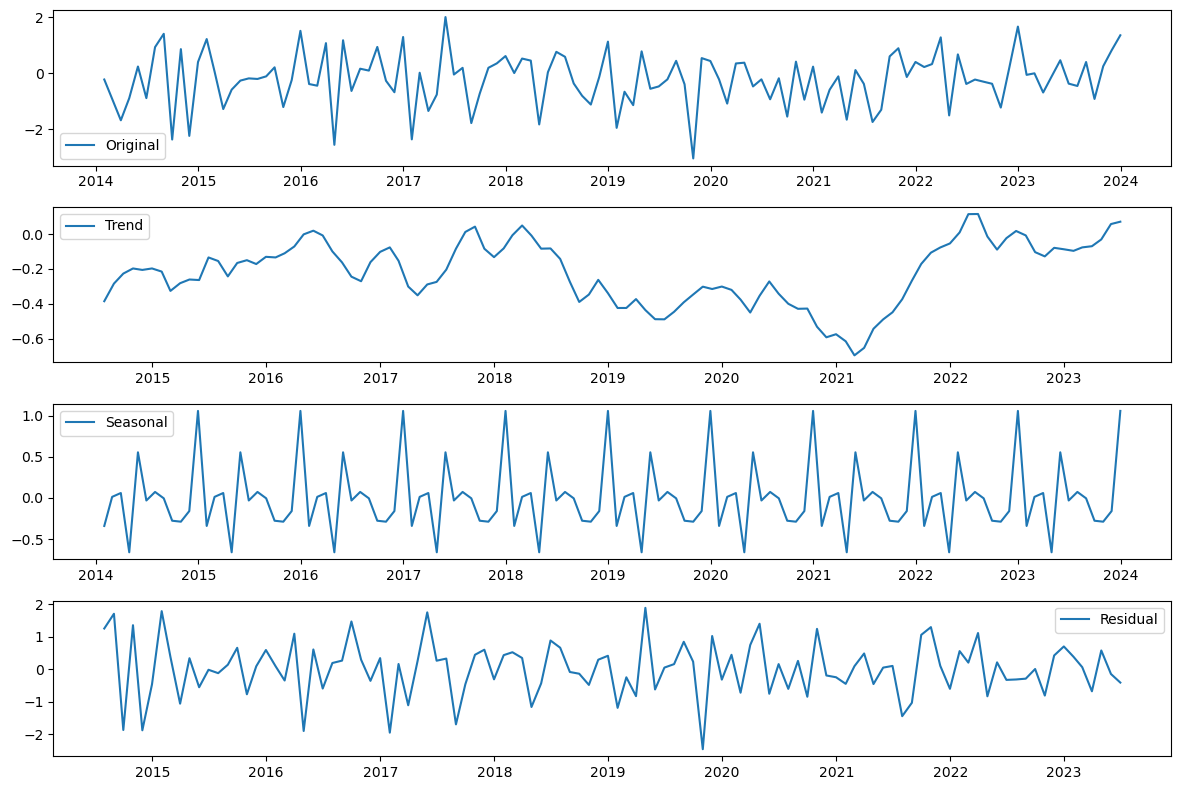

In [237]:
# Plot the variables as graphs
plot_seasonal_decomposition(exchange_rate['Economic Indicators'],12)

Trend - There is no real increase or decrease in values over time, this is likely a stationary graph.

Cycles - If you look at the axis of the trend it is quite small, the only real movement is following a dip in 2021 to a growth to 2022 and maintained performance

Seasonal - This is quite volitale similar to exchange rates

Residual - The residual looks quite similar to white noise but is quite high

#### Seasonality Decomposition of Economic Indicators

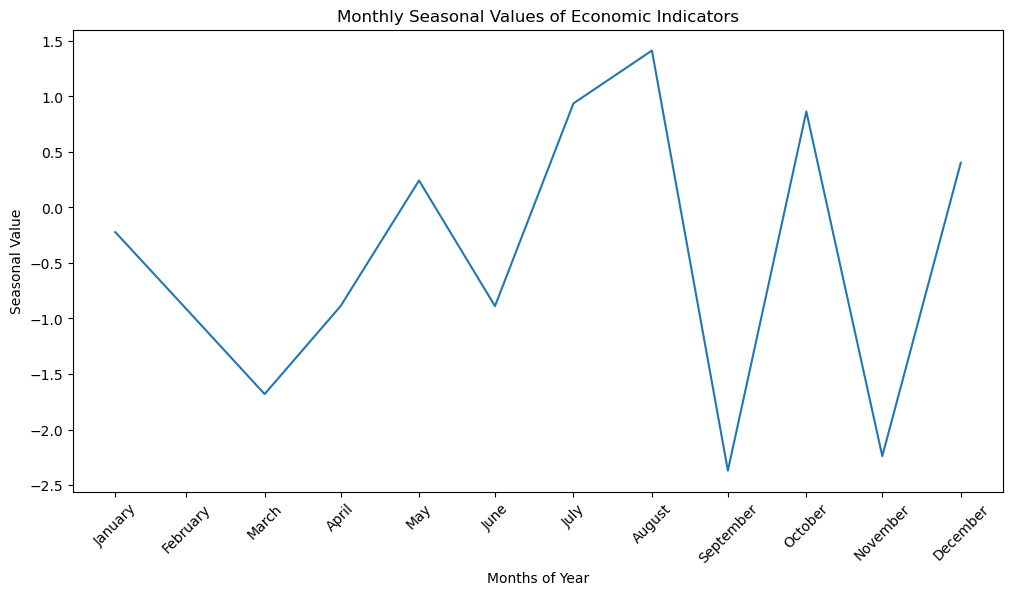

In [238]:
# Plot the seasonal values and observe them
seasonal_values_plot(exchange_rate,12,'Economic Indicators', 'Monthly Seasonal Values of Economic Indicators', 'Months of Year',months_list,'Seasonal Value')

In [239]:
# MAE for Economic Indicators 
monthly_economic_indicators_decomposition[3].dropna(inplace=True)
zeros_108 = np.zeros(len(monthly_economic_indicators_decomposition[3]))
mean_absolute_error(zeros_108,monthly_economic_indicators_decomposition[3])

0.6507277202645544

The MAE is quite low comparitavely to the other graphs however the maximum values are much smaller as well so it is not that great of a value.

In [240]:
#Create a new dataframe that converts monthly records into yearly with months as the column
#This is going to improve ease of drawing insightful statistics based on the month and the year
exchange_rate_monthly = create_monthly_data(exchange_rate,'Economic Indicators','Incrementing Month')
exchange_rate_monthly

January  February     March     April       May      June      July  \
0 -0.222606 -0.913079 -1.681218 -0.888971  0.242118  -0.88872  0.936742   
1  1.224871  0.064856 -1.279689 -0.585431 -0.261645 -0.182245 -0.202897   
2 -0.384645 -0.443836  1.078197 -2.559185  1.181379 -0.631904  0.163929   
3 -2.364174  0.020334 -1.347925 -0.761573  2.011257 -0.044595   0.19507   
4  0.008628  0.527004  0.453782  -1.82974  0.037006  0.767902   0.58988   
5 -1.951804 -0.659892 -1.139802  0.784958  -0.55431 -0.470638  -0.21695   
6 -0.219541 -1.084037   0.35178  0.379236 -0.470033 -0.216731 -0.930157   
7 -1.405963 -0.590058 -0.110489   -1.6607  0.115148 -0.379148 -1.742356   
8  0.223844  0.329623  1.285984 -1.506998  0.676461 -0.382009 -0.224259   
9 -0.056133 -0.001385 -0.687299 -0.117475  0.466166 -0.370242 -0.453804   

     August September   October  November  December  
0  1.412328 -2.369587  0.864052 -2.239604  0.401499  
1 -0.109883   0.21348 -1.208574  -0.24202  1.518261  
2  0.096321  0.942468 -0.267595 -0.678026  1.297846  
3 -1.781563 -0.729045  0.196557  0.354758  0.616887  
4 -0.363859 -0.805627 -1.118312 -0.131054   1.13308  
5  0.445393 -0.392389 -3.046143  0.543312  0.439043  
6 -0.178589 -1.550429  0.417319 -0.944368  0.238103  
7 -1.303243   0.60512  0.895556 -0.131909  0.404762  
8  -0.30225 -0.375147 -1.226196  0.183339  1.670943  
9  0.403265 -0.918005  0.252497  0.820322  1.359949

#### Finding mean, median, variance and standard deviation

In [241]:
#Create statistical table using the function above
economic_indicators_statistics = mean_median_variance_std_monthly(exchange_rate_monthly,months_list)
economic_indicators_statistics

January  February     March     April       May  \
0                  -0.222606 -0.913079 -1.681218 -0.888971  0.242118   
1                   1.224871  0.064856 -1.279689 -0.585431 -0.261645   
2                  -0.384645 -0.443836  1.078197 -2.559185  1.181379   
3                  -2.364174  0.020334 -1.347925 -0.761573  2.011257   
4                   0.008628  0.527004  0.453782  -1.82974  0.037006   
5                  -1.951804 -0.659892 -1.139802  0.784958  -0.55431   
6                  -0.219541 -1.084037   0.35178  0.379236 -0.470033   
7                  -1.405963 -0.590058 -0.110489   -1.6607  0.115148   
8                   0.223844  0.329623  1.285984 -1.506998  0.676461   
9                  -0.056133 -0.001385 -0.687299 -0.117475  0.466166   
Mean               -0.514752 -0.275047 -0.307668 -0.874588  0.344355   
Median             -0.222606 -0.275047 -0.307668 -0.874588  0.242118   
Variance            0.963952  0.238542  0.933098  0.887643  0.509945   
Standard Deviation  1.022901  0.488829  0.986794  1.025941  0.685406   

                        June      July    August September   October  \
0                   -0.88872  0.936742  1.412328 -2.369587  0.864052   
1                  -0.182245 -0.202897 -0.109883   0.21348 -1.208574   
2                  -0.631904  0.163929  0.096321  0.942468 -0.267595   
3                  -0.044595   0.19507 -1.781563 -0.729045  0.196557   
4                   0.767902   0.58988 -0.363859 -0.805627 -1.118312   
5                  -0.470638  -0.21695  0.445393 -0.392389 -3.046143   
6                  -0.216731 -0.930157 -0.178589 -1.550429  0.417319   
7                  -0.379148 -1.742356 -1.303243   0.60512  0.895556   
8                  -0.382009 -0.224259  -0.30225 -0.375147 -1.226196   
9                  -0.370242 -0.453804  0.403265 -0.918005  0.252497   
Mean               -0.279833  -0.18848 -0.168208 -0.537916 -0.424084   
Median             -0.370242 -0.202897 -0.168208 -0.537916 -0.267595   
Variance            0.157606  0.470979  0.656557  0.794837  1.237687   
Standard Deviation  0.399629  0.682133  0.808808  0.930179  1.159158   

                    November  December  Monthly Mean  Monthly Median  \
0                  -2.239604  0.401499     -0.763864       -0.555663   
1                   -0.24202  1.518261     -0.150131       -0.192571   
2                  -0.678026  1.297846     -0.029293       -0.085637   
3                   0.354758  0.616887     -0.519145       -0.012131   
4                  -0.131054   1.13308     -0.104473        0.022817   
5                   0.543312  0.439043     -0.888460       -0.431513   
6                  -0.944368  0.238103     -0.601064       -0.218136   
7                  -0.131909  0.404762     -0.757611       -0.255528   
8                   0.183339  1.670943      0.050476       -0.020460   
9                   0.820322  1.359949      0.099694       -0.028759   
Mean               -0.246525  0.908037           NaN             NaN   
Median             -0.131909  0.908037           NaN             NaN   
Variance            0.635673  0.238602           NaN             NaN   
Standard Deviation  0.800798  0.503181           NaN             NaN   

                    Standard Deviation  Variance  
0                             1.256858  1.579692  
1                             0.821177  0.674331  
2                             1.086632  1.180769  
3                             1.176351  1.383802  
4                             0.855953  0.732655  
5                             1.113234  1.239289  
6                             0.654160  0.427926  
7                             0.904131  0.817453  
8                             0.918907  0.844390  
9                             0.646710  0.418234  
Mean                               NaN       NaN  
Median                             NaN       NaN  
Variance                           NaN       NaN  
Standard Deviation                 NaN       NaN

#### Yearly Mean for Economic Indicators

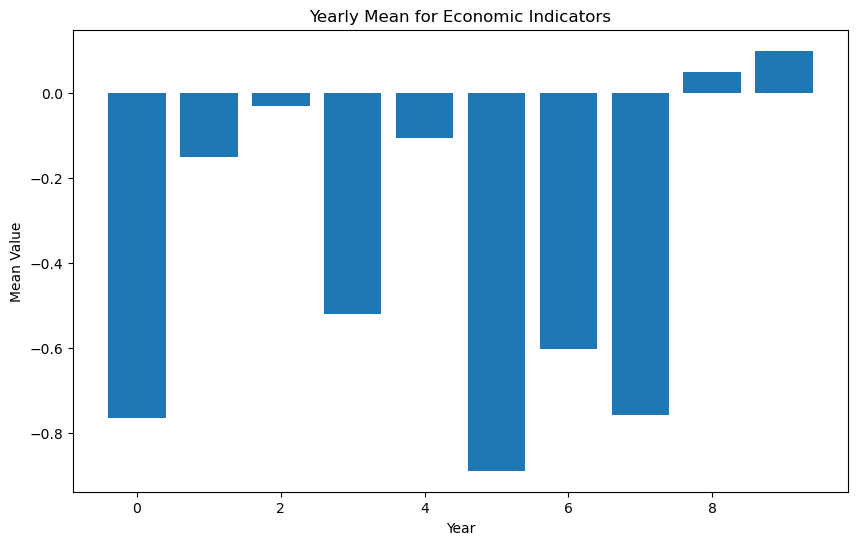

In [242]:
#Create a bar chart of the mean of the values from years 1-10
bar_chart(economic_indicators_statistics.index[0:10],economic_indicators_statistics['Monthly Mean'][0:10],
          'Yearly Mean for Economic Indicators', 'Year', 'Mean Value')

The mean has higher values in years 5 through 8 similar to that in year 1. While the other values have a mean that approach close to 0.

#### Yearly Median for Exchange Rate

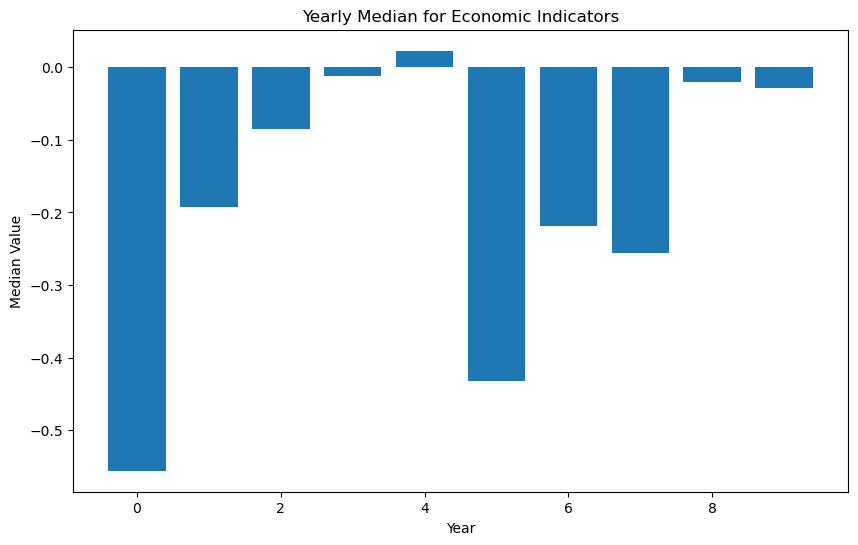

In [243]:
#Create a bar chart of the median for the value from years 1-10
bar_chart(economic_indicators_statistics.index[0:10],economic_indicators_statistics['Monthly Median'][0:10],
          'Yearly Median for Economic Indicators','Year', 'Median Value')

The median value is much higher for year 1 than the rest suggesting that there is a smaller values in year 1 that reduces the mean

#### Yearly Variance

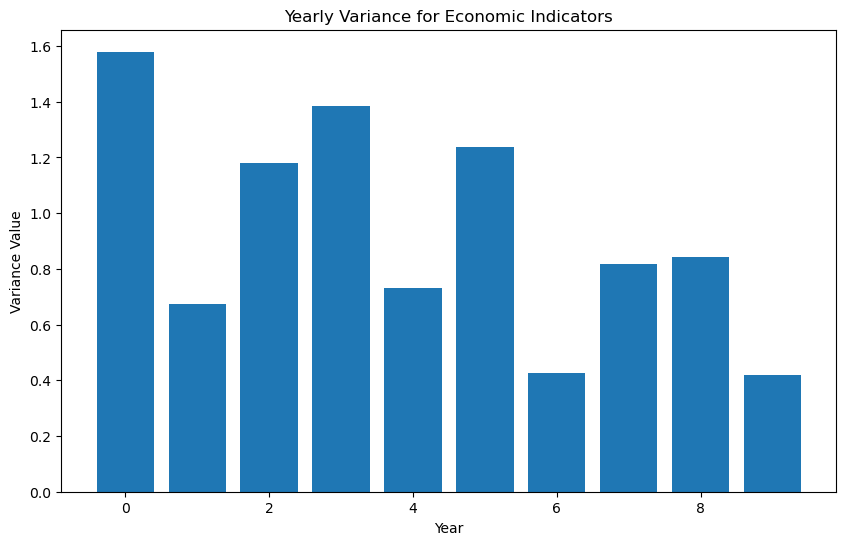

In [244]:
#Create a bar chart of the median for the value from years 1-10
bar_chart(economic_indicators_statistics.index[0:10],economic_indicators_statistics['Variance'][0:10],
          'Yearly Variance for Economic Indicators','Year', 'Variance Value')

The variance is quite symmetrical across all data values

#### Yearly Standard Deviation

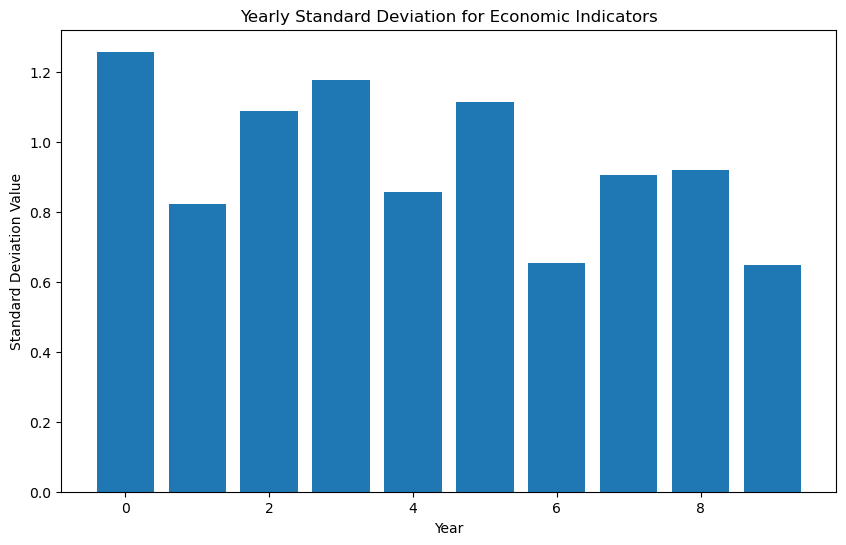

In [245]:
#Create a bar chart of the median for the value from years 1-10
bar_chart(economic_indicators_statistics.index[0:10],economic_indicators_statistics['Standard Deviation'][0:10],
          'Yearly Standard Deviation for Economic Indicators','Year', 'Standard Deviation Value')

The standard deviation is symmetrical

### Model Identification
- ACF and PACF Plots: Generate Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for each dataset to identify potential AR and MA components.

- Model Fitting: Fit different ARIMA models based on the insights from ACF and PACF plots and use criteria like AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) to select the best model.

#### q Orders for Exchange Rate

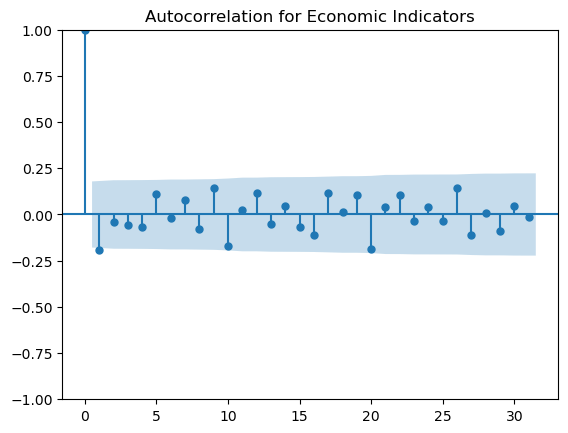

In [246]:
acf_values_economic_indicators = plot_acf(exchange_rate['Economic Indicators'],lags =31,title='Autocorrelation for Economic Indicators')

In [247]:
#Create the q order
q_orders_economic_indicators = [1,10,20]

#### p Orders for Exchange Rate

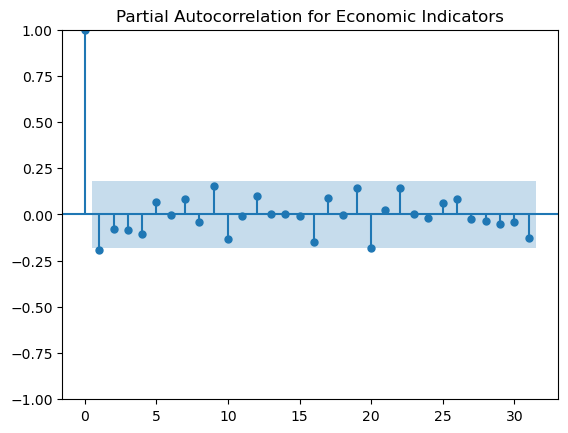

In [248]:
#Plot the PACF values
pacf_values_economic_indicators = plot_pacf(exchange_rate['Economic Indicators'],lags=31,title='Partial Autocorrelation for Economic Indicators')

In [249]:
#Create the p order
p_orders_economic_indicators = [1,9,20]

#### d Orders for Exchange Rate

In [250]:
#ADF test for exchange rates
adf_test(exchange_rate['Economic Indicators'])

ADF Statistic:  -13.026784378197792
P-Value:  2.3904318564645963e-24
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [251]:
#d orders
d_order_economic_indicators = [0,1]

#### Removing Seasonality from Data for P,D,Q

In [252]:
#Create a new series which has the seasonal components removed from the data
monthly_economic_indicators_seasonally_adjusted = monthly_economic_indicators_decomposition[0] - monthly_economic_indicators_decomposition[2]
monthly_economic_indicators_seasonally_adjusted

Month
2014-01-31    0.118291
2014-02-28   -0.926350
2014-03-31   -1.741544
2014-04-30   -0.227469
2014-05-31   -0.313749
                ...   
2023-08-31    0.407649
2023-09-30   -0.640819
2023-10-31    0.541431
2023-11-30    0.979669
2023-12-31    0.299845
Length: 120, dtype: float64

#### Q Orders for Exchange Rate

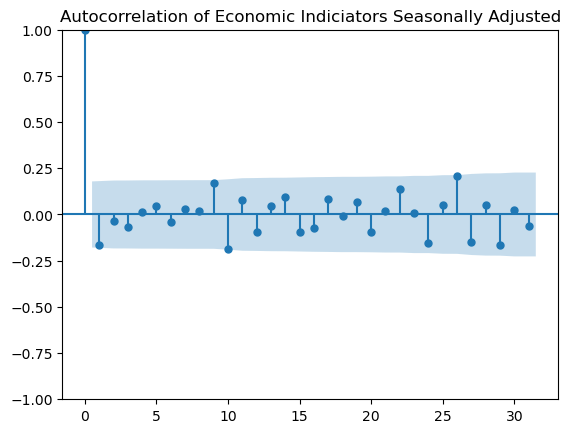

In [253]:
#Plot the seasonally adjusted acf
acf_values_economic_indicators_seasonally_adjusted = plot_acf(monthly_economic_indicators_seasonally_adjusted,lags=31,title='Autocorrelation of Economic Indiciators Seasonally Adjusted')

In [254]:
#Q orders
Q_orders_economic_indicators = [1,9,10]

#### P Orders for Economic Indicators

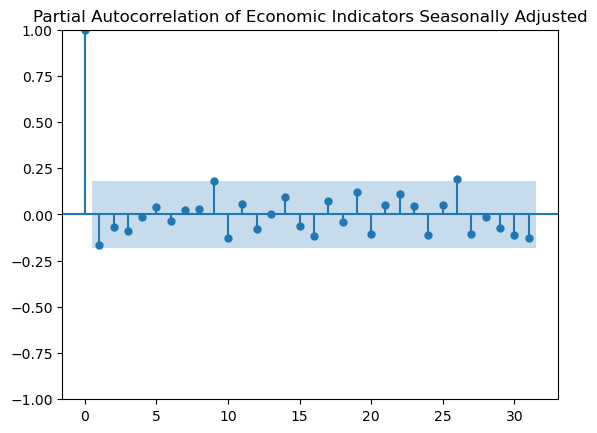

In [255]:
#Plot the seasonally adjusted for economic indiciators
pacf_values_economic_indicators_seasonally_adjusted = plot_pacf(monthly_economic_indicators_seasonally_adjusted, lags=31,title='Partial Autocorrelation of Economic Indicators Seasonally Adjusted')

In [256]:
#P economic indicators
P_orders_economic_indicators = [1,9]

#### D Orders for Economic Indicators

In [257]:
#Check the adf statistic
adf_test(monthly_economic_indicators_seasonally_adjusted)

ADF Statistic:  -12.78060792713153
P-Value:  7.429652010353552e-24
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [258]:
#D orders 
D_order_economic_indicators = [0,1]

#### Parameters for Box Jenkins Models
- q : 1,2,8,16
- p : 1,2,4,16
- d : 0,1
- Q : 1,2,8,20
- P : 1,2,4,14
- D : 0,1
- s : 12

#### AR Model Selection

In [259]:
#Find the best AR model
#Returns p 
select_best_ar_model(exchange_rate['Economic Indicators'],p_orders_economic_indicators)

{'best_aic': 328.8353611896672,
 'best_aic_model': 1,
 'best_bic': 337.1978364180133,
 'best_bic_model': 1}

#### MA Model Selection

In [260]:
#Find the best MA model
#Returns q
select_best_ma_model(exchange_rate['Economic Indicators'], q_orders_economic_indicators)

{'best_aic': 327.8852534919268,
 'best_aic_model': 1,
 'best_bic': 336.2477287202729,
 'best_bic_model': 1}

#### ARMA Model Selection

In [261]:
#Find the best ARMA model
#Returns p,q
select_best_arma_model(exchange_rate['Economic Indicators'],p_orders_economic_indicators,q_orders_economic_indicators)

{'best_aic': 42.0,
 'best_aic_model': (20, 20),
 'best_bic': 96.70857390574993,
 'best_bic_model': (20, 20)}

#### ARIMA Model Selection

In [262]:
#Find the best ARIMA model
#Returns p,d,q
select_best_arima(exchange_rate['Economic Indicators'],p_orders_economic_indicators,q_orders_economic_indicators,d_order_economic_indicators)

{'best_aic': 328.75754978443797,
 'best_aic_model': (1, 0, 1),
 'best_bic': 339.9075167555662,
 'best_bic_model': (1, 0, 1)}

In [263]:
#Find the best SARIMA model
#Returns p,d,q,P,D,Q,s
select_best_sarima_model(exchange_rate['Economic Indicators'],p_orders_economic_indicators,d_order_economic_indicators,q_orders_economic_indicators,P_orders_economic_indicators,D_order_economic_indicators,Q_orders_economic_indicators,12)

{'aic': 327.8852534936839,
 'bic': 336.24772872203,
 'pdq': (0, 0, 1),
 'seasonal_pdq': (0, 0, 0, 12)}

#### SARIMAX Model

In [275]:
# Instantiate and fit SARIMAX model
sarimax_model = SARIMAX(endog=exchange_rate['Economic Indicators'], exog=exchange_rate['Exchange Rates'], order=(0,1, 1), seasonal_order=(0, 0, 0, 12))
sarimax_result = sarimax_model.fit()
print(sarimax_result.aic)
print(sarimax_result.bic)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44309D+00    |proj g|=  1.91532D-01

At iterate    5    f=  1.38923D+00    |proj g|=  9.55093D-02

At iterate   10    f=  1.37563D+00    |proj g|=  8.43488D-04

At iterate   15    f=  1.37450D+00    |proj g|=  5.43435D-04

At iterate   20    f=  1.37437D+00    |proj g|=  1.66189D-03

At iterate   25    f=  1.37435D+00    |proj g|=  7.60360D-05

At iterate   30    f=  1.37435D+00    |proj g|=  3.75725D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


#### Best Model Selection
##### AR Model
AIC : 328.84
p : 1

BIC : 3937.20
p : 1
##### MA Model
AIC : 327.89
q : 1

BIC : 336.25
q : 1
##### ARMA Model
AIC : 42
p : 20,
q : 20

BIC : 96.7
p : 20,
q : 20
##### ARIMA Model
AIC : 328.76
p : 1,
d : 0,
q : 1

BIC : 339.91
p : 1,
d : 0,
q : 1

##### SARIMA Model
AIC :  327.89

BIC : 336.25

p : 0,
d : 0,
q : 1,
P : 0,
D : 0,
Q : 0,
s : 12

##### SARIMAX Model

AIC : 335.84

BIC : 334.18

##### The Best Model is ARMA
ARMA (20,20)

AIC : 42